In [1]:
!nvidia-smi

Tue Mar 18 10:25:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow.keras.models import load_model # Ability to load best_saved model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Function definitions

In [4]:
def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()


def class_distrib(y, labels_names, dataset_name):
        counts = pd.DataFrame(data=y).value_counts().sort_index()
        #print(f"counts:\n{counts}")
        fig, ax = plt.subplots(figsize=(20,10))
        ax.bar(labels_names, counts)
        ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
        plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
        plt.grid()
        plt.tight_layout()
        plt.show()

def augment_dataset(x, y):
        x = tf.image.resize(x, (224, 224))  # Resize images
        x = tf.image.random_flip_left_right(x)  # Random horizontal flip
        x = tf.image.random_brightness(x, max_delta=0.2)  # Adjust brightness
        x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  # Adjust contrast
        y = tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))  # One-hot encode labels
        return x, y

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
        # Plot Training and Validation Loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()


# Dropout(0.7), L2Reg(3e-1), weight_decay(3e-1), train_augmentation

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[17666].shape: (1,)
imgs[17666].shape: (32, 32, 3)


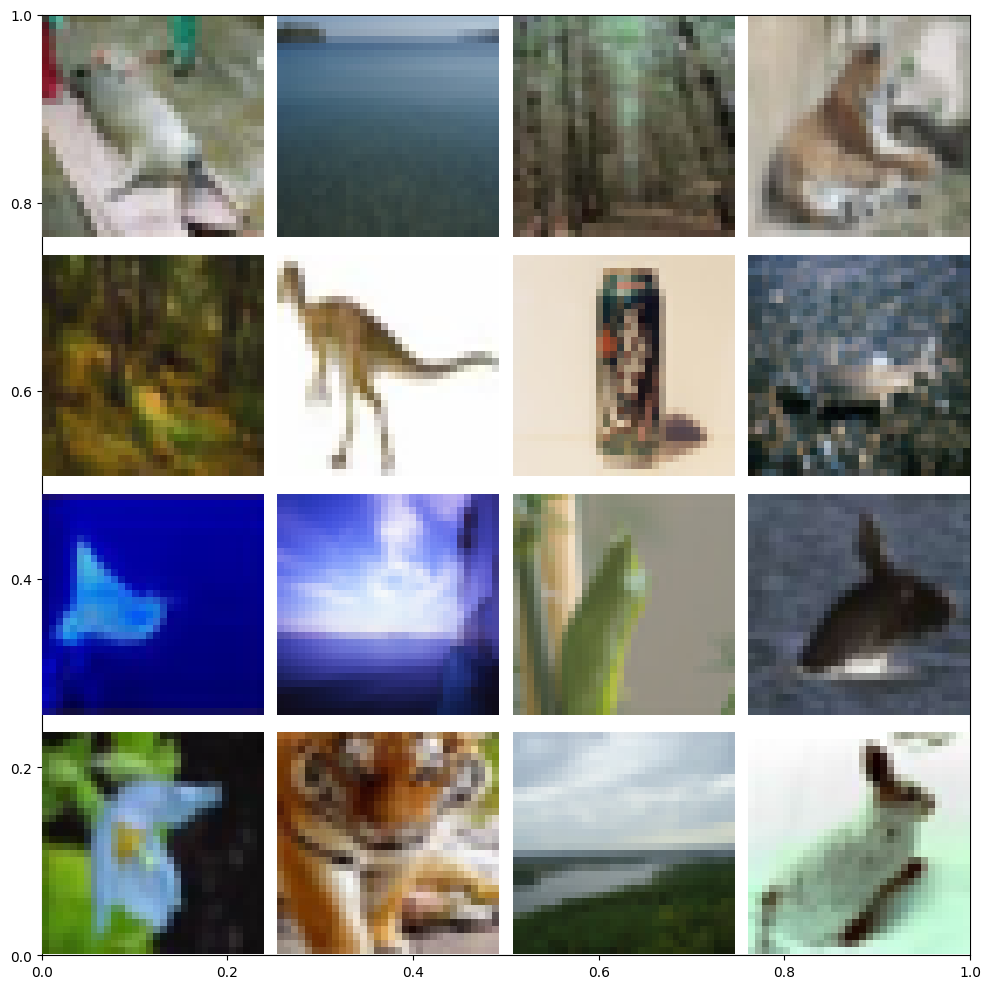

labels[28743].shape: (1,)
imgs[28743].shape: (32, 32, 3)


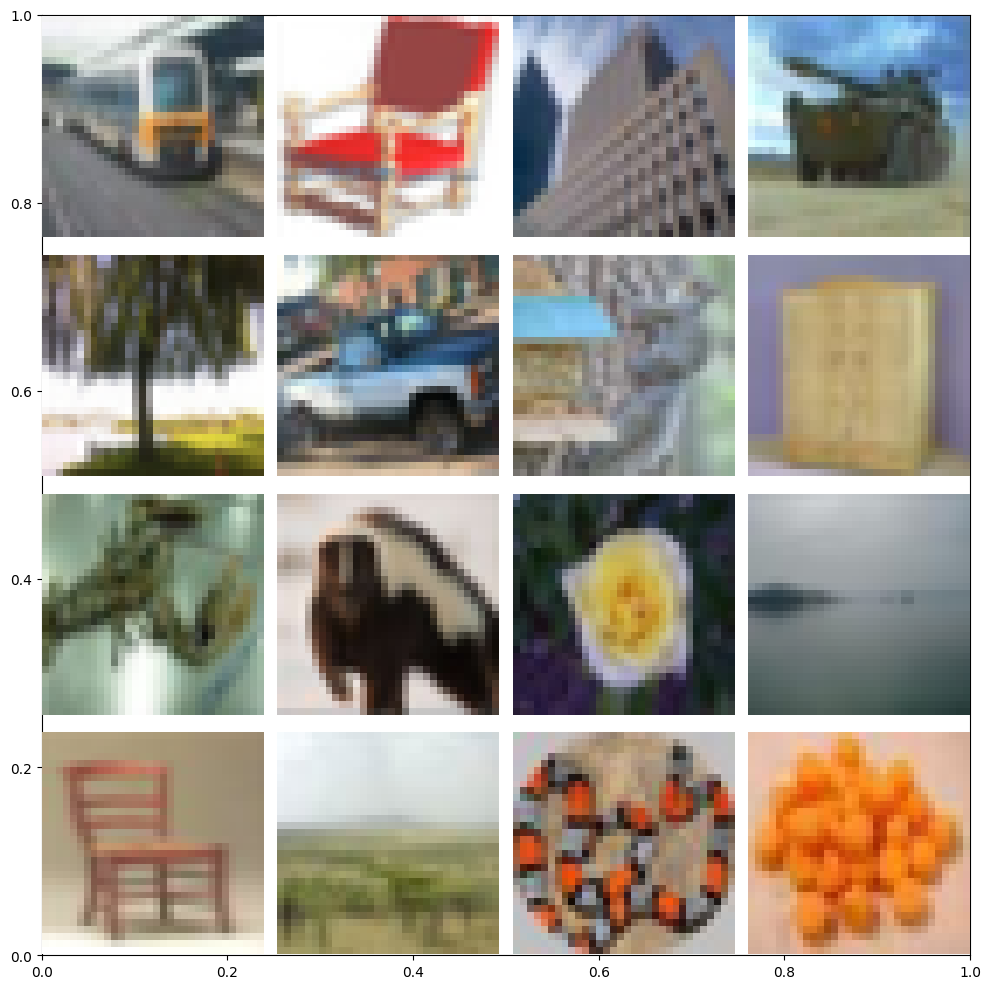

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


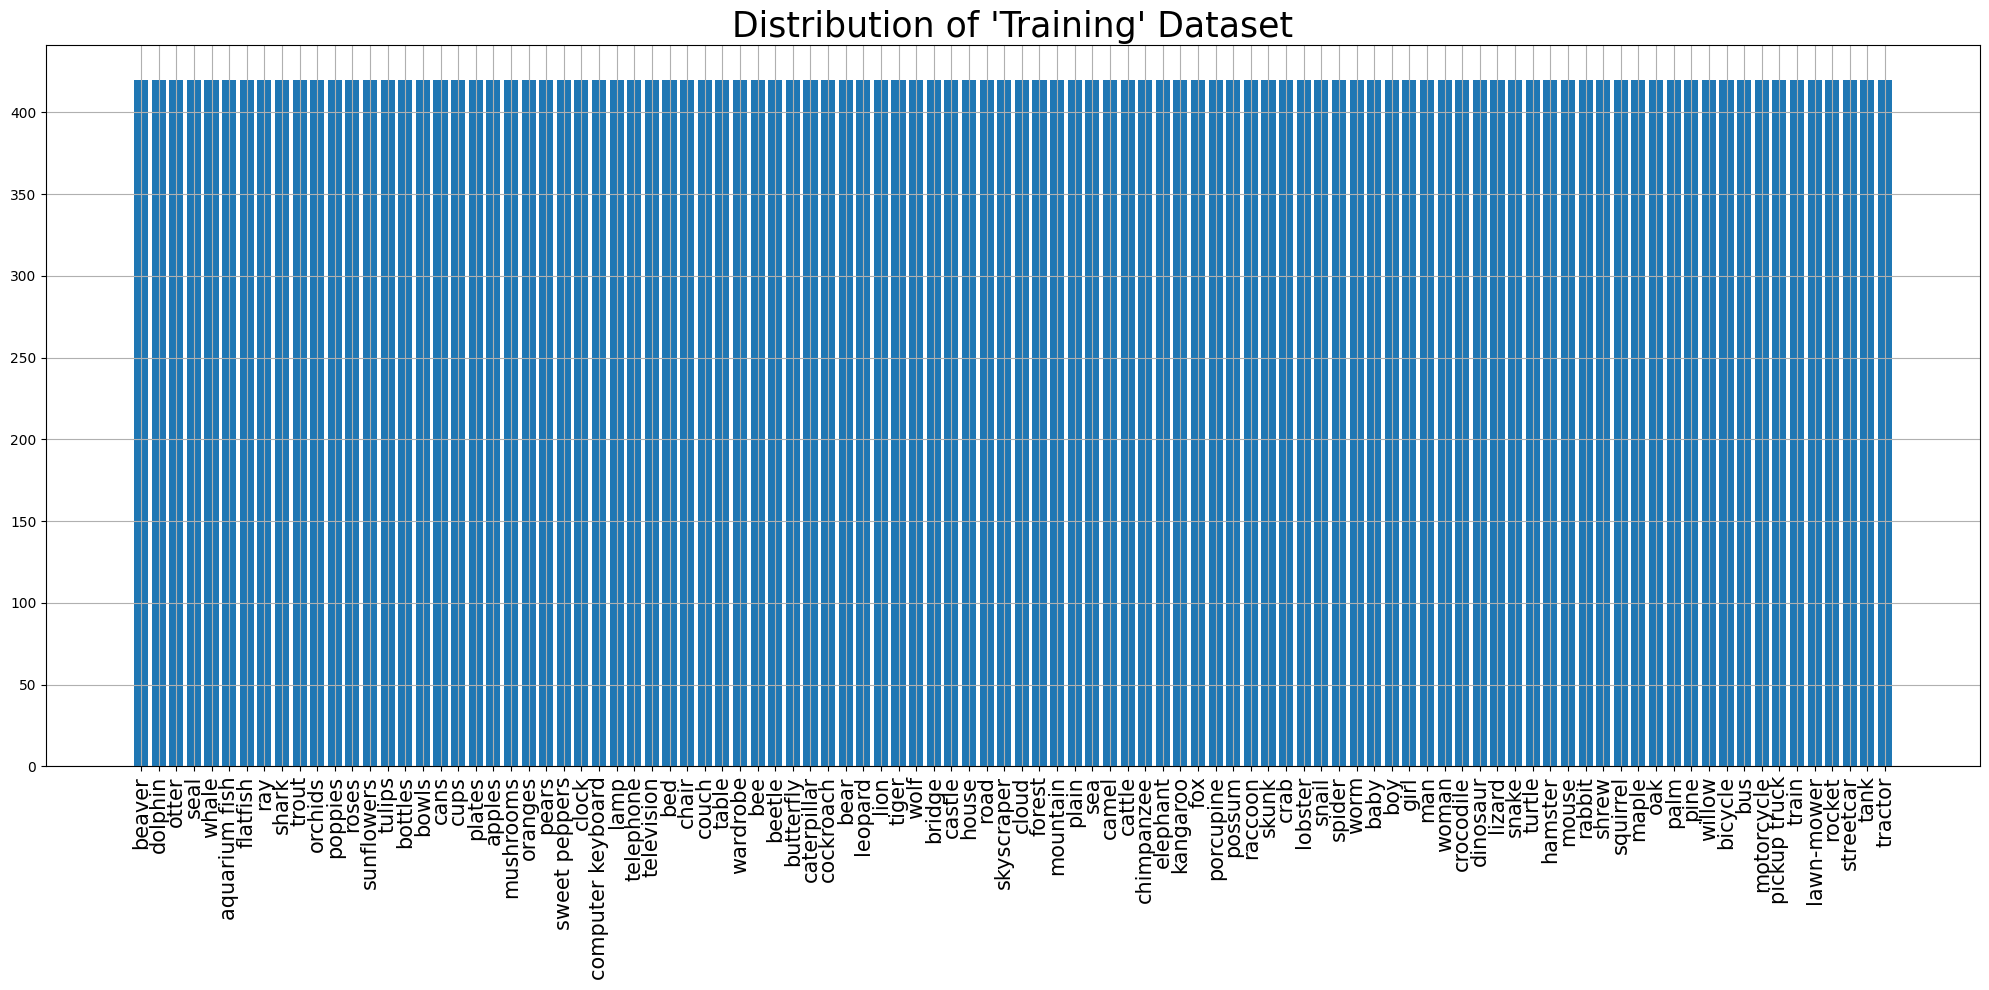

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


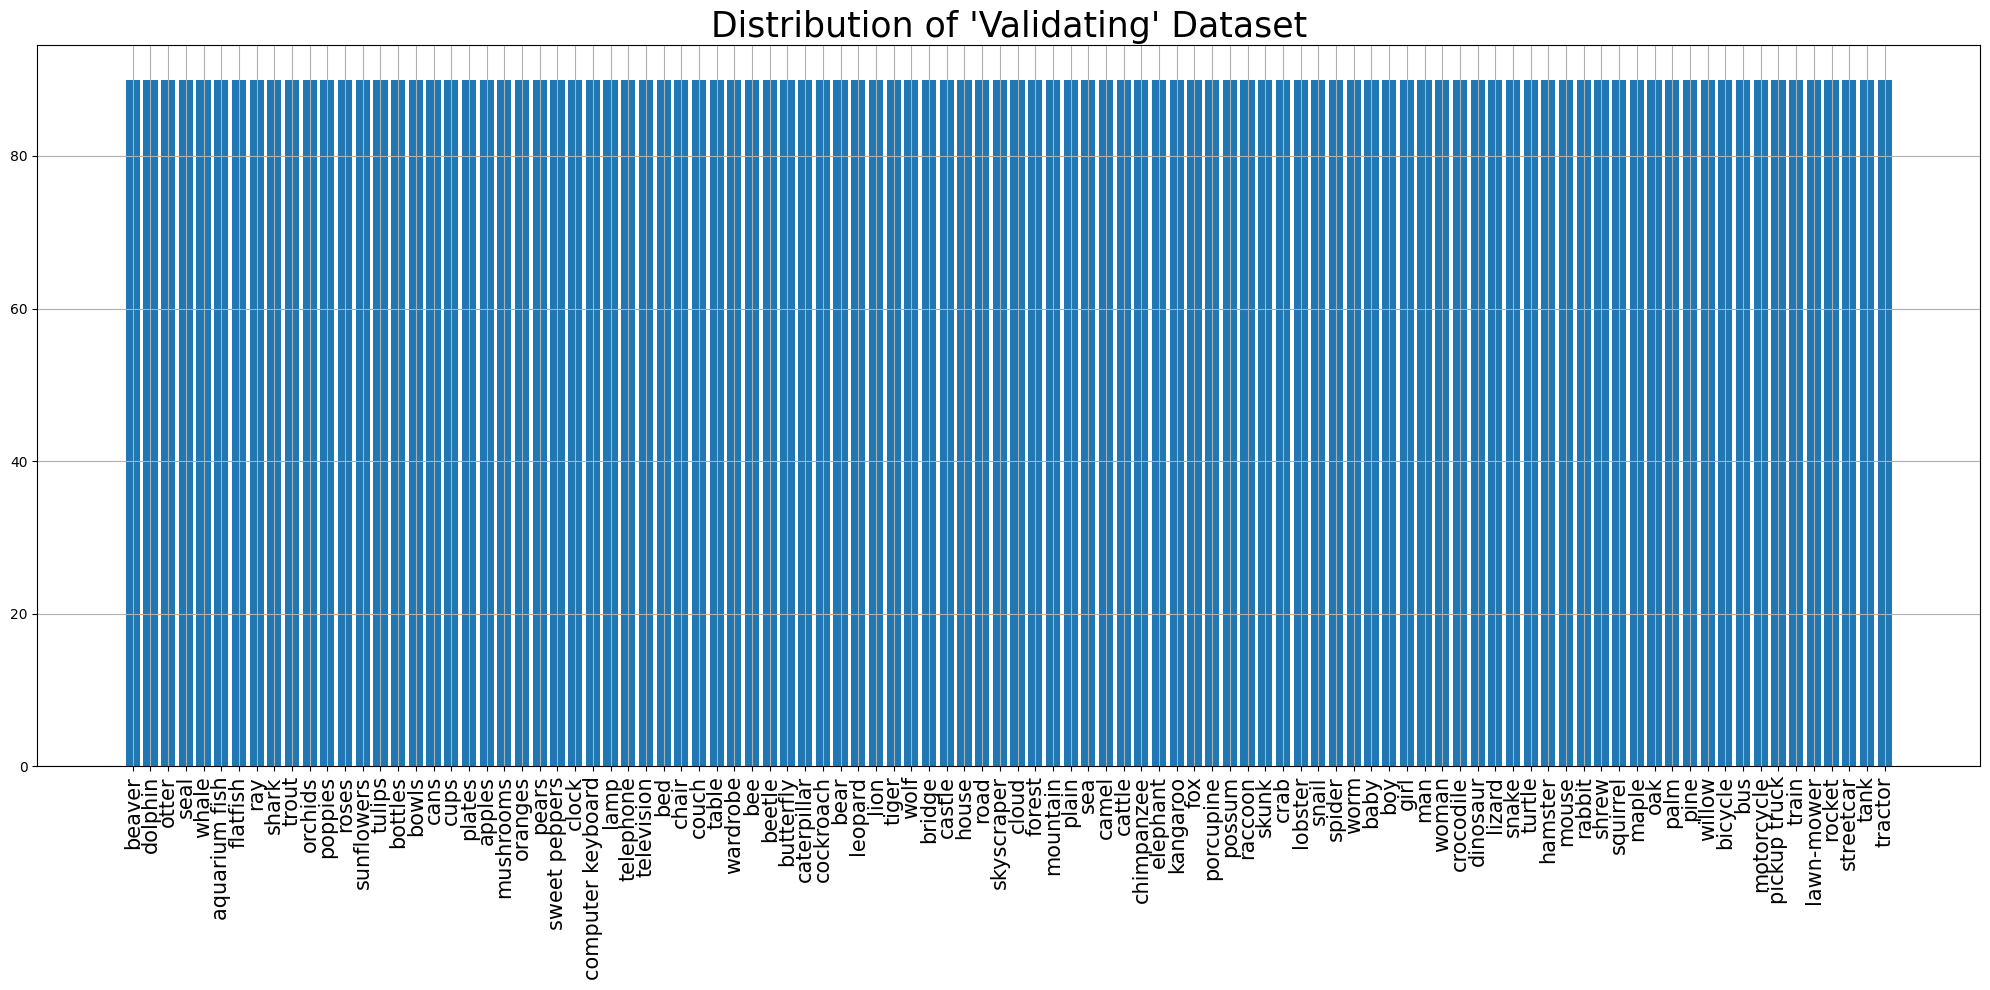

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


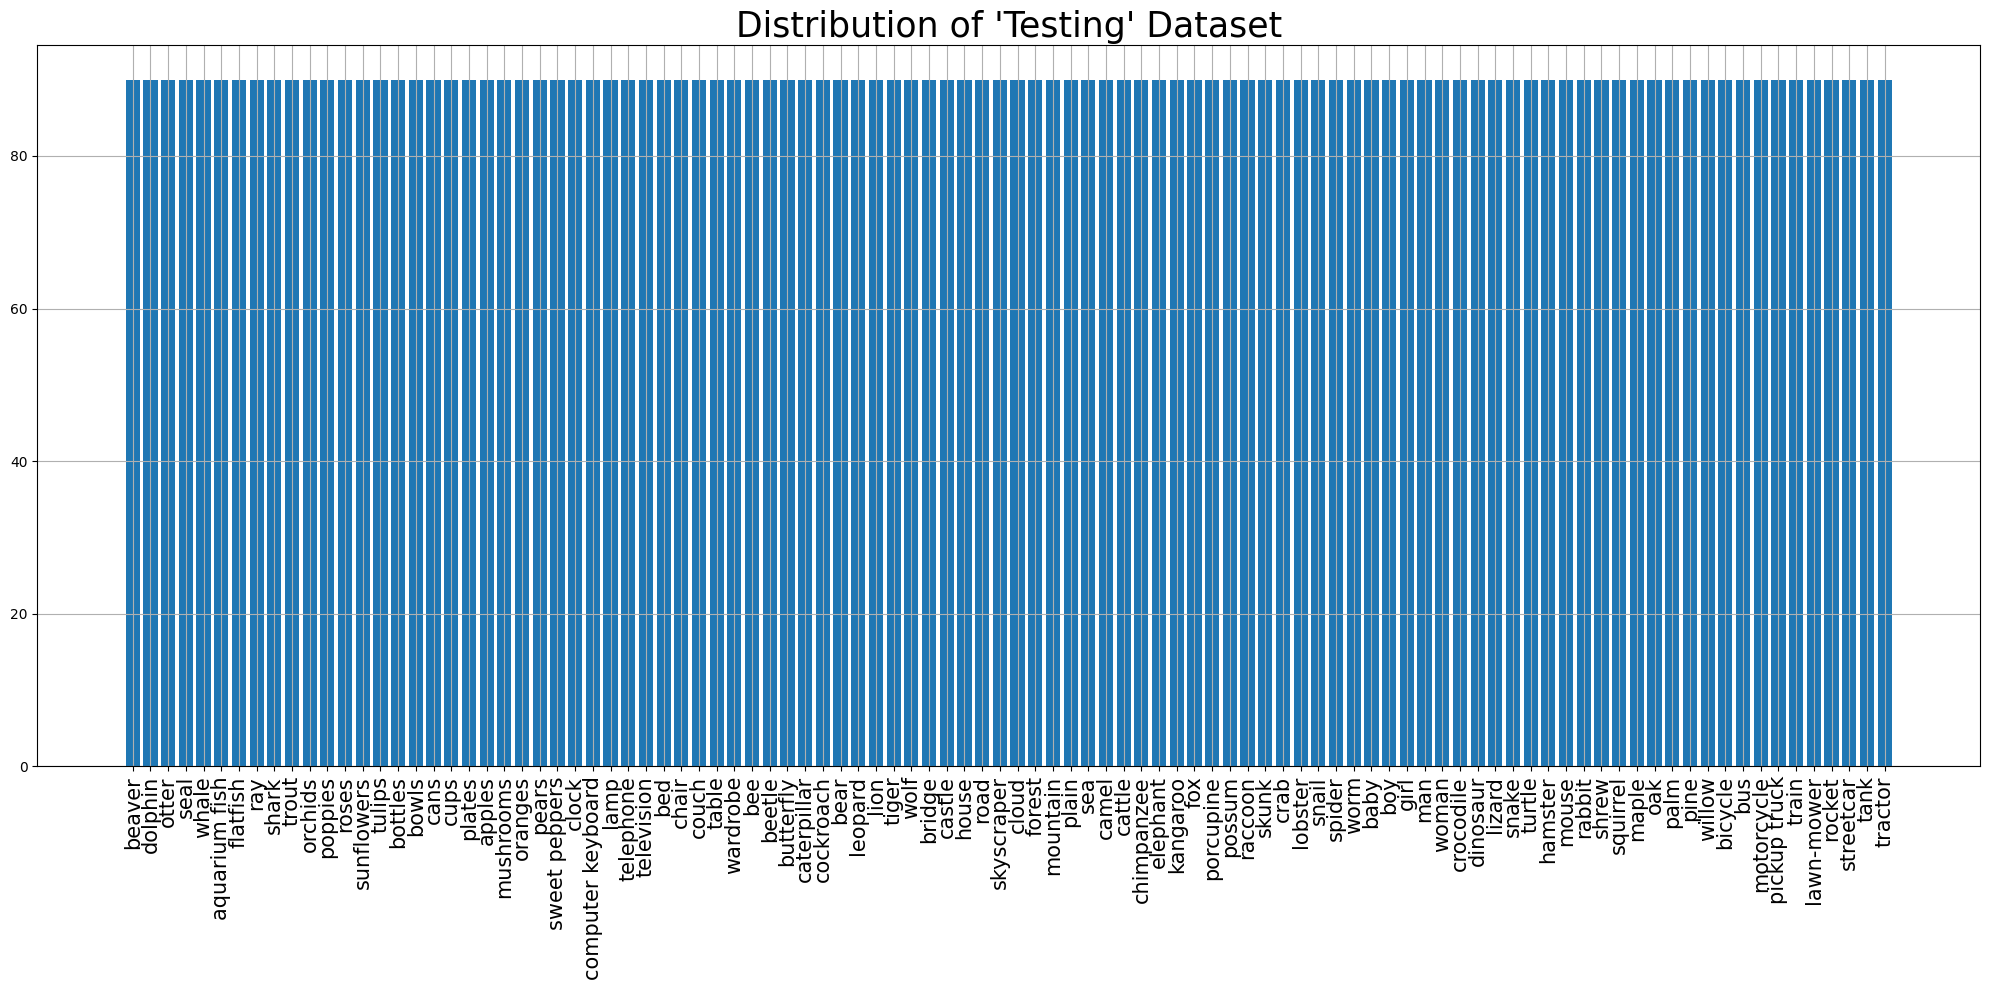

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3347 - f1_score: 0.3295 - loss: 2.7661 - precision: 0.6693
Epoch 1: val_loss improved from inf to 1.47019, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.3348 - f1_score: 0.3296 - loss: 2.7653 - precision: 0.6694 - val_accuracy: 0.5957 - val_f1_score: 0.5900 - val_loss: 1.4702 - val_precision: 0.8346
Epoch 2/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5124 - f1_score: 0.5080 - loss: 1.7733 - precision: 0.7504
Epoch 2: val_loss improved from 1.47019 to 1.38370, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5124 - f1_score: 0.5081 - loss: 1.7732 - precision: 0.7504 - val_accuracy: 0.6103 - val_f1_score: 0.6061 - val_loss: 1.3837 - val_precision: 0.8297
Epoch 3/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5355 - f1_score: 0.5319 - loss: 1.6632 - precision: 0.7579
Epoch 3: val_loss improved fro

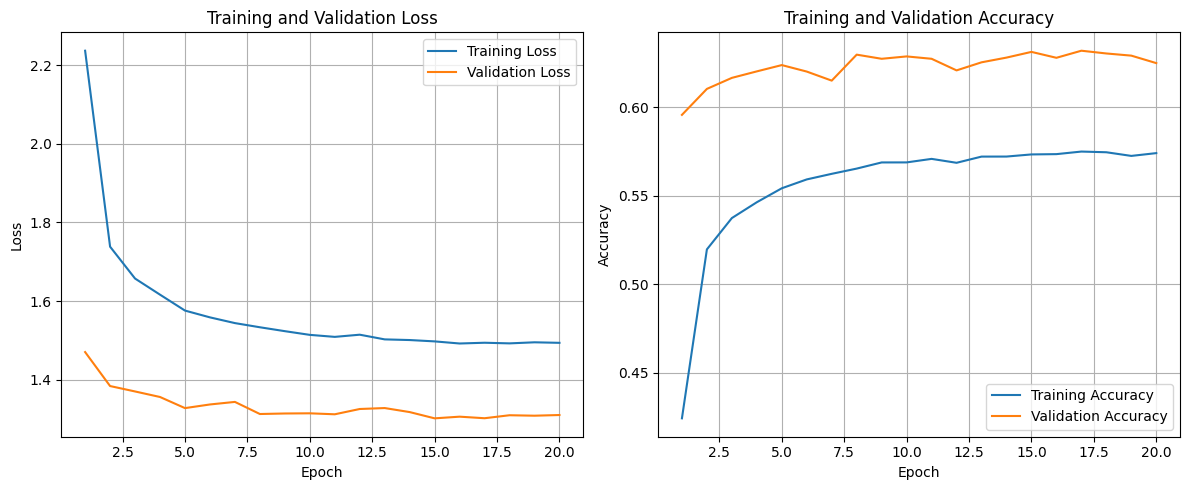

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6150 - f1_score: 0.6081 - loss: 1.3336 - precision: 0.8202
Test Accuracy: 62.68%
Test Loss: 1.305716633796692
Test Precision: 83.13%
Test F1 Scores (Per Class): [82.63472  78.918915 53.107338 49.673195 32.258057 63.687145 57.00482
 61.928932 79.28994  80.43478  54.421764 47.533627 66.242035 51.81818
 65.359474 53.153145 72.53885  68.722466 49.999992 57.66871  77.41935
 74.73684  77.83783  78.30688  76.92307  61.224483 47.368412 41.666664
 73.26733  65.517235 60.130722 62.29508  44.585983 51.101315 64.676605
 20.96774  71.33758  57.317066 48.520706 87.95179  67.90123  78.65168
 60.869556 69.76743  44.761898 48.837204 54.794514 50.22421  80.43478
 83.90804  44.324318 73.291916 58.883244 85.549126 64.13043  37.914684
 78.85714  67.980286 70.66666  51.094883 78.12499  70.526306 57.142853
 66.26506  38.80597  53.521126 62.275444 57.60869  84.57711  85.22727
 64.13043  71.1111   39.52095  52.873566 36.2573   80.22598  85.057465
 56.470

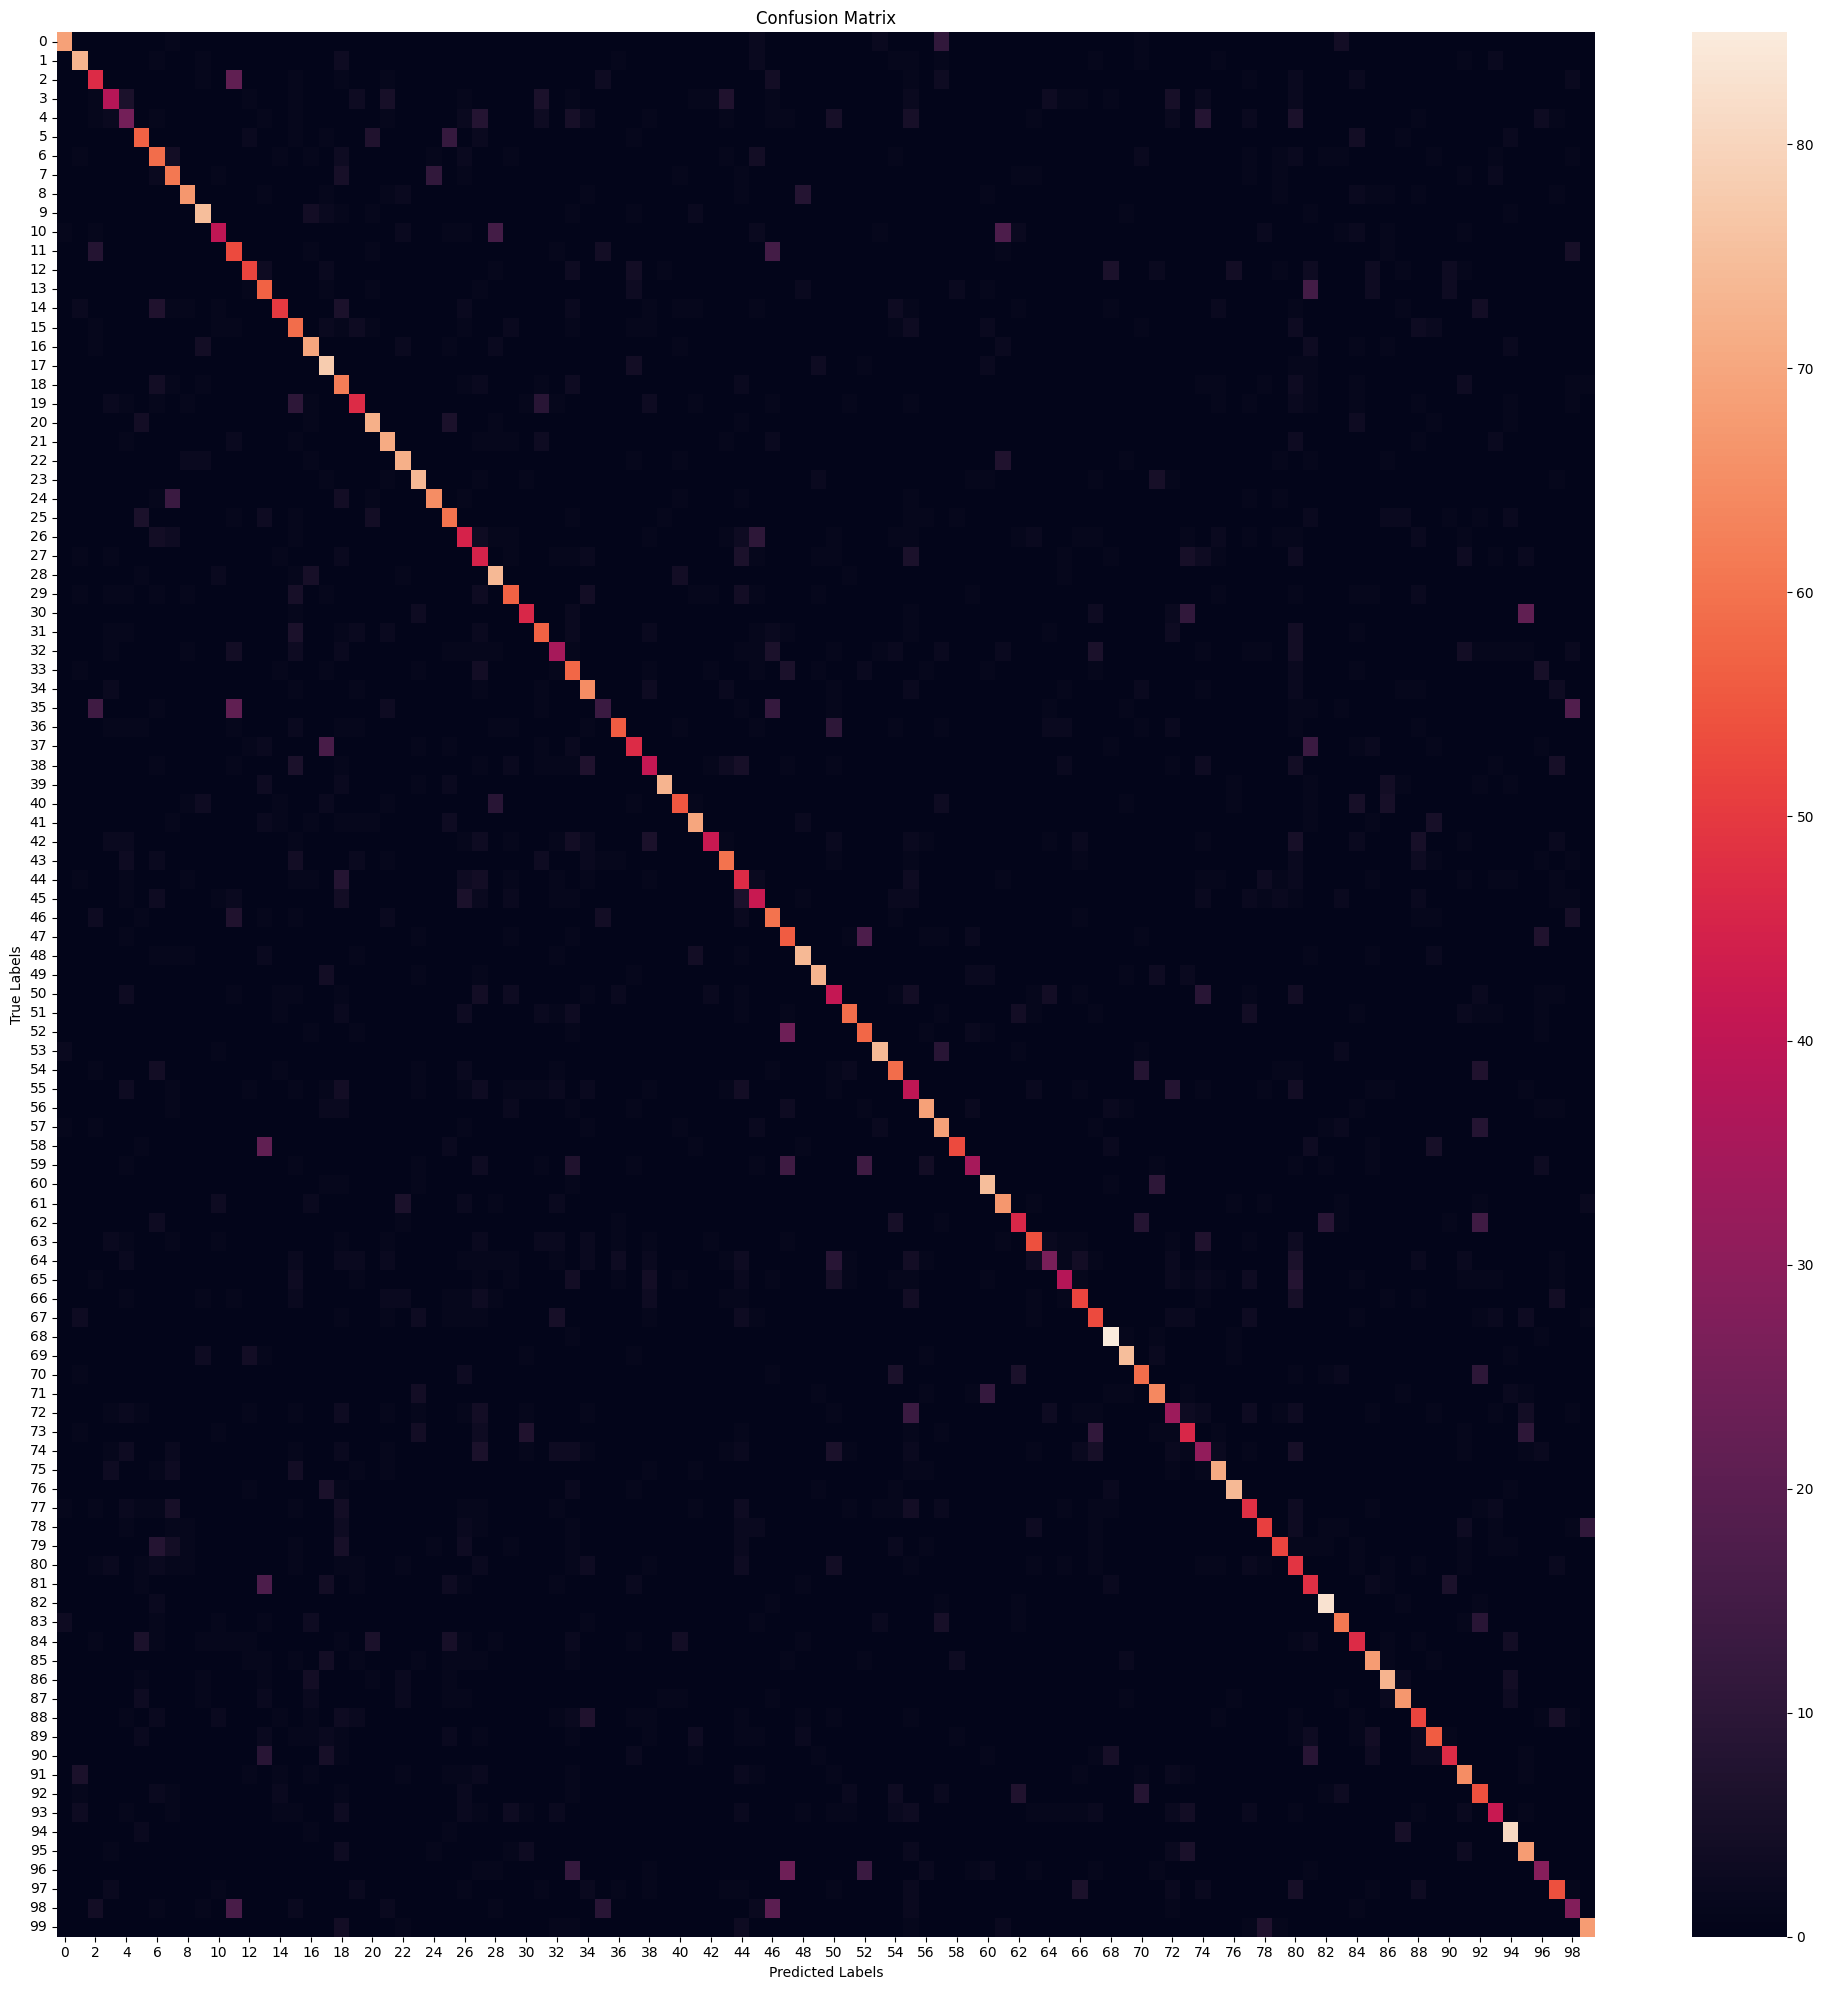

                   precision    recall  f1-score   support

           beaver       0.90      0.77      0.83        90
          dolphin       0.77      0.81      0.79        90
            otter       0.54      0.52      0.53        90
             seal       0.60      0.42      0.50        90
            whale       0.38      0.28      0.32        90
    aquarium fish       0.64      0.63      0.64        90
         flatfish       0.50      0.66      0.57        90
              ray       0.57      0.68      0.62        90
            shark       0.85      0.74      0.79        90
            trout       0.79      0.83      0.81        90
          orchids       0.70      0.44      0.54        90
          poppies       0.40      0.59      0.48        90
            roses       0.78      0.58      0.66        90
       sunflowers       0.44      0.63      0.52        90
           tulips       0.79      0.56      0.65        90
          bottles       0.45      0.66      0.53       

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5992 - f1_score: 0.5966 - loss: 1.3871 - precision: 0.7946
Epoch 1: val_loss improved from inf to 1.23884, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.5992 - f1_score: 0.5967 - loss: 1.3871 - precision: 0.7946 - val_accuracy: 0.6458 - val_f1_score: 0.6438 - val_loss: 1.2388 - val_precision: 0.8297
Epoch 2/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6236 - f1_score: 0.6209 - loss: 1.2915 - precision: 0.8090
Epoch 2: val_loss improved from 1.23884 to 1.22756, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - accuracy: 0.6236 - f1_score: 0.6209 - loss: 1.2915 - precision: 0.8090 - val_accuracy: 0.6472 - val_f1_score: 0.6452 - val_loss: 1.2276 - val_precision: 0.8268
Epoch 3/15
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6364 - f1_score: 0.6336 - loss: 1.2499 - precision: 0.8162
Epoch 3: v

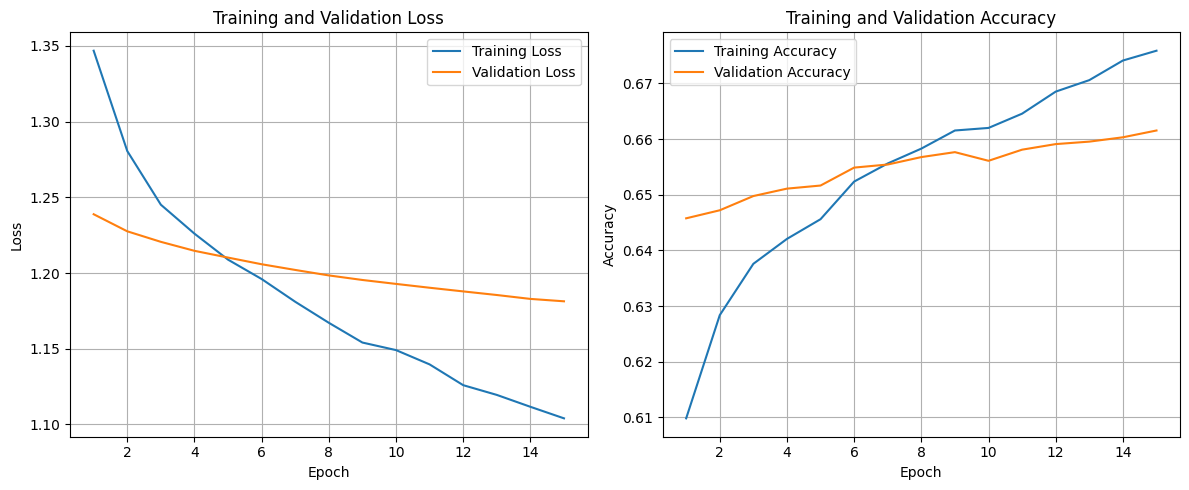

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6517 - f1_score: 0.6436 - loss: 1.1959 - precision: 0.8205
Test Accuracy: 66.22%
Test Loss: 1.1718369722366333
Test Precision: 82.86%
Test F1 Scores (Per Class): [85.39326  79.99999  55.208332 53.551907 39.3617   64.51612  63.917522
 68.888885 81.437126 78.40909  62.702698 51.219505 65.89595  57.142853
 68.23529  59.428566 74.87179  77.31957  60.540535 60.919537 80.87432
 78.30688  84.32432  80.21977  79.78141  66.66666  51.136356 47.846886
 78.16091  70.93022  61.202175 69.461075 55.75757  58.41583  69.18918
 32.768353 68.888885 62.032085 52.272724 89.65517  71.65774  82.35293
 62.06896  69.31818  50.793648 48.087425 52.51396  52.760727 83.59788
 84.74575  43.37349  74.999985 63.999992 89.887634 68.68686  34.939754
 82.142845 70.71823  77.8443   53.987724 77.09496  74.28571  67.6923
 62.14689  46.341457 59.036137 60.439552 62.63736  87.83068  85.405396
 67.05882  71.276596 41.212116 56.830597 38.67403  82.872925 87.43169
 59.880

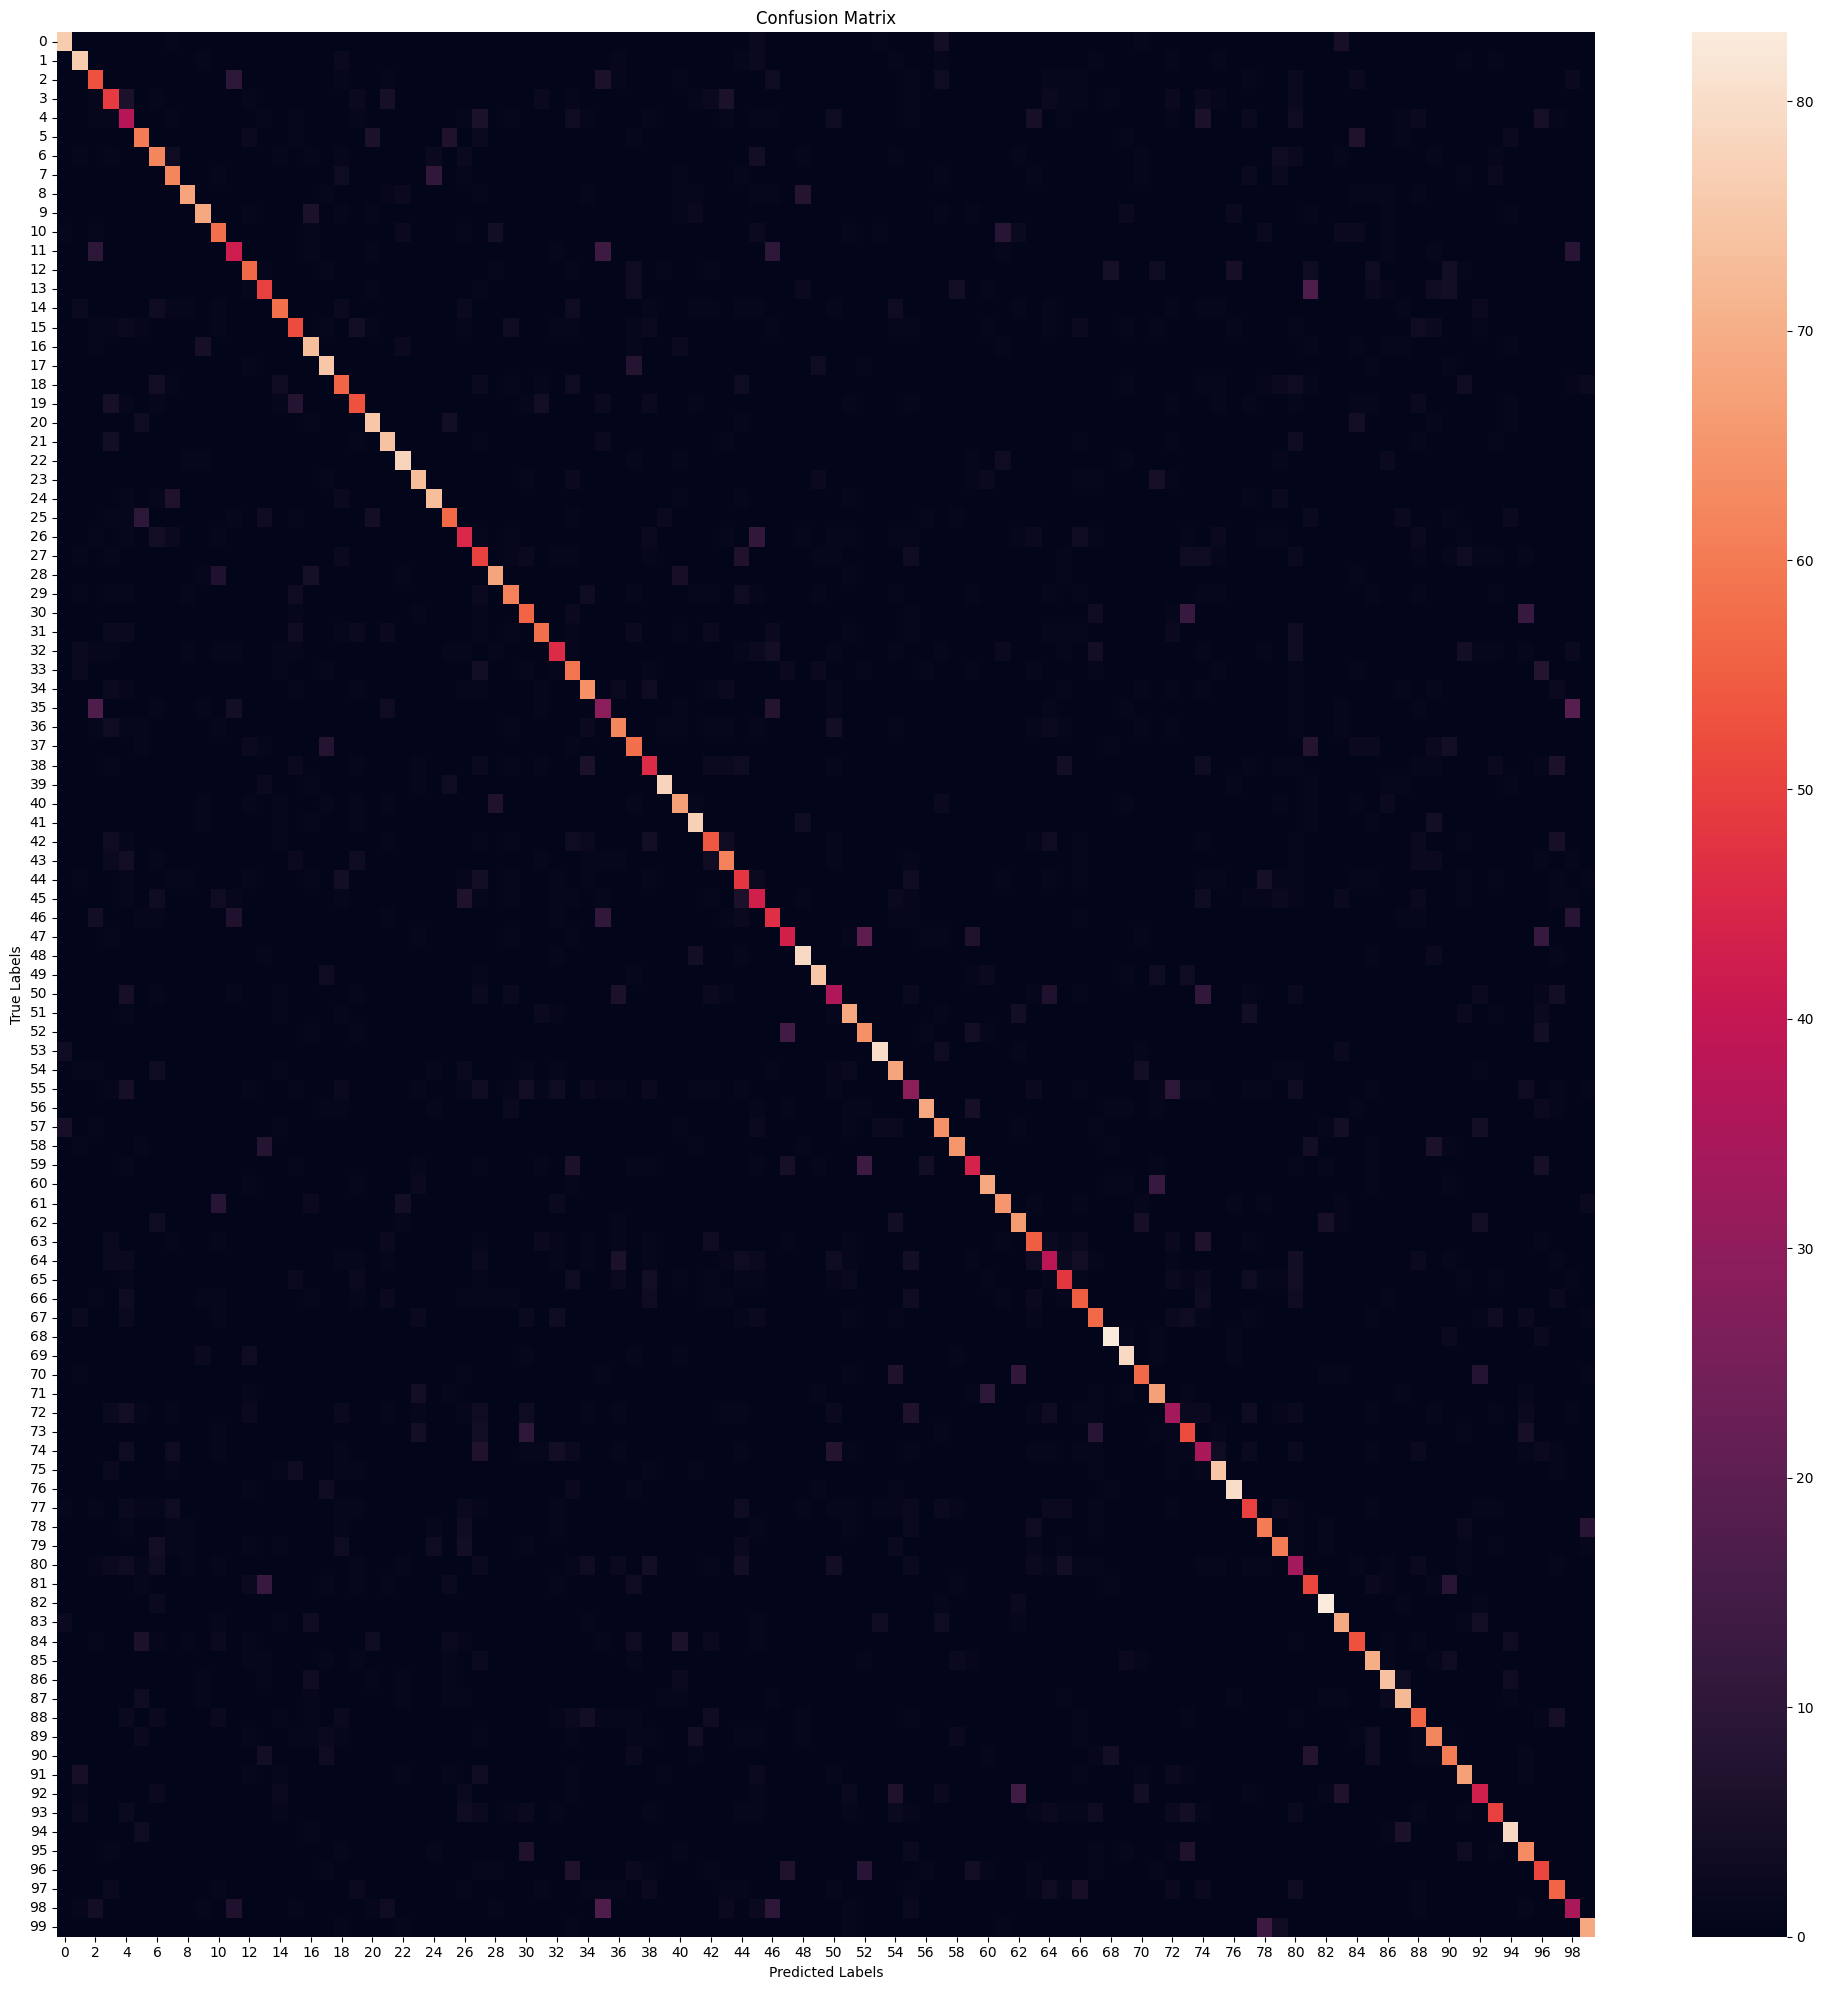

                   precision    recall  f1-score   support

           beaver       0.86      0.84      0.85        90
          dolphin       0.76      0.84      0.80        90
            otter       0.52      0.59      0.55        90
             seal       0.53      0.54      0.54        90
            whale       0.38      0.41      0.39        90
    aquarium fish       0.62      0.67      0.65        90
         flatfish       0.60      0.69      0.64        90
              ray       0.69      0.69      0.69        90
            shark       0.88      0.76      0.81        90
            trout       0.80      0.77      0.78        90
          orchids       0.61      0.64      0.63        90
          poppies       0.57      0.47      0.51        90
            roses       0.69      0.63      0.66        90
       sunflowers       0.59      0.56      0.57        90
           tulips       0.72      0.64      0.68        90
          bottles       0.61      0.58      0.59       

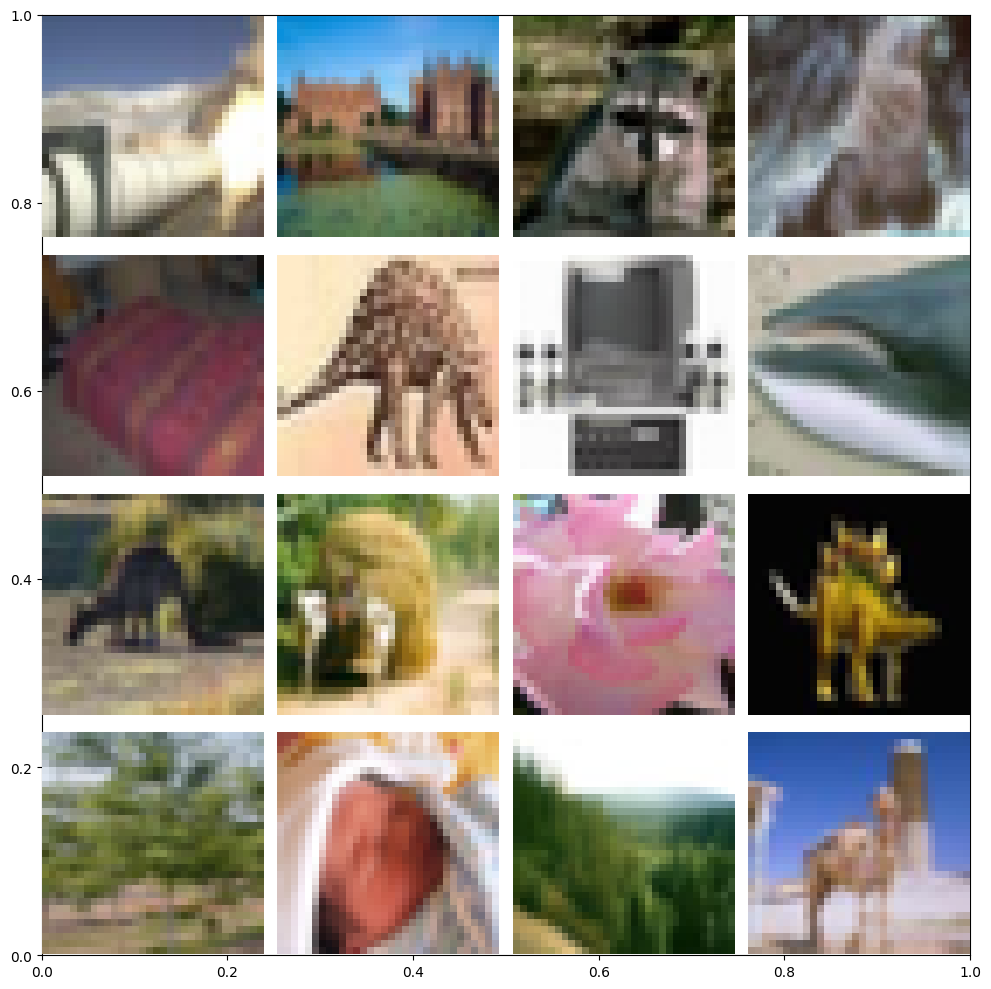

labels[28387].shape: (1,)
imgs[28387].shape: (32, 32, 3)


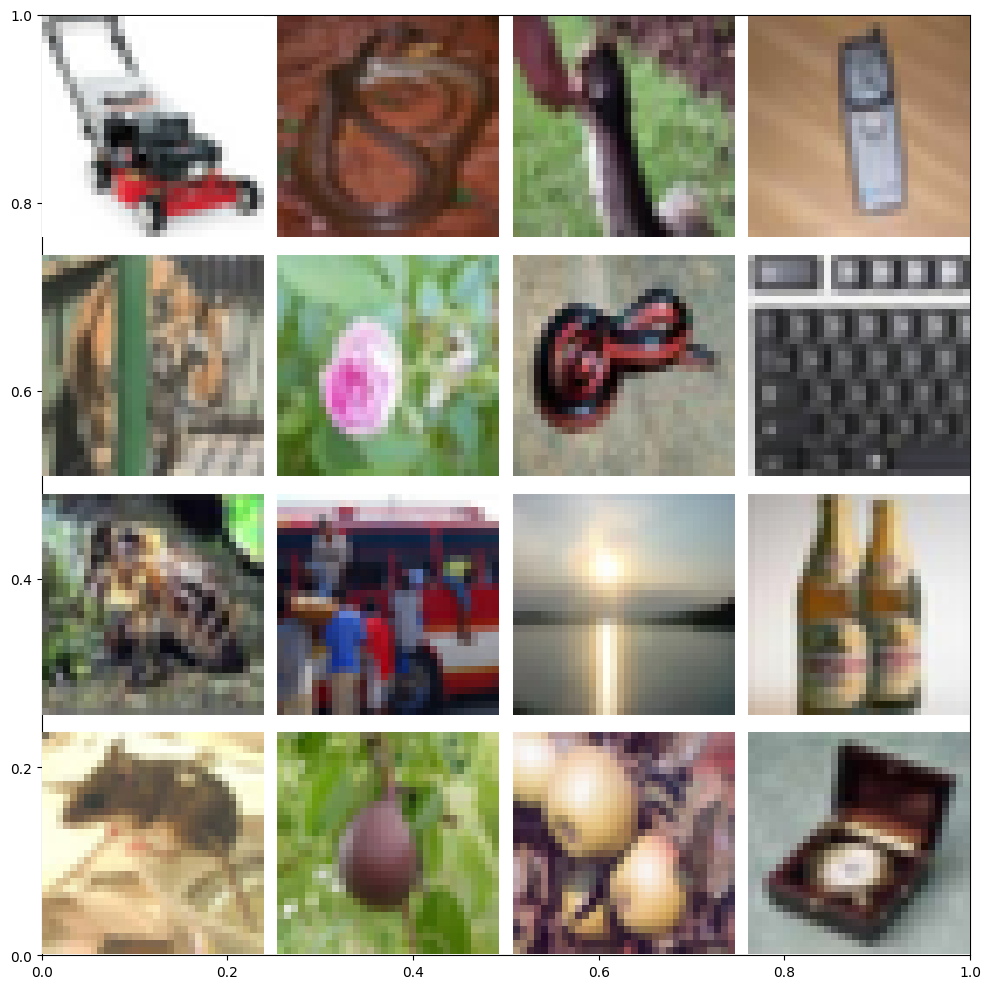

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


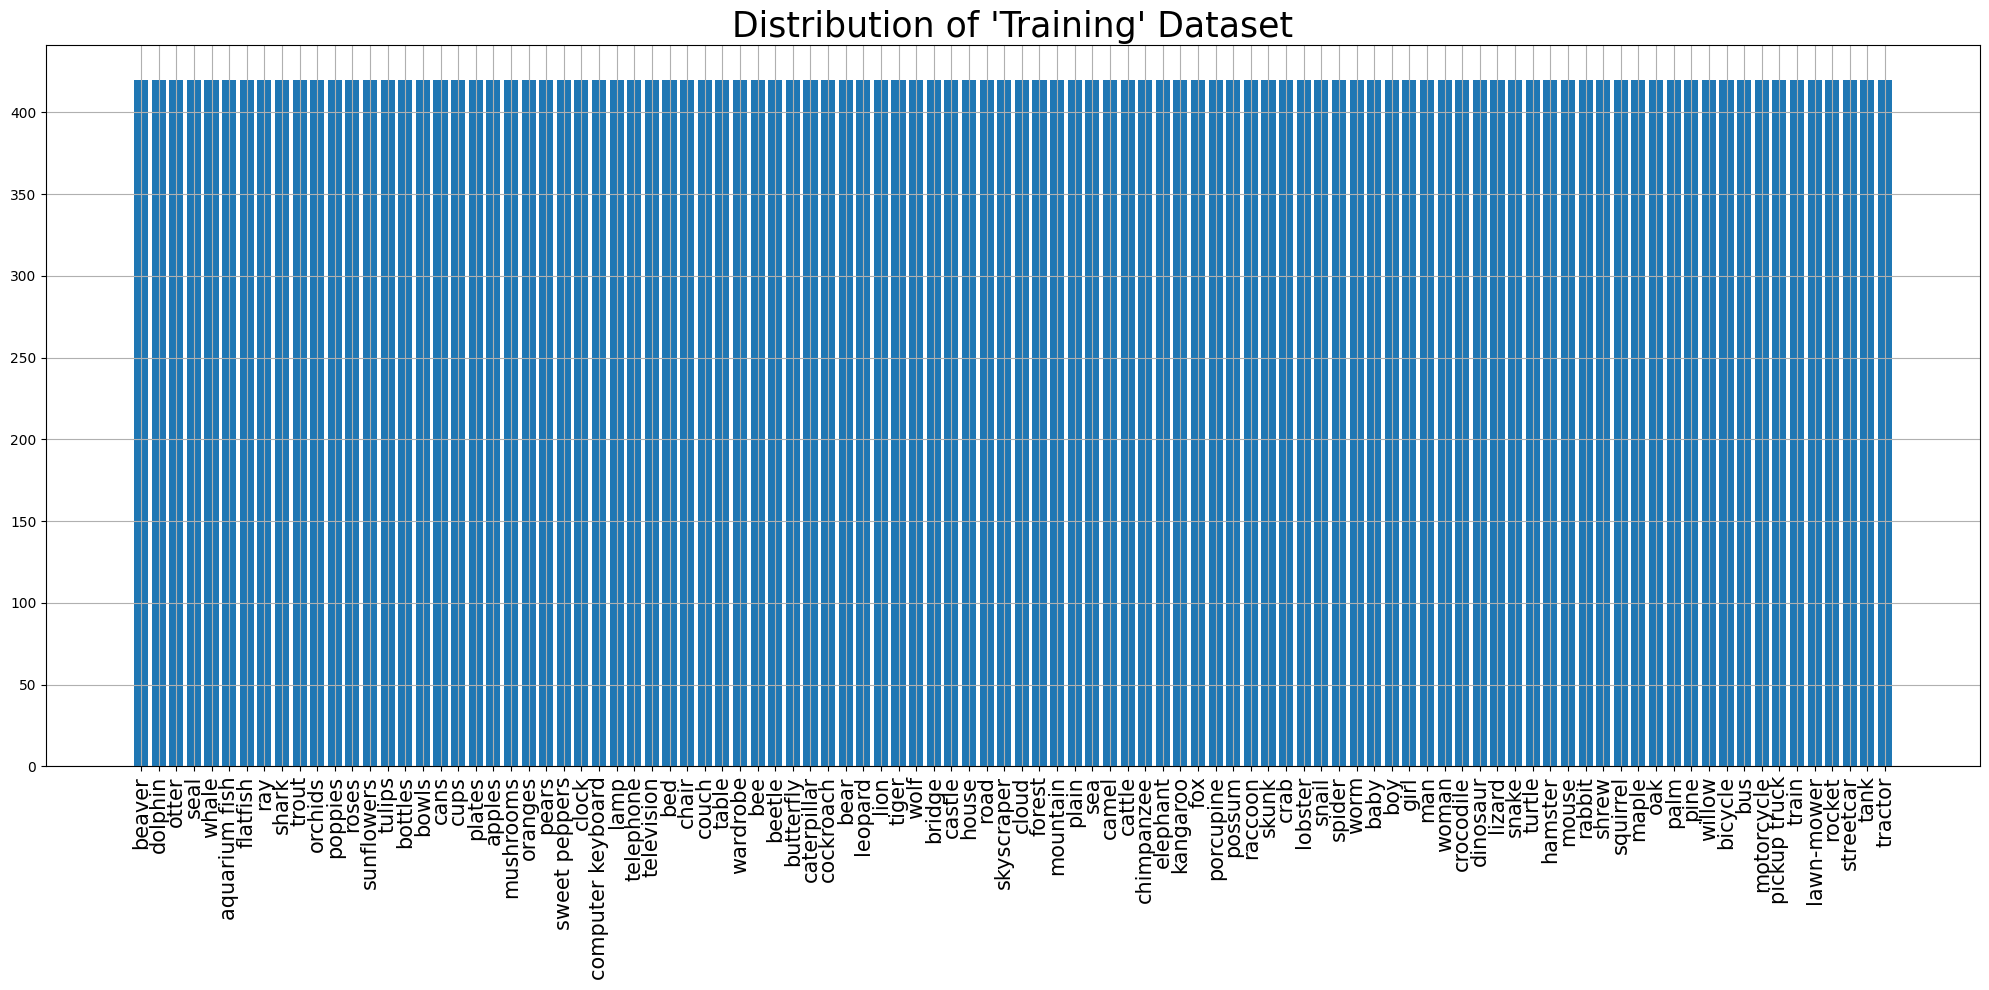

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


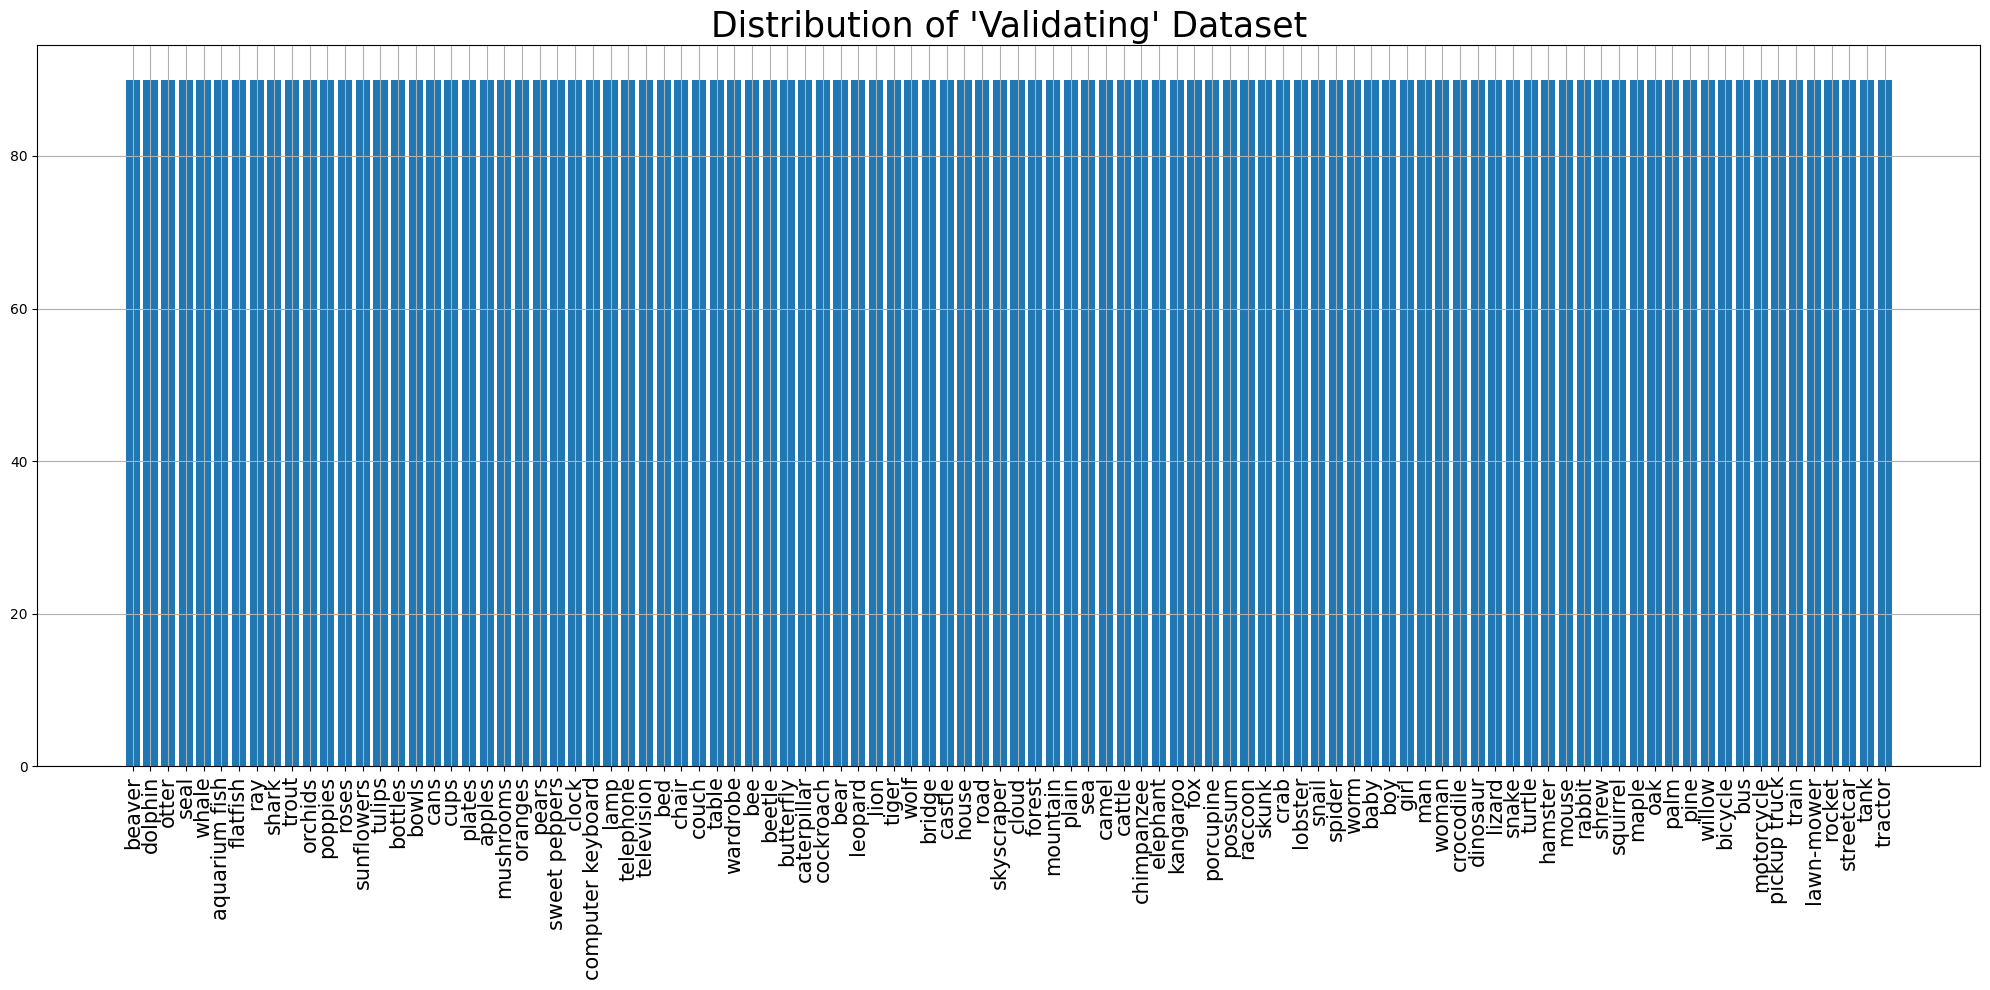

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


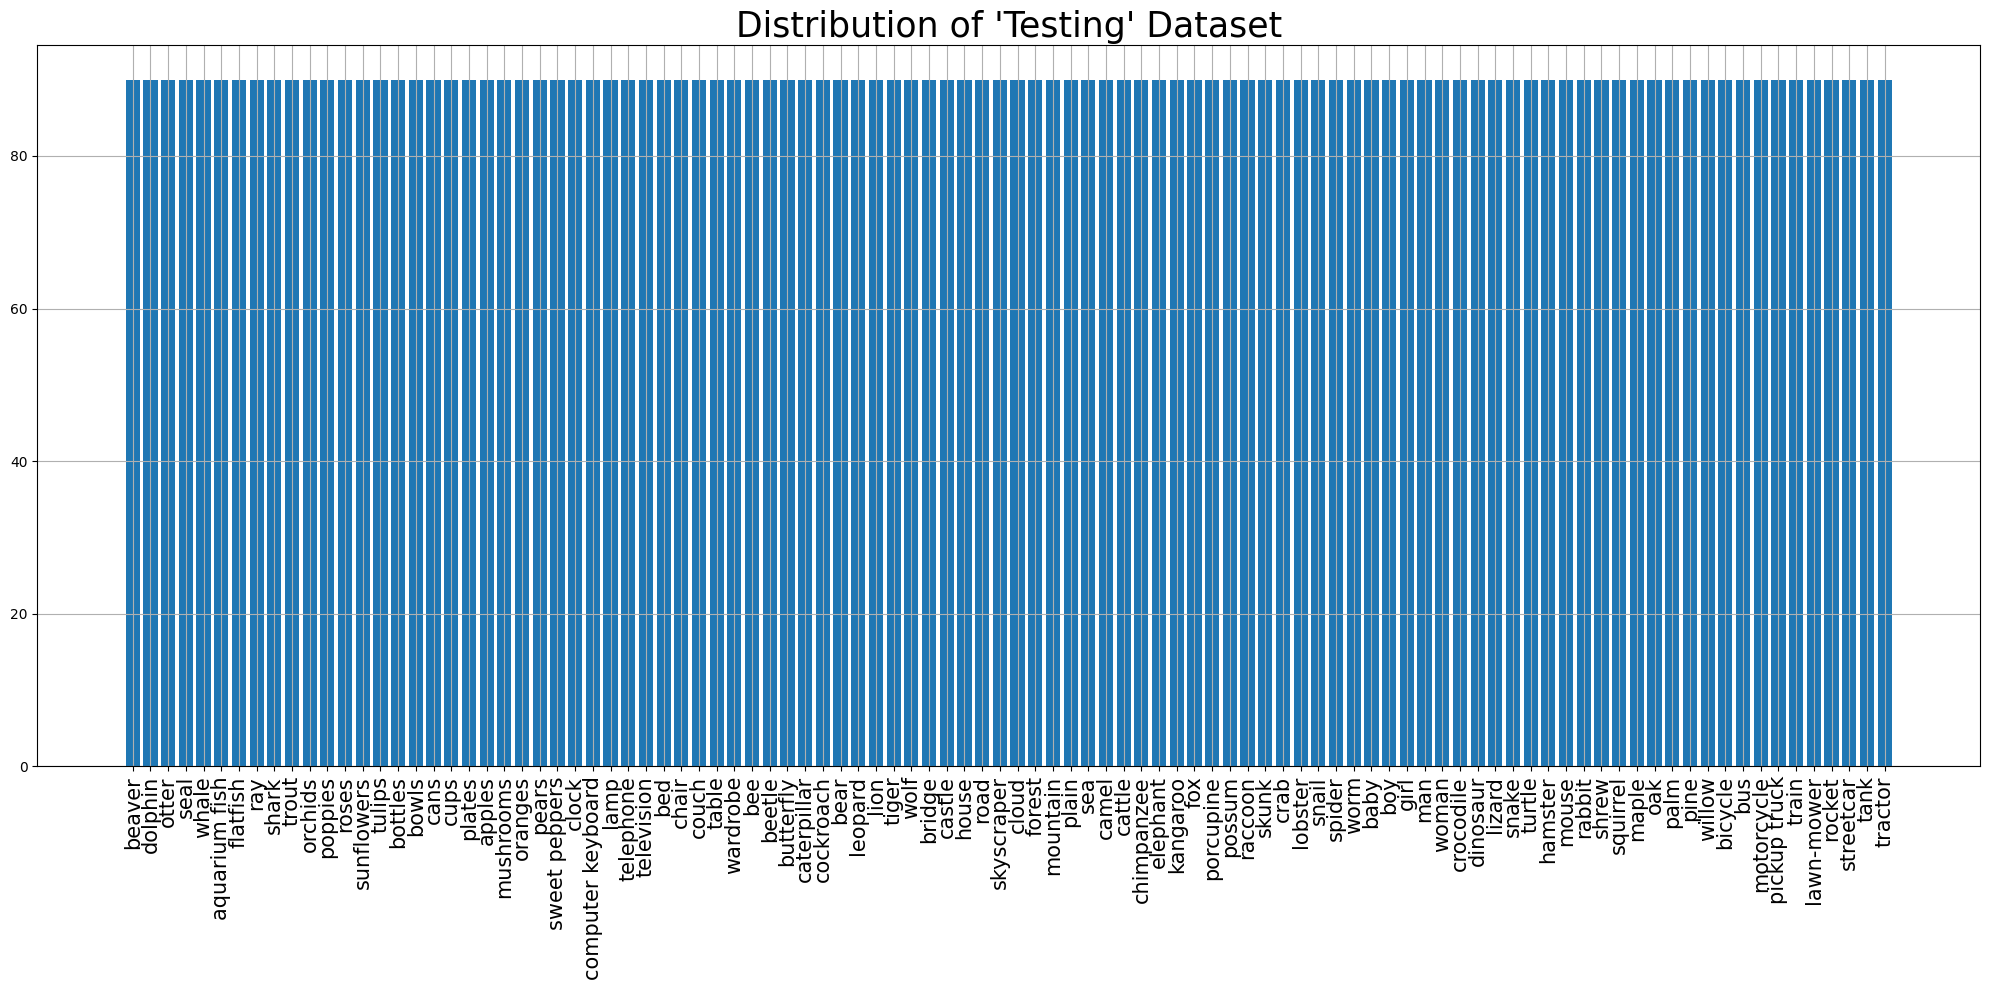

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3308 - f1_score: 0.3253 - loss: 2.7982 - precision: 0.6726
Epoch 1: val_loss improved from inf to 1.47552, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.3309 - f1_score: 0.3255 - loss: 2.7974 - precision: 0.6726 - val_accuracy: 0.5954 - val_f1_score: 0.5909 - val_loss: 1.4755 - val_precision: 0.8350
Epoch 2/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5103 - f1_score: 0.5057 - loss: 1.7821 - precision: 0.7487
Epoch 2: val_loss improved from 1.47552 to 1.39231, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5103 - f1_score: 0.5057 - loss: 1.7820 - precision: 0.7487 - val_accuracy: 0.6112 - val_f1_score: 0.6085 - val_loss: 1.3923 - val_precision: 0.8314
Epoch 3/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5339 - f1_score: 0.5302 - loss: 1.6712 - precision: 0.7602
Epoch 3: val_loss improved fro

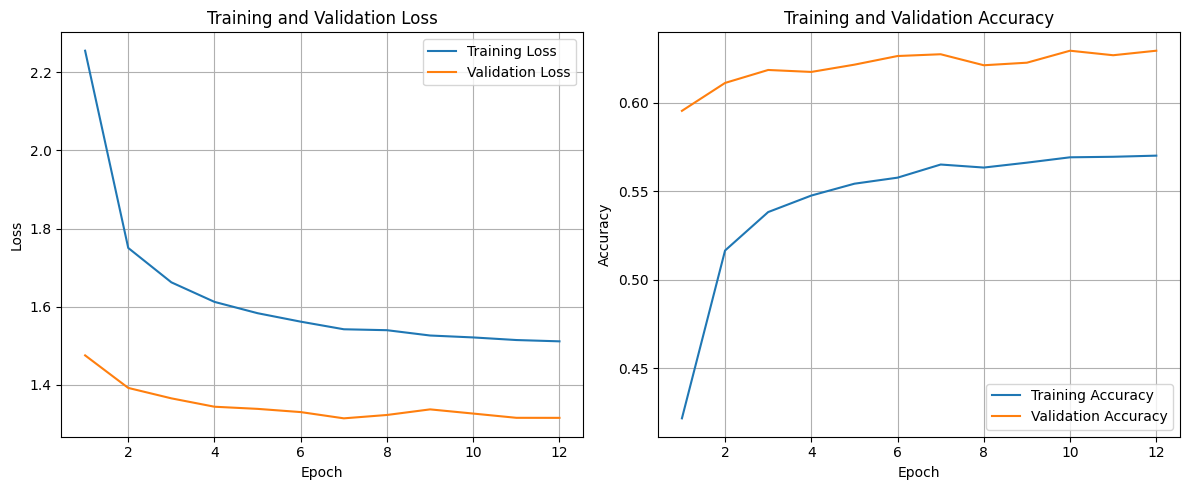

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6110 - f1_score: 0.6016 - loss: 1.3410 - precision: 0.8140
Test Accuracy: 62.82%
Test Loss: 1.3076353073120117
Test Precision: 82.98%
Test F1 Scores (Per Class): [83.5294   74.46808  53.551907 42.465748 25.563904 64.48598  58.878494
 68.926544 82.352936 77.27273  60.645157 46.63212  65.85365  58.461536
 62.032085 62.365585 76.59574  69.36936  52.173912 52.229298 76.92307
 73.93939  73.809525 76.02339  78.723404 63.803684 51.366108 46.857132
 77.89473  64.93506  54.43037  63.2653   49.397583 50.819664 61.052628
 20.869562 68.53932  59.574467 47.12643  88.09524  68.53932  79.55801
 58.333324 69.005844 49.514557 46.258495 47.45762  53.012043 81.72042
 82.22221  40.999996 70.80744  60.78431  86.904755 68.449196 36.756752
 73.01586  70.40816  79.51807  40.9836   78.65168  71.219505 53.947365
 61.90476  37.593983 53.947365 63.75     55.384613 83.76962  80.92485
 67.77777  71.87499  32.167828 56.999992 35.502953 76.43979  87.43169
 54.0

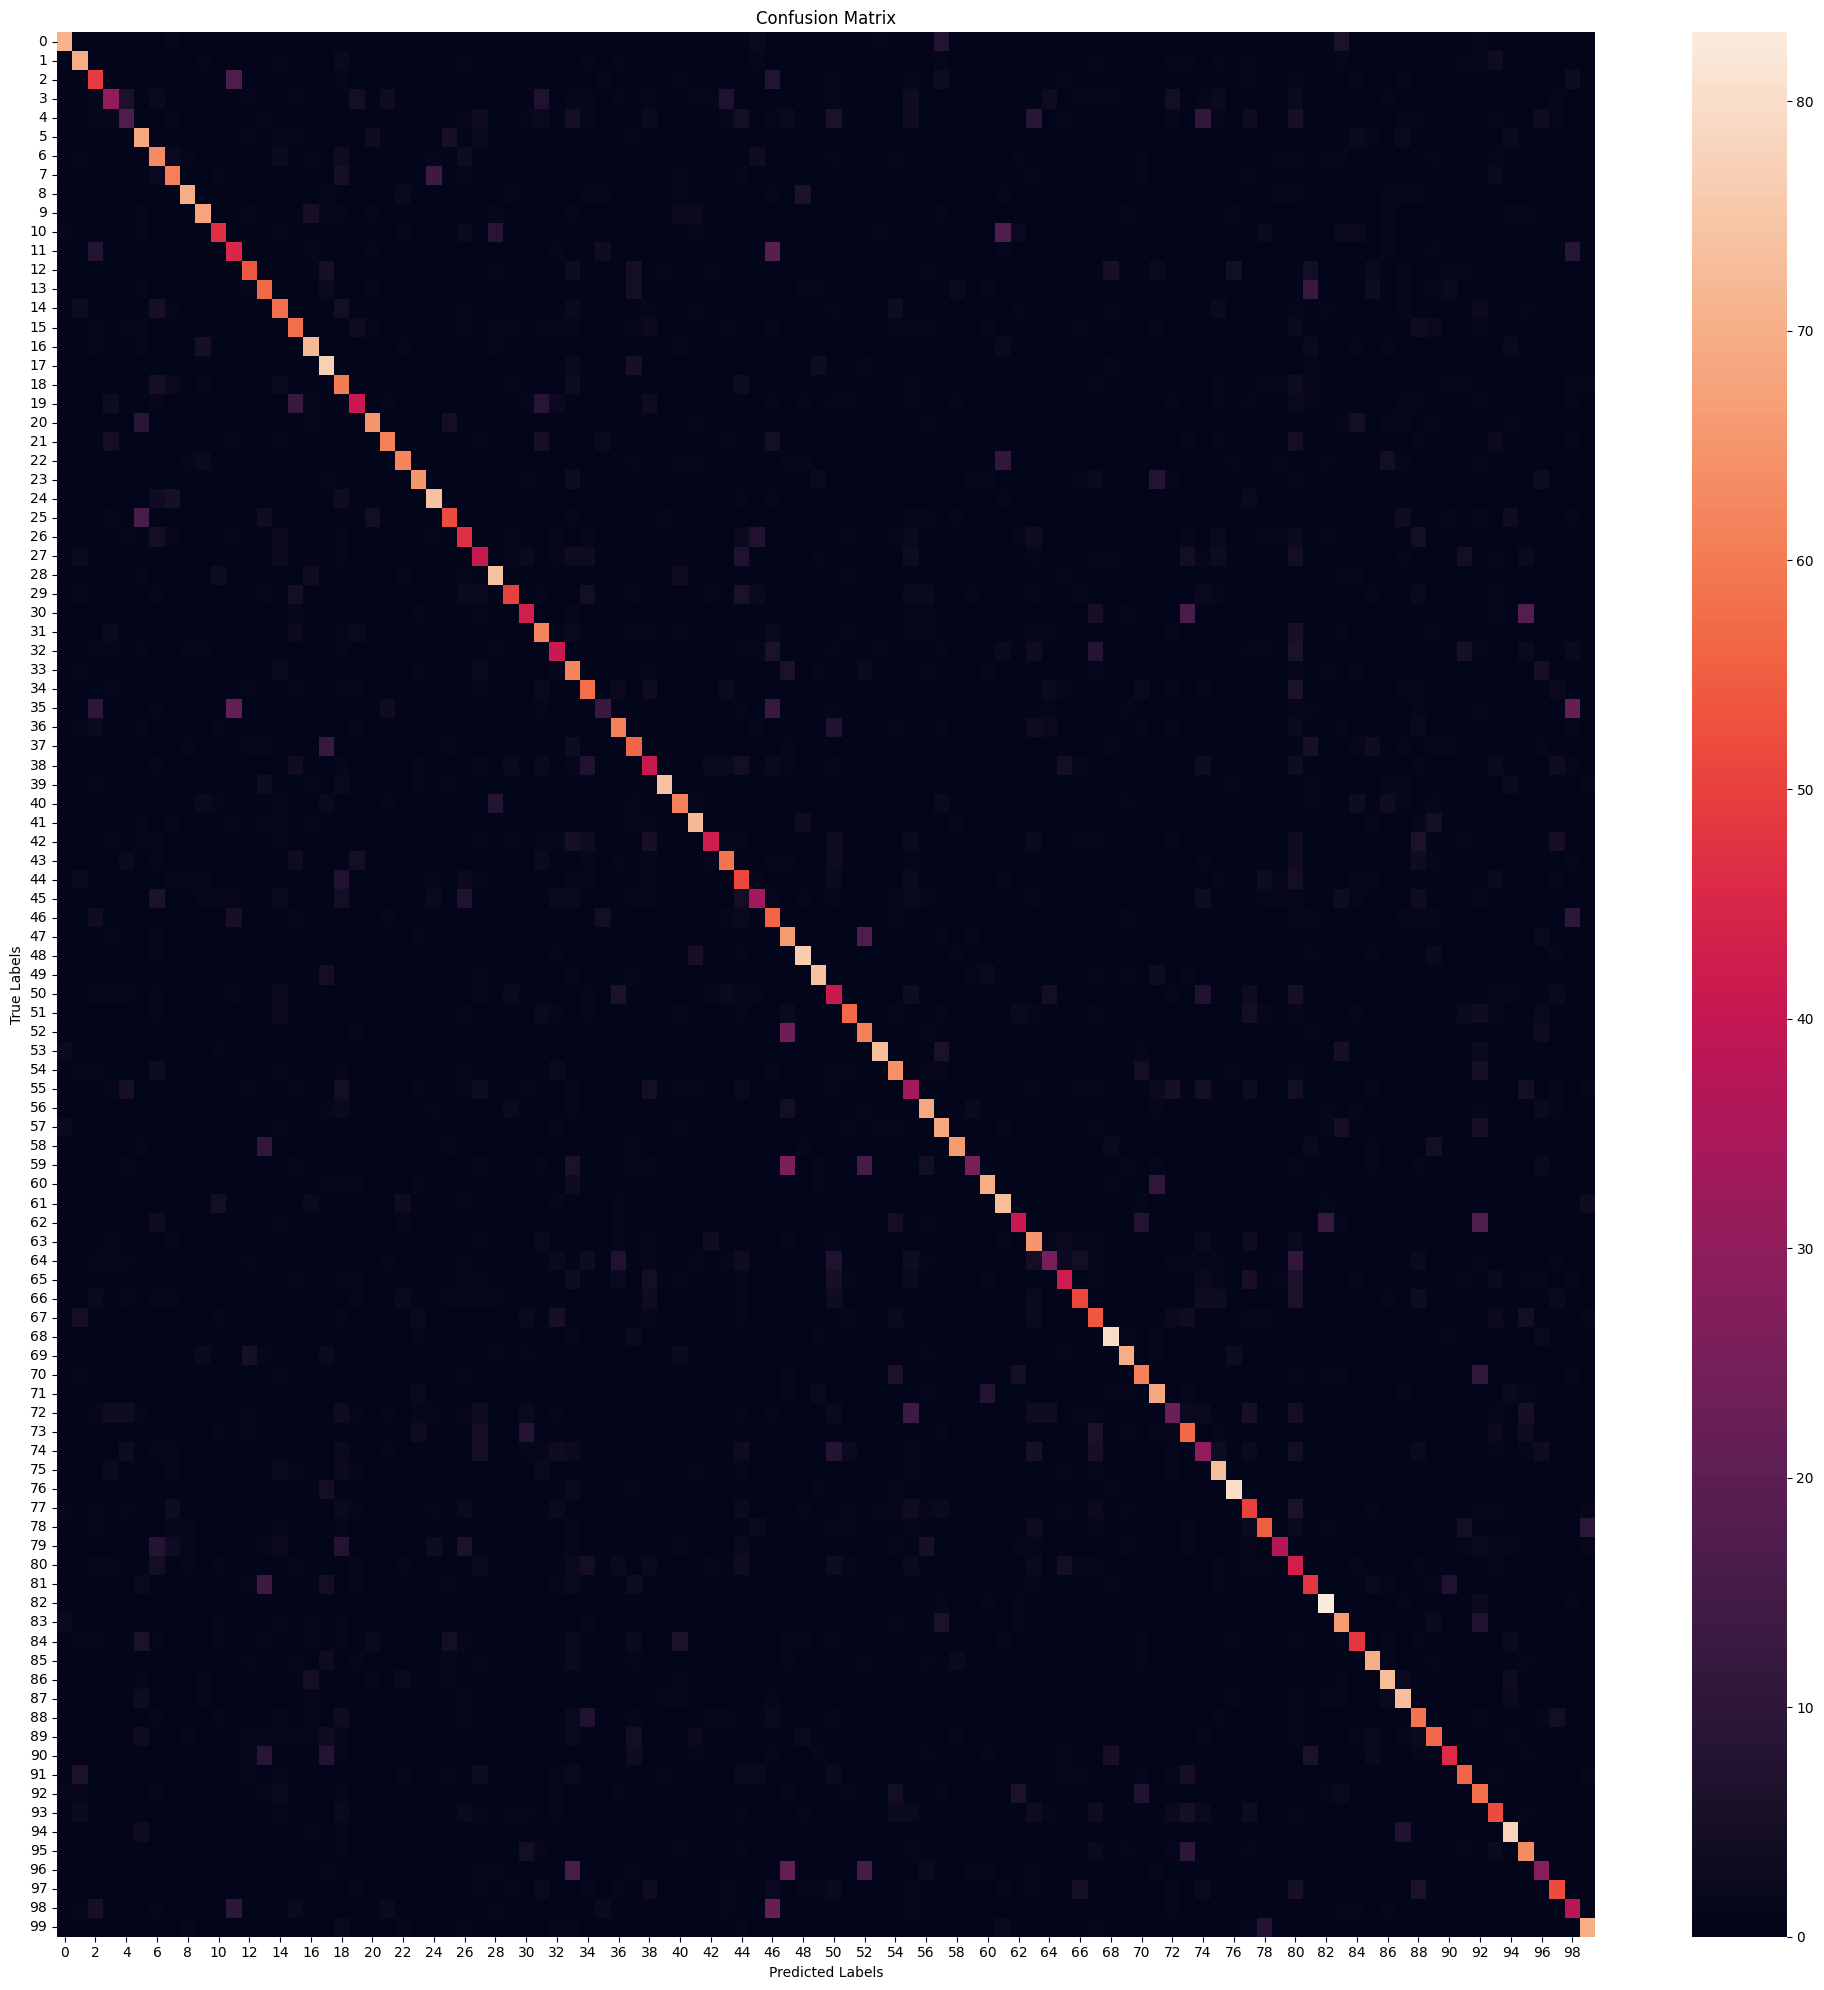

                   precision    recall  f1-score   support

           beaver       0.89      0.79      0.84        90
          dolphin       0.71      0.78      0.74        90
            otter       0.53      0.54      0.54        90
             seal       0.55      0.34      0.42        90
            whale       0.40      0.19      0.26        90
    aquarium fish       0.56      0.77      0.64        90
         flatfish       0.51      0.70      0.59        90
              ray       0.70      0.68      0.69        90
            shark       0.88      0.78      0.82        90
            trout       0.79      0.76      0.77        90
          orchids       0.72      0.52      0.61        90
          poppies       0.44      0.50      0.47        90
            roses       0.73      0.60      0.66        90
       sunflowers       0.54      0.63      0.58        90
           tulips       0.60      0.64      0.62        90
          bottles       0.60      0.64      0.62       

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5917 - f1_score: 0.5879 - loss: 1.4286 - precision: 0.7876
Epoch 1: val_loss improved from inf to 1.25412, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - accuracy: 0.5917 - f1_score: 0.5879 - loss: 1.4286 - precision: 0.7876 - val_accuracy: 0.6451 - val_f1_score: 0.6425 - val_loss: 1.2541 - val_precision: 0.8280
Epoch 2/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6153 - f1_score: 0.6122 - loss: 1.3337 - precision: 0.8018
Epoch 2: val_loss improved from 1.25412 to 1.24230, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.6154 - f1_score: 0.6122 - loss: 1.3337 - precision: 0.8018 - val_accuracy: 0.6487 - val_f1_score: 0.6463 - val_loss: 1.2423 - val_precision: 0.8266
Epoch 3/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6225 - f1_score: 0.6196 - loss: 1.2997 - precision: 0.8084
Epoch 3: v

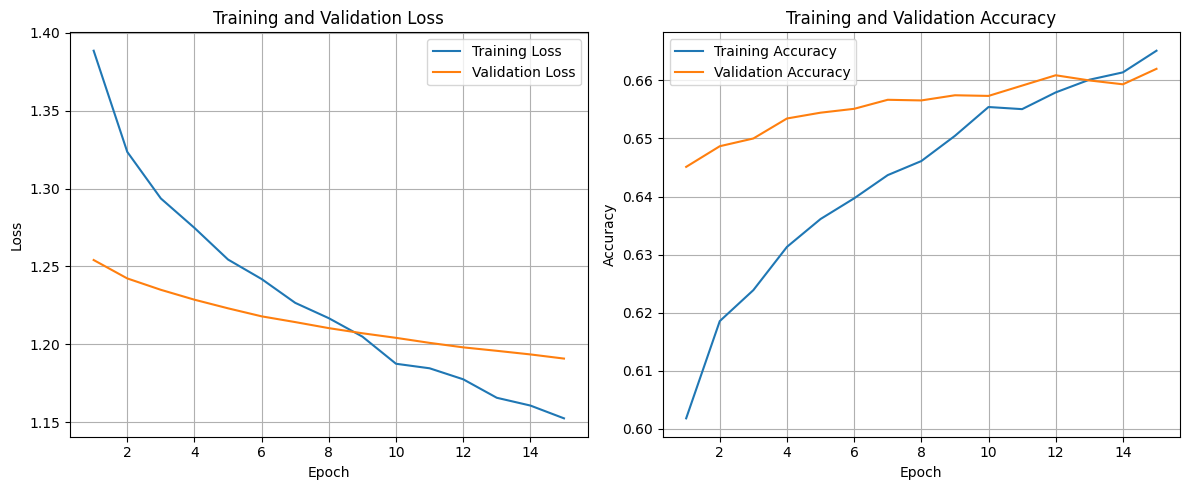

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6466 - f1_score: 0.6388 - loss: 1.2127 - precision: 0.8229
Test Accuracy: 65.84%
Test Loss: 1.1833933591842651
Test Precision: 83.34%
Test F1 Scores (Per Class): [82.68156  77.48691  53.68421  49.999992 39.106144 66.28571  62.745094
 70.93022  83.04093  79.09604  65.16853  50.28571  65.92178  62.499992
 66.26506  59.21787  78.12499  74.747475 57.731956 55.421684 81.08108
 78.49462  81.56424  80.446915 82.41757  68.604645 51.461983 48.84792
 79.09604  66.666664 63.276833 68.181816 53.416145 58.252422 68.1081
 34.319523 68.15642  61.202175 56.140347 89.534874 65.957436 82.02247
 58.56353  70.11494  52.910053 47.953213 49.438198 51.572315 82.90154
 84.74575  35.89743  73.56321  66.33662  87.77777  67.33668  32.584263
 78.82352  74.19354  80.722885 56.969696 79.09604  71.50838  65.968575
 67.42856  42.94478  59.64912  58.064507 61.452507 86.63101  83.422455
 66.666664 73.40425  38.787876 61.702126 38.043476 78.947365 86.666664
 55.68

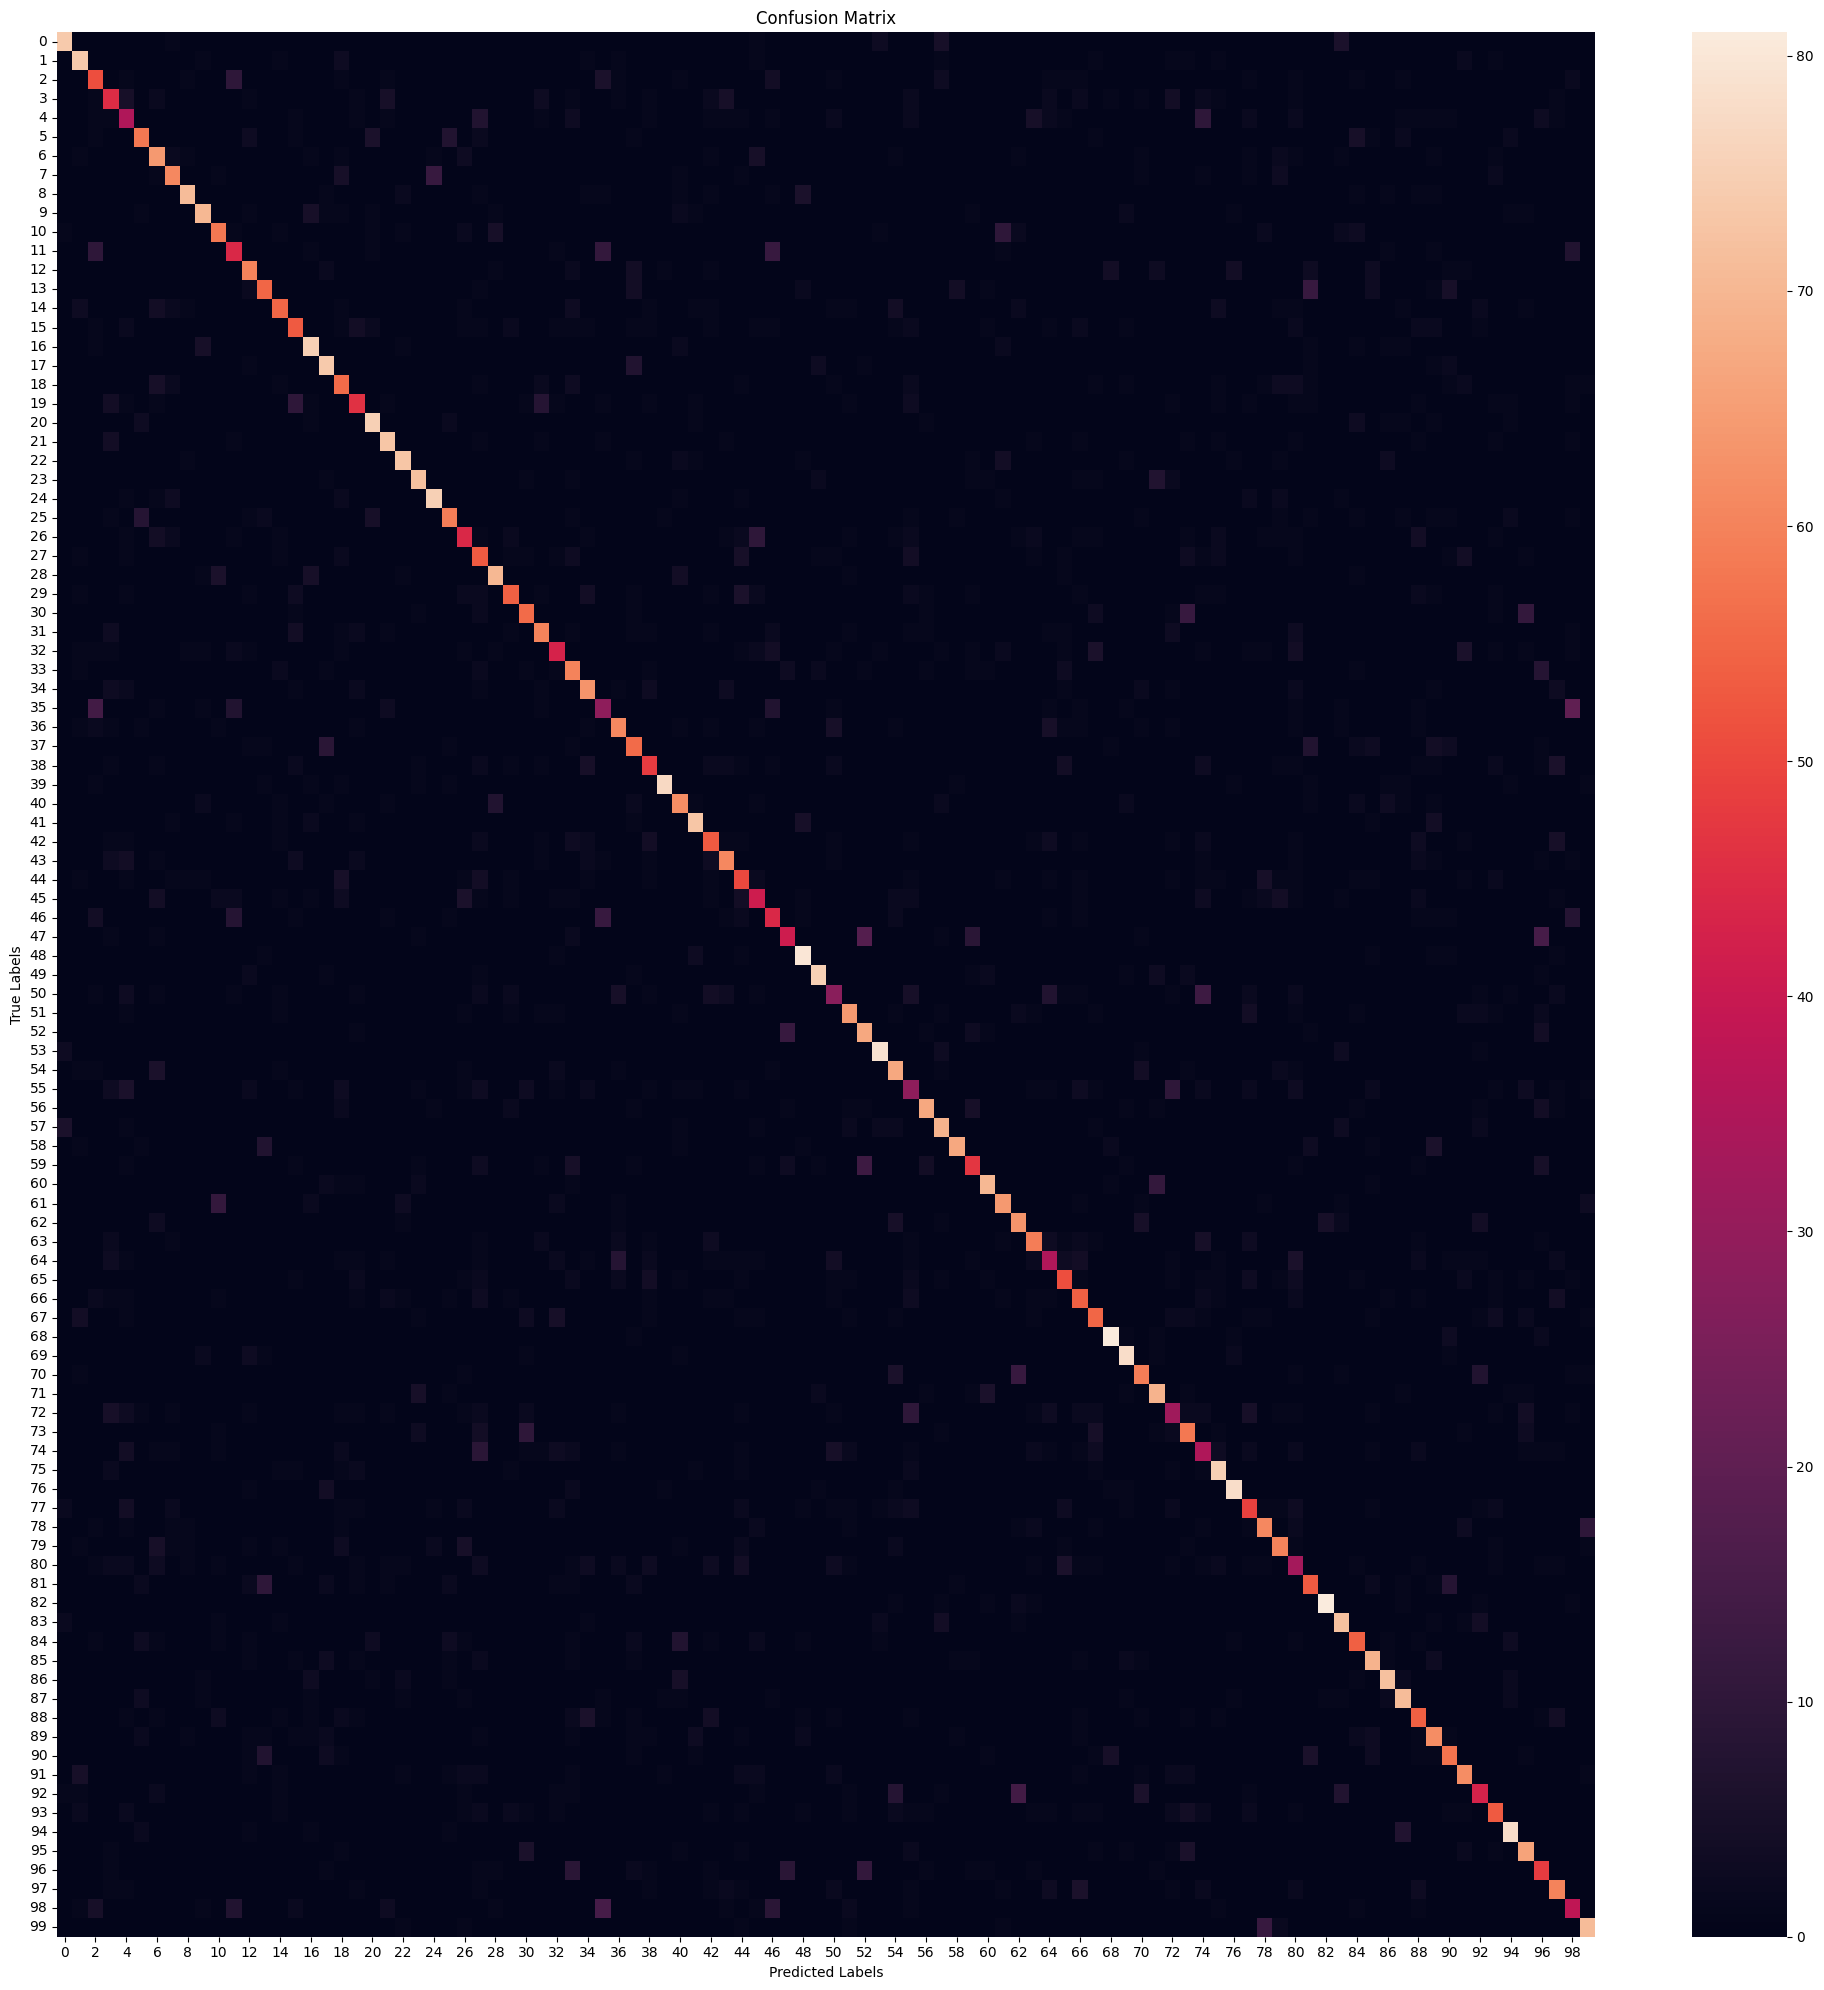

                   precision    recall  f1-score   support

           beaver       0.83      0.82      0.83        90
          dolphin       0.73      0.82      0.77        90
            otter       0.51      0.57      0.54        90
             seal       0.50      0.50      0.50        90
            whale       0.39      0.39      0.39        90
    aquarium fish       0.68      0.64      0.66        90
         flatfish       0.57      0.71      0.63        90
              ray       0.74      0.68      0.71        90
            shark       0.88      0.79      0.83        90
            trout       0.80      0.78      0.79        90
          orchids       0.66      0.64      0.65        90
          poppies       0.52      0.49      0.50        90
            roses       0.67      0.67      0.67        90
       sunflowers       0.64      0.61      0.62        90
           tulips       0.72      0.61      0.66        90
          bottles       0.60      0.59      0.59       

In [5]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-1) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.7), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-1), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v3.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v3.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.8), weight_decay(0.9), l2(0.9)

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[30859].shape: (1,)
imgs[30859].shape: (32, 32, 3)


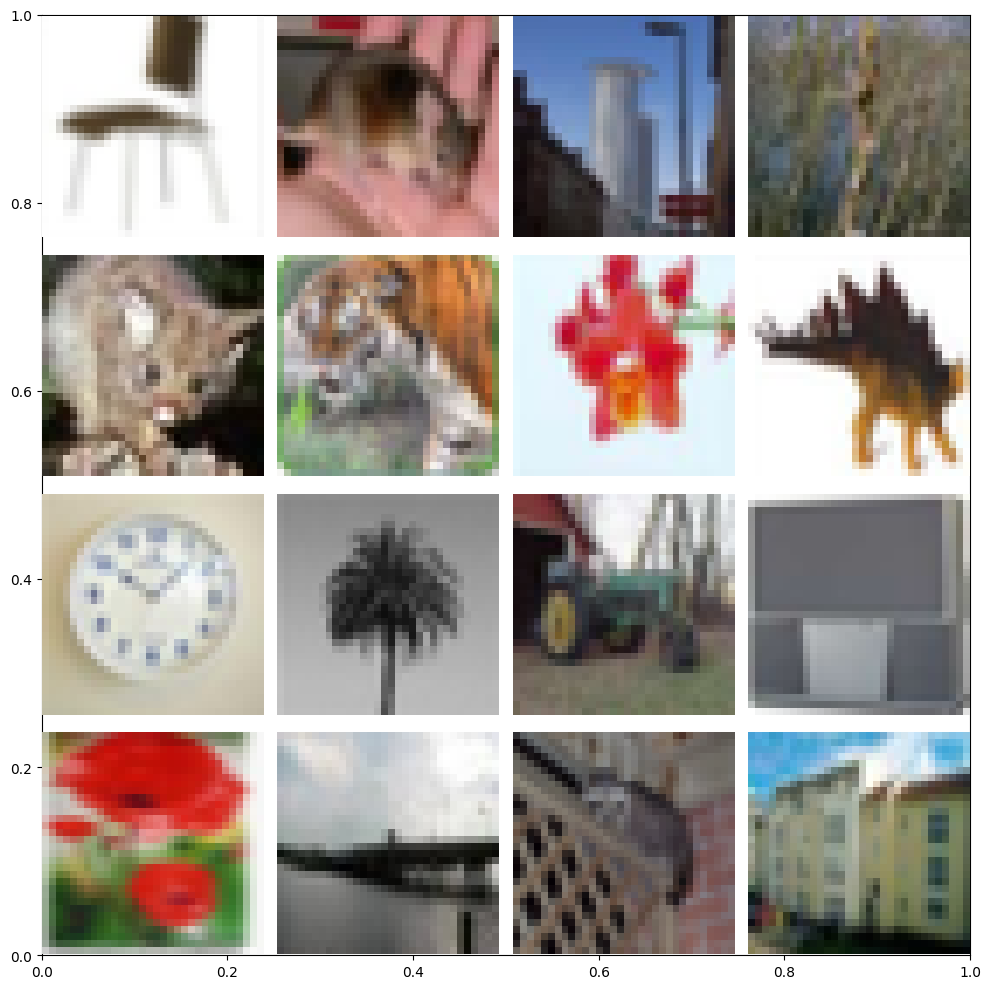

labels[37842].shape: (1,)
imgs[37842].shape: (32, 32, 3)


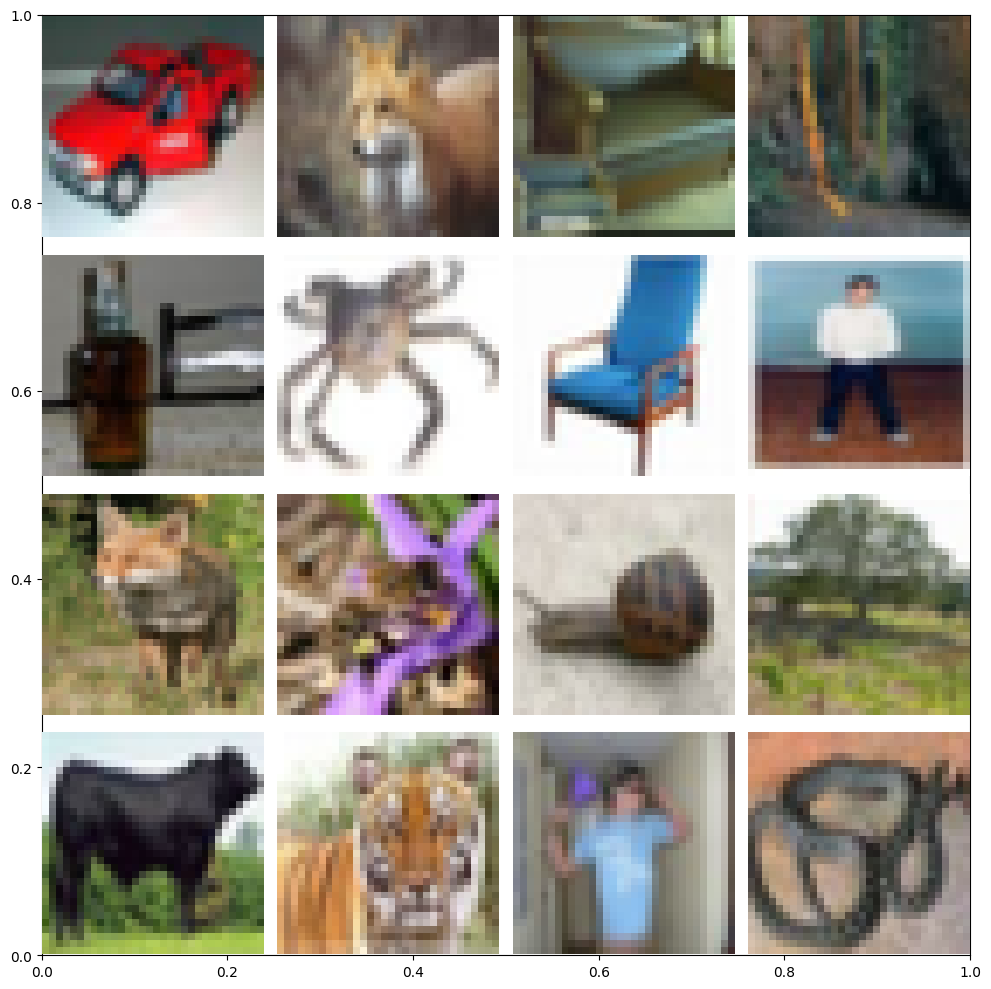

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


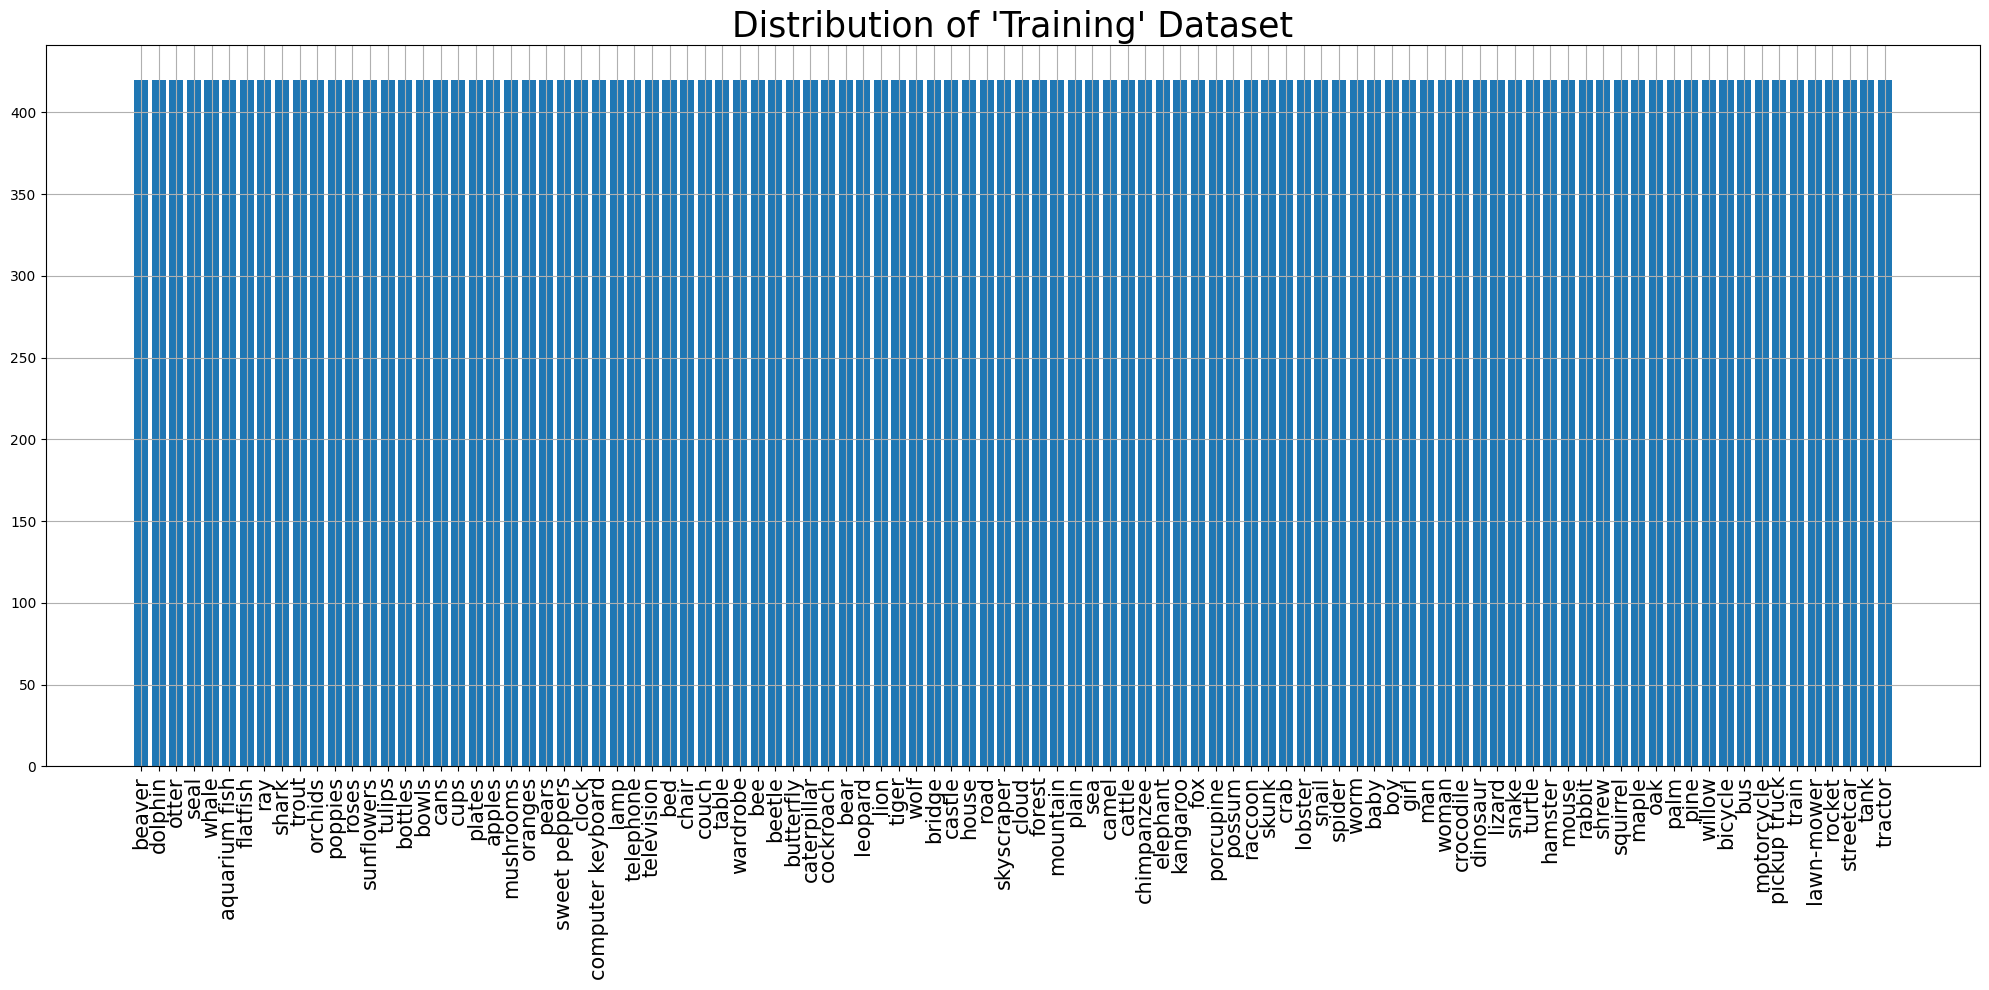

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


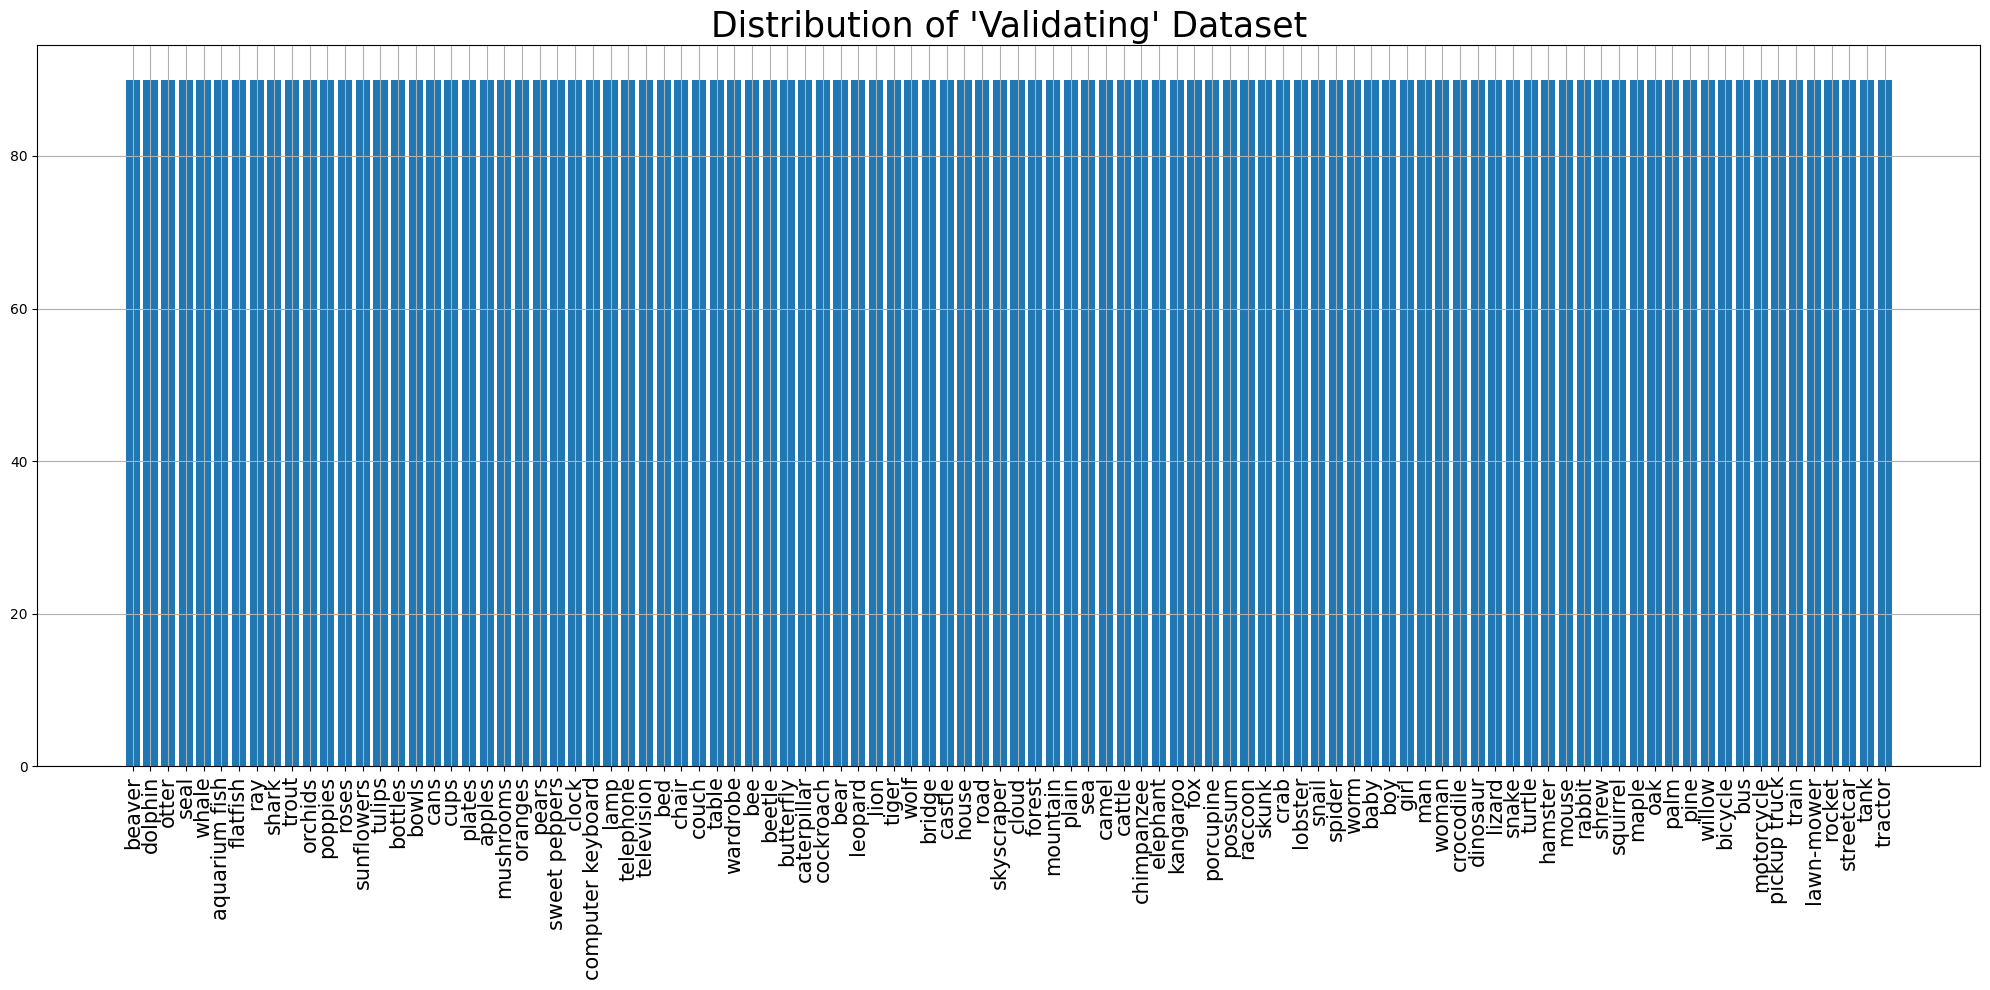

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


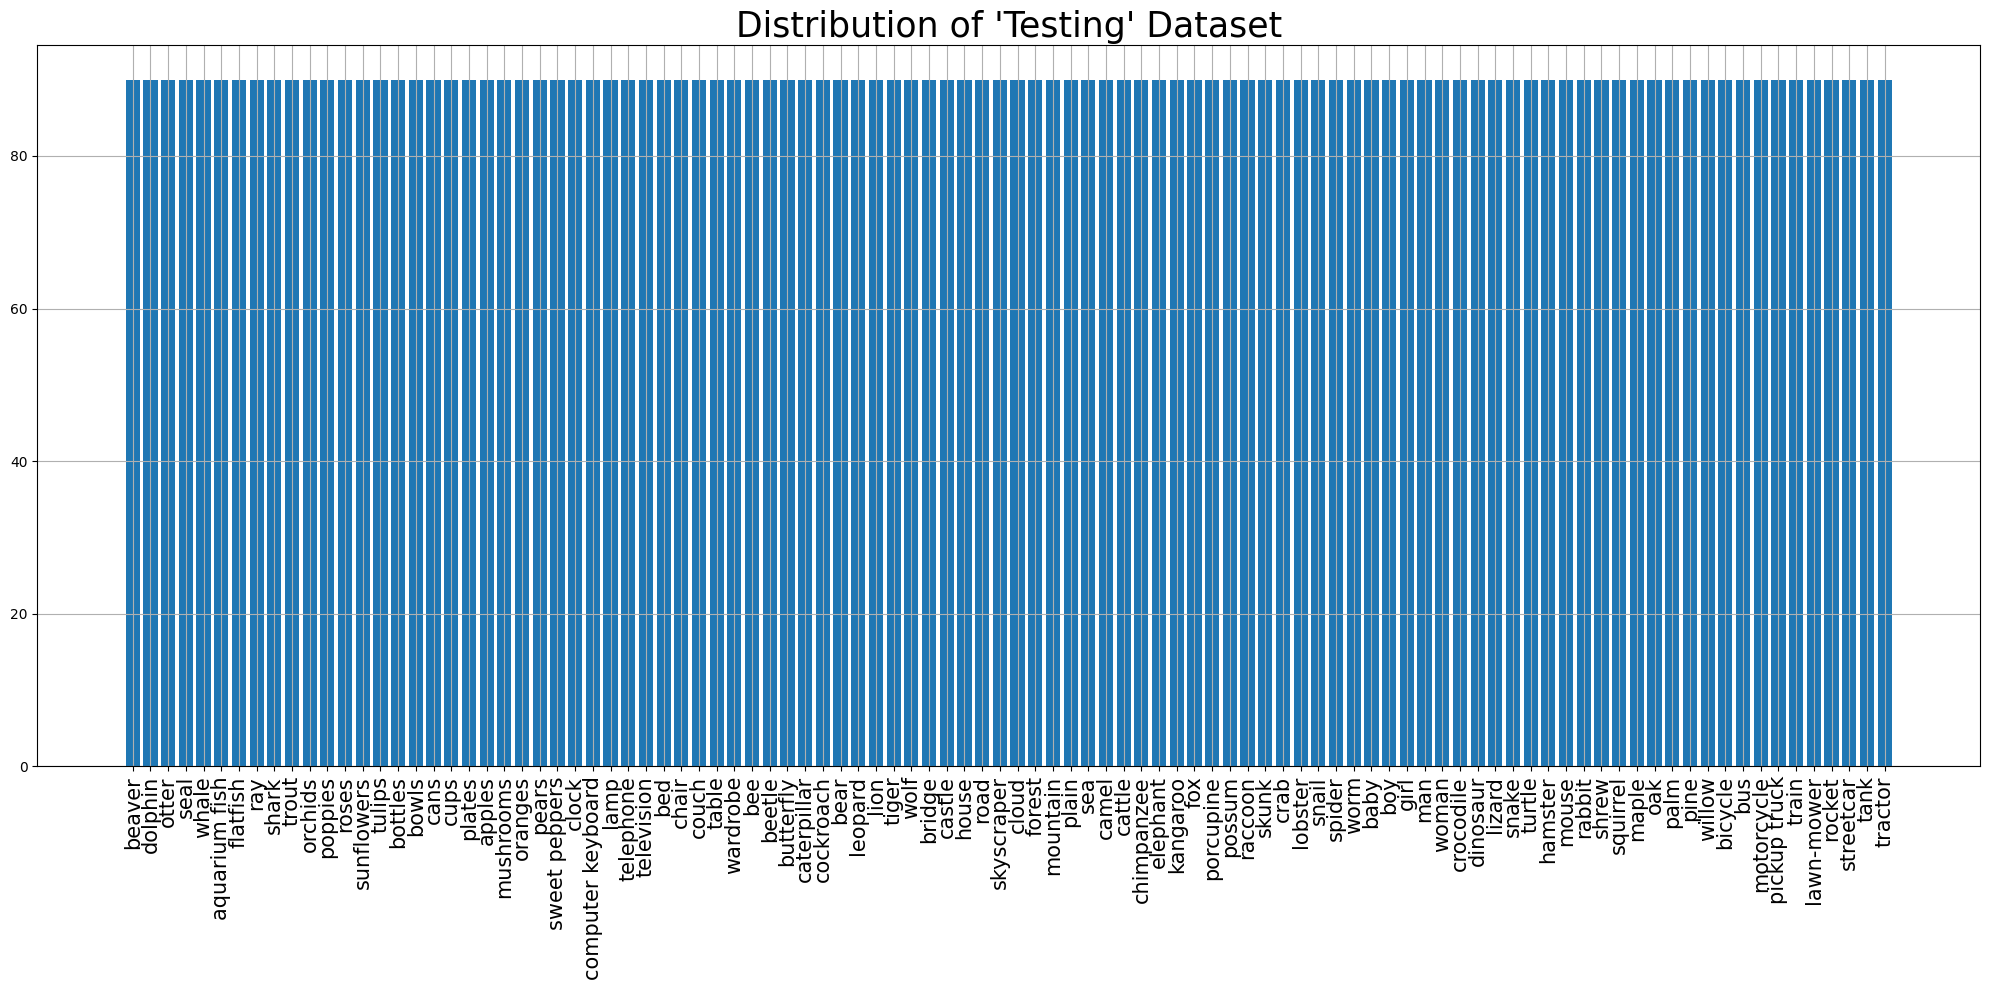

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1877 - f1_score: 0.1795 - loss: 3.6425 - precision: 0.5631
Epoch 1: val_loss improved from inf to 1.78734, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.1879 - f1_score: 0.1797 - loss: 3.6415 - precision: 0.5633 - val_accuracy: 0.5410 - val_f1_score: 0.5302 - val_loss: 1.7873 - val_precision: 0.8693
Epoch 2/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3897 - f1_score: 0.3820 - loss: 2.3149 - precision: 0.7015
Epoch 2: val_loss improved from 1.78734 to 1.67195, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.3897 - f1_score: 0.3820 - loss: 2.3147 - precision: 0.7015 - val_accuracy: 0.5587 - val_f1_score: 0.5491 - val_loss: 1.6719 - val_precision: 0.8618
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4152 - f1_score: 0.4072 - loss: 2.1740 - precision: 0.7186
Epoch 3: val_loss improved from 1.67195 

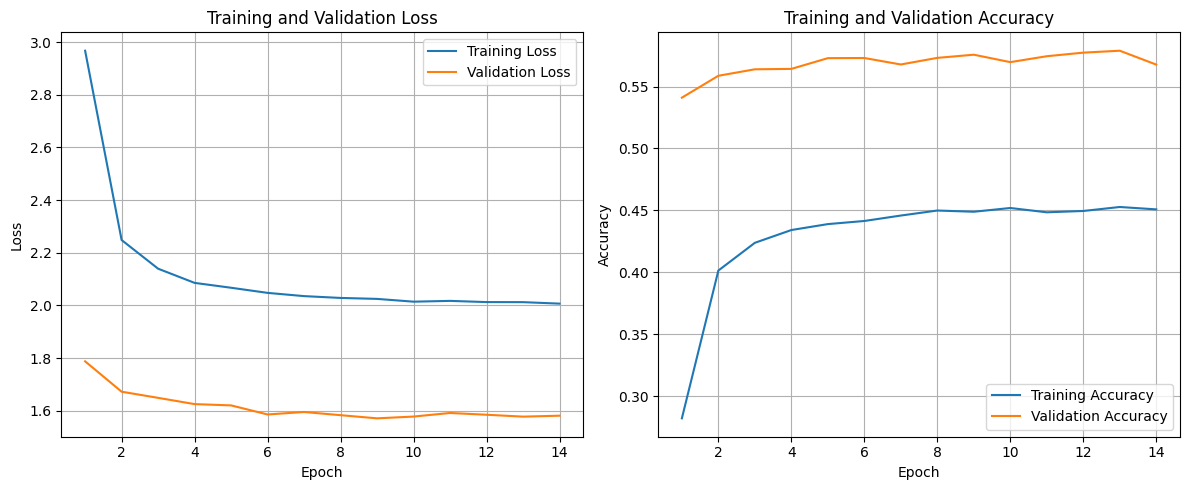

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5628 - f1_score: 0.5499 - loss: 1.5834 - precision: 0.8503
Test Accuracy: 57.27%
Test Loss: 1.5580322742462158
Test Precision: 86.16%
Test F1 Scores (Per Class): [80.24691   72.625694  54.08804   27.199995  28.776974  55.27637
 49.606293  58.510624  77.10842   81.81818   59.999996  45.71428
 61.538452  49.137924  62.33766   47.111107  73.224045  57.564575
 51.396645  52.702694  76.756744  72.98578   77.38094   71.428566
 70.15707   58.24175   42.051273  27.672949  72.99999   59.016384
 32.061066  67.05882   34.567894  40.776695  61.290314   4.1237106
 67.46988   33.33333   38.94736   85.        60.689648  80.
 52.307682  62.264145  48.958324  30.534348  45.814972  48.249023
 72.46376   78.57143   34.693874  64.44444   50.86206   81.52173
 56.41025   18.309856  71.33758   64.        66.666664  27.027023
 72.53885   70.243904  55.999992  63.101597  38.32335   36.496346
 56.57894   50.67873   79.61165   74.35896   62.559242  67.7595

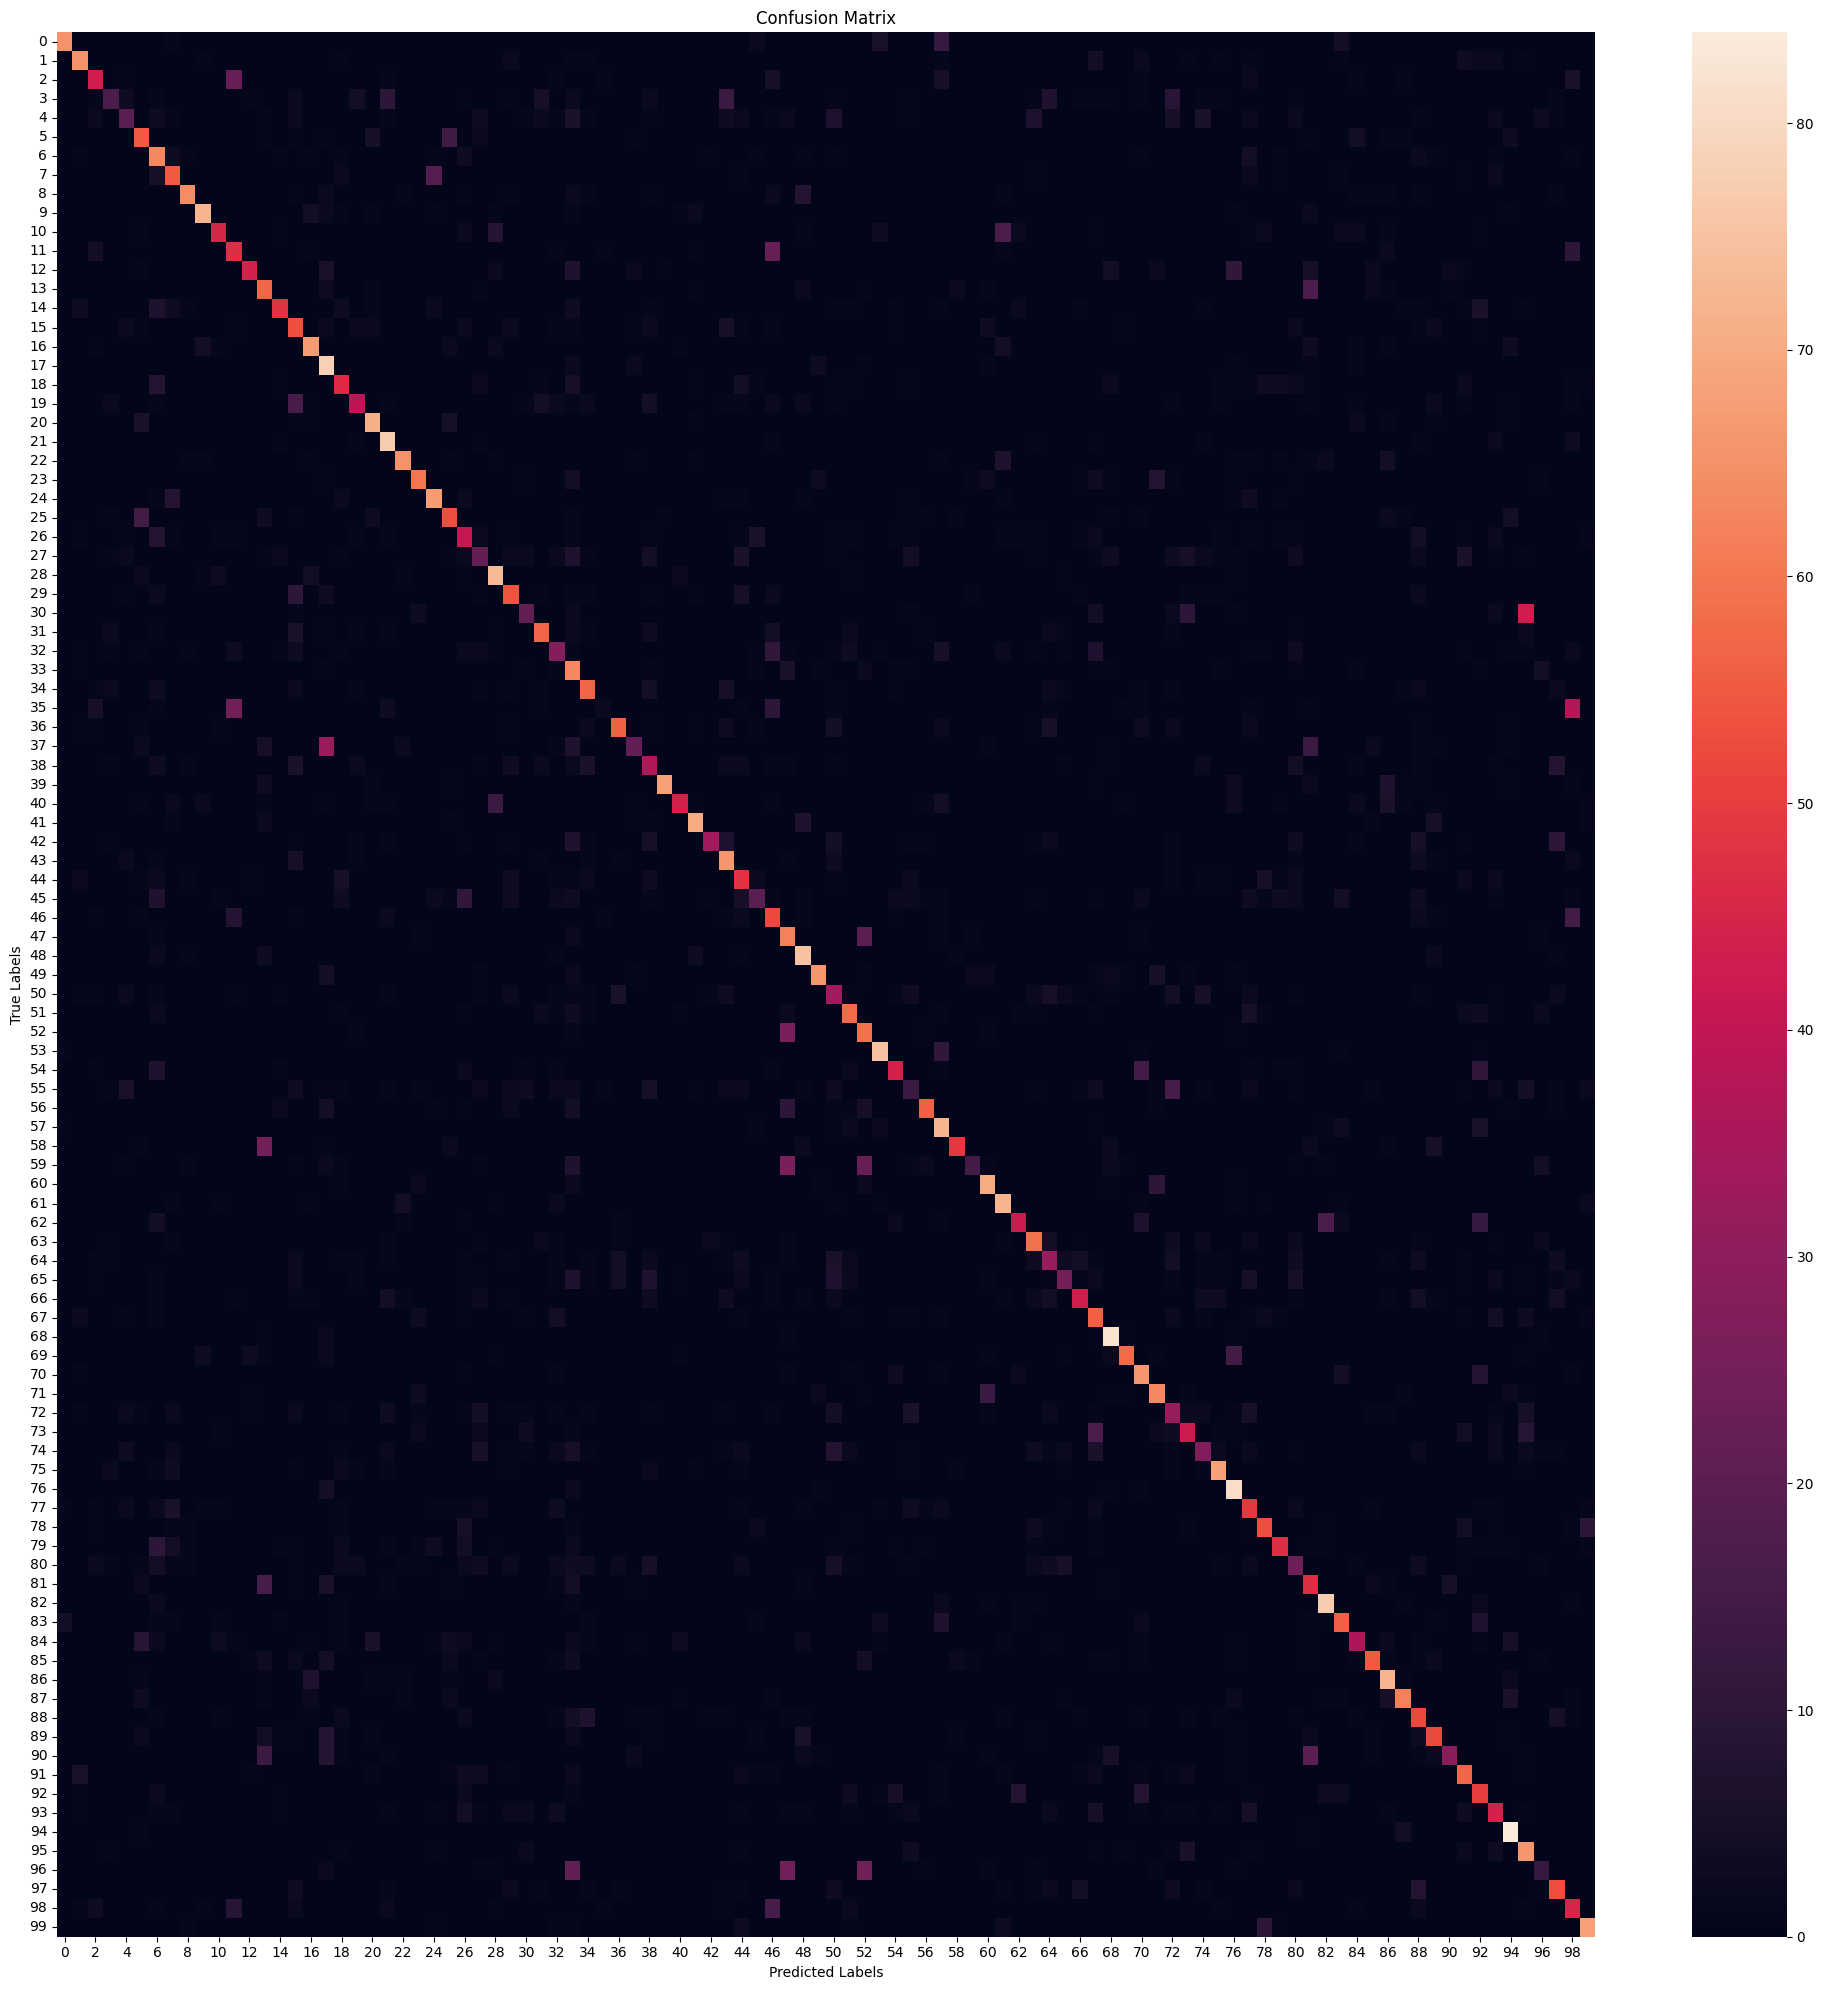

                   precision    recall  f1-score   support

           beaver       0.90      0.72      0.80        90
          dolphin       0.73      0.72      0.73        90
            otter       0.61      0.48      0.54        90
             seal       0.49      0.19      0.27        90
            whale       0.41      0.22      0.29        90
    aquarium fish       0.50      0.61      0.55        90
         flatfish       0.38      0.70      0.50        90
              ray       0.56      0.61      0.59        90
            shark       0.84      0.71      0.77        90
            trout       0.84      0.80      0.82        90
          orchids       0.75      0.50      0.60        90
          poppies       0.40      0.52      0.45        90
            roses       0.83      0.49      0.62        90
       sunflowers       0.40      0.63      0.49        90
           tulips       0.75      0.53      0.62        90
          bottles       0.39      0.59      0.47       

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4699 - f1_score: 0.4628 - loss: 1.9326 - precision: 0.7463
Epoch 1: val_loss improved from inf to 1.48361, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.4700 - f1_score: 0.4628 - loss: 1.9325 - precision: 0.7463 - val_accuracy: 0.5981 - val_f1_score: 0.5924 - val_loss: 1.4836 - val_precision: 0.8636
Epoch 2/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4932 - f1_score: 0.4866 - loss: 1.8242 - precision: 0.7660
Epoch 2: val_loss improved from 1.48361 to 1.46176, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.4932 - f1_score: 0.4866 - loss: 1.8241 - precision: 0.7661 - val_accuracy: 0.6027 - val_f1_score: 0.5981 - val_loss: 1.4618 - val_precision: 0.8602
Epoch 3/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5062 - f1_score: 0.5004 - loss: 1.7914 - precision: 0.7671
Epoch 3: v

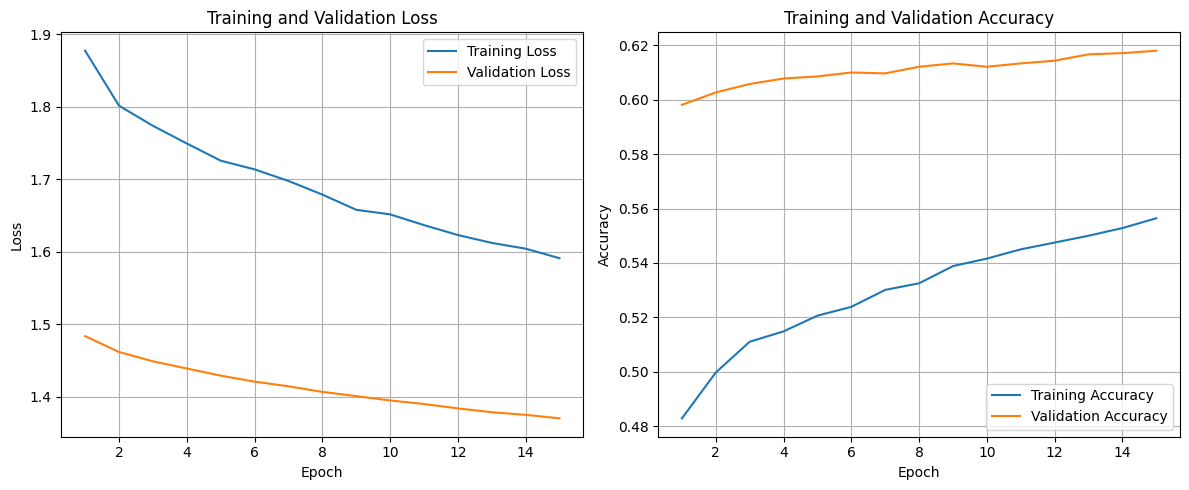

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6112 - f1_score: 0.6020 - loss: 1.3786 - precision: 0.8474
Test Accuracy: 62.29%
Test Loss: 1.3537427186965942
Test Precision: 85.99%
Test F1 Scores (Per Class): [84.44444  72.53885  53.06122  44.31137  34.355824 56.994812 57.894737
 64.088394 79.99999  81.39534  60.67415  48.554905 61.87845  56.818176
 62.427734 55.737698 71.428566 71.87499  57.45856  57.48503  75.82417
 79.38144  77.41935  76.24309  78.07486  64.28571  51.219505 38.81856
 79.31035  60.869564 56.140347 65.49707  46.62576  54.36893  61.956512
 29.447845 67.37968  52.68817  46.92737  88.2353   70.27026  78.260864
 60.33519  67.02702  50.279324 44.31137  50.28571  51.25     73.57513
 80.43478  37.735844 72.31638  60.98654  86.81318  65.346535 31.055897
 73.68421  70.05649  78.82352  51.00671  76.34408  72.04301  61.202175
 61.87845  42.58064  44.444443 58.88888  54.748596 84.946236 82.53968
 64.36781  70.15707  36.708855 57.92349  33.879776 77.48691  84.91619
 56.4

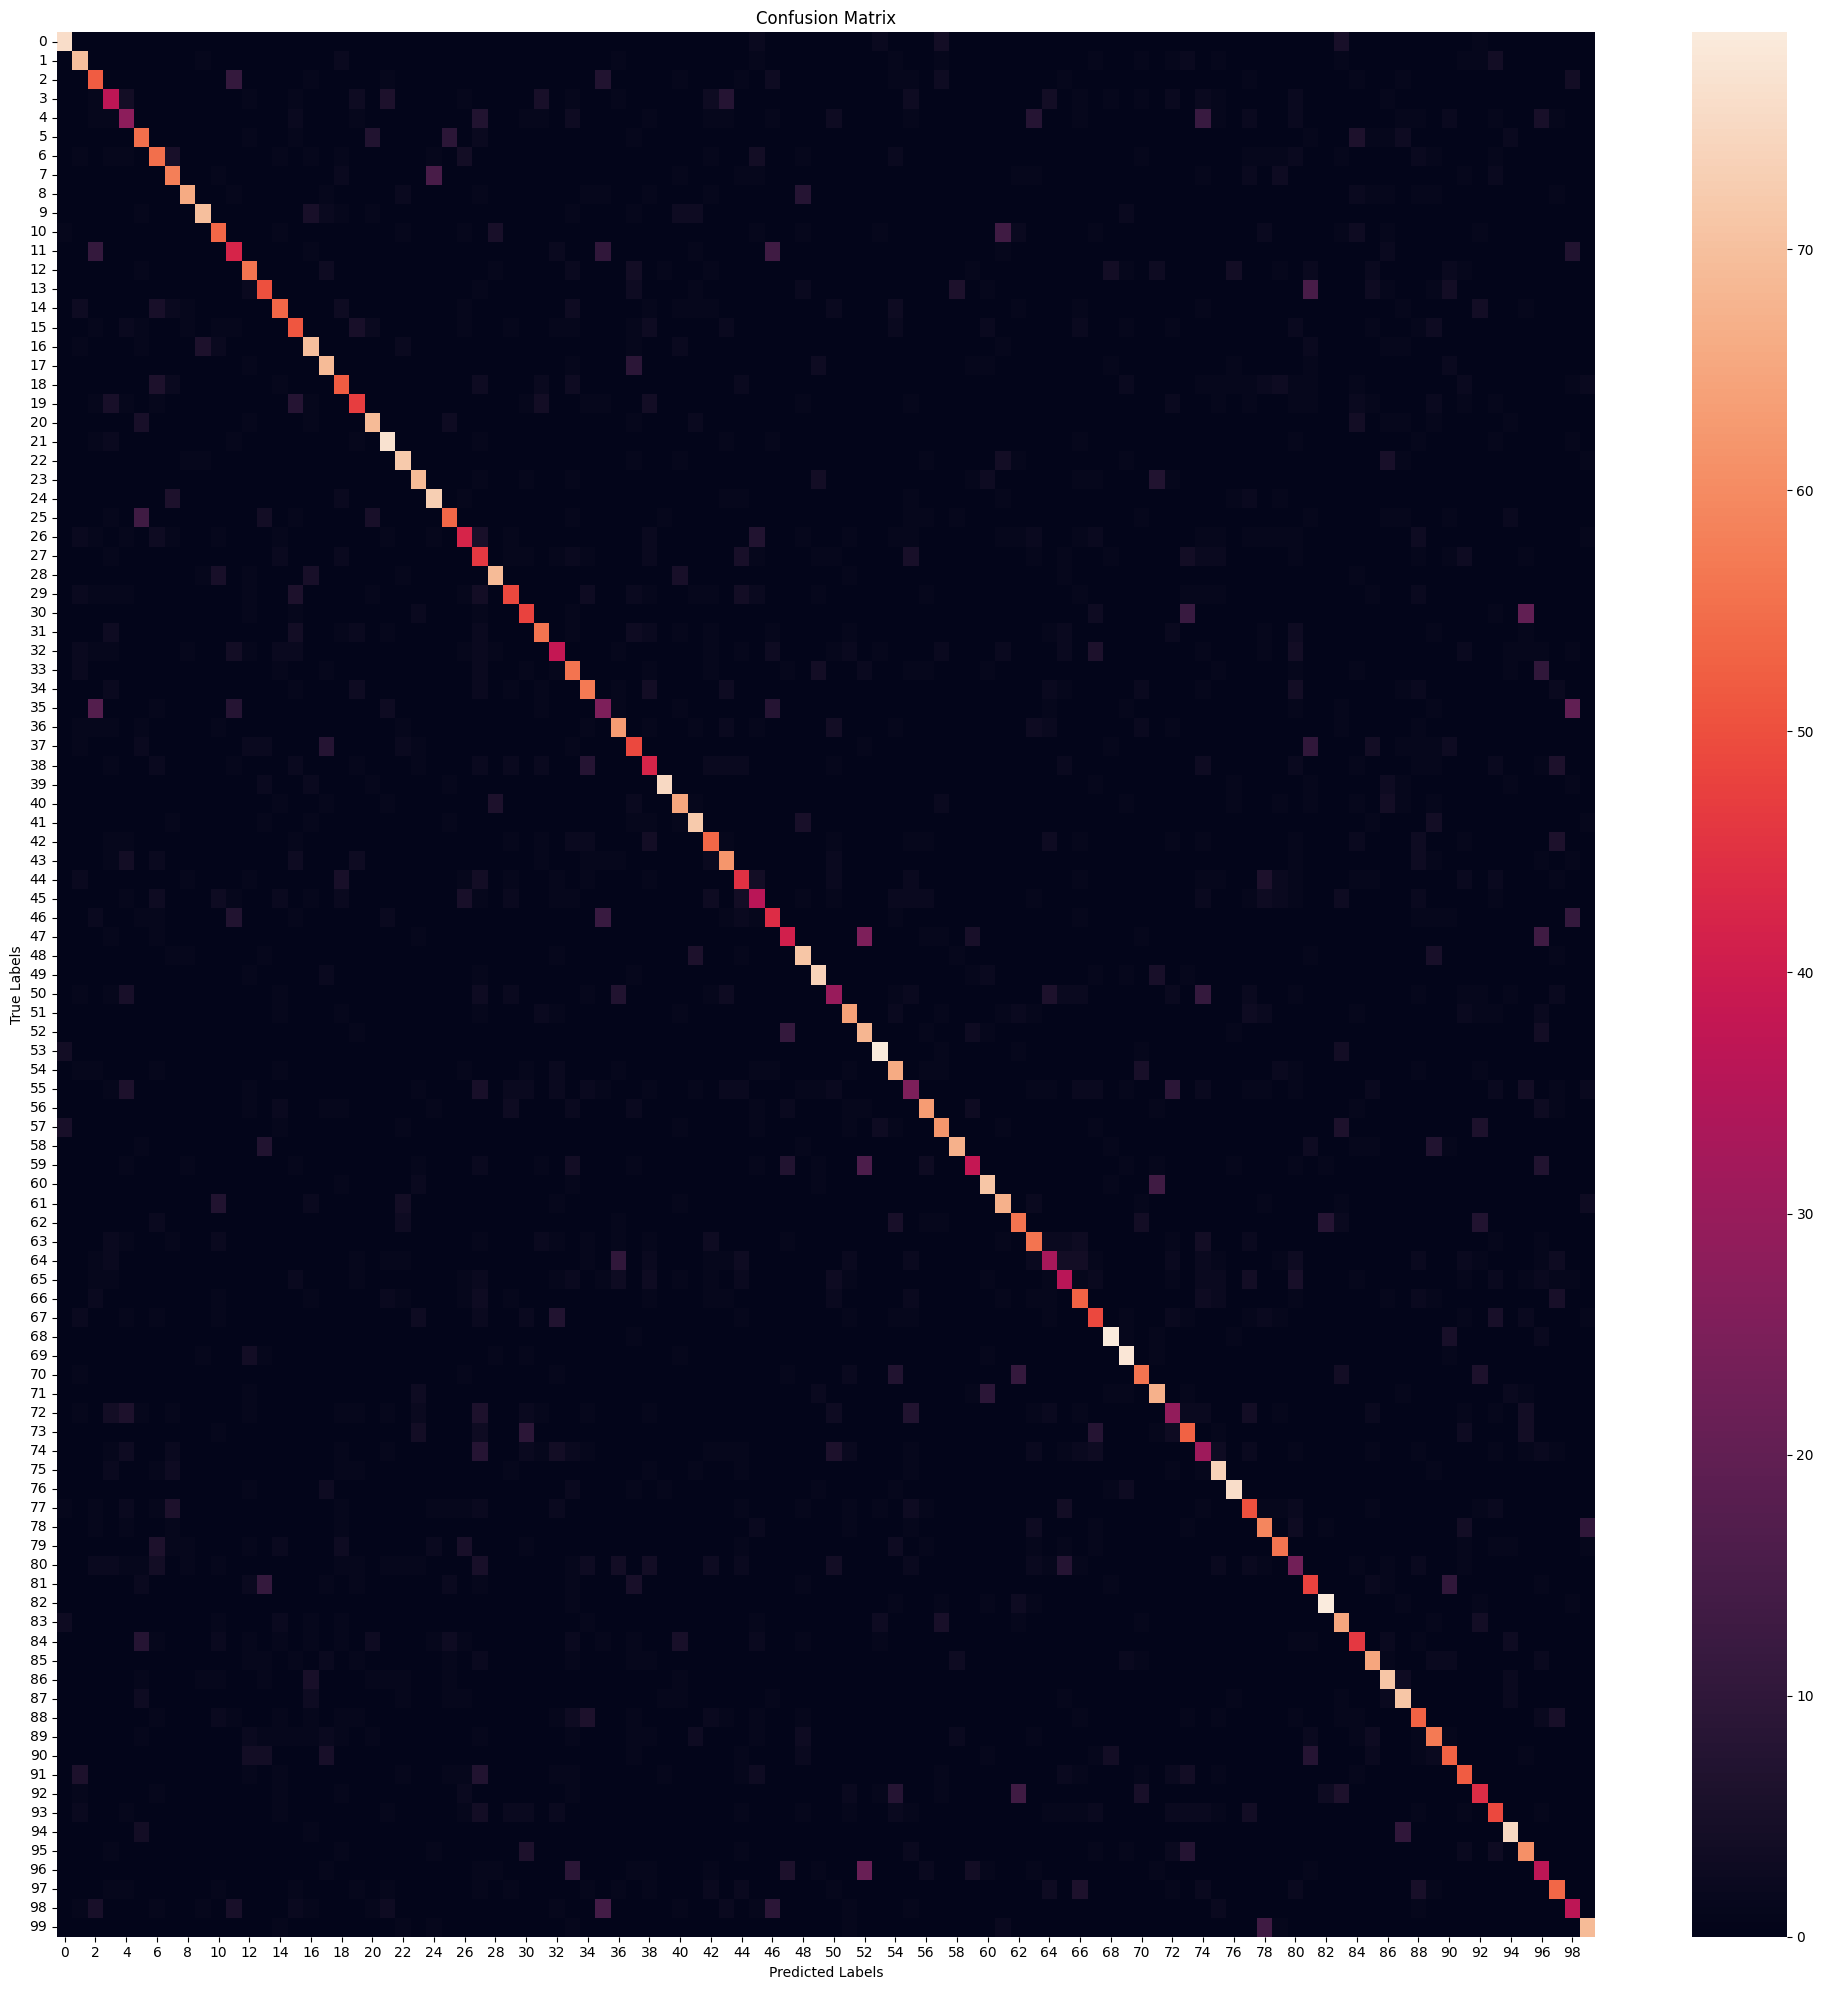

                   precision    recall  f1-score   support

           beaver       0.84      0.84      0.84        90
          dolphin       0.68      0.78      0.73        90
            otter       0.50      0.58      0.53        90
             seal       0.47      0.41      0.44        90
            whale       0.38      0.31      0.34        90
    aquarium fish       0.53      0.61      0.57        90
         flatfish       0.55      0.61      0.58        90
              ray       0.64      0.64      0.64        90
            shark       0.88      0.73      0.80        90
            trout       0.85      0.78      0.81        90
          orchids       0.61      0.60      0.61        90
          poppies       0.51      0.47      0.49        90
            roses       0.62      0.62      0.62        90
       sunflowers       0.58      0.56      0.57        90
           tulips       0.65      0.60      0.62        90
          bottles       0.55      0.57      0.56       

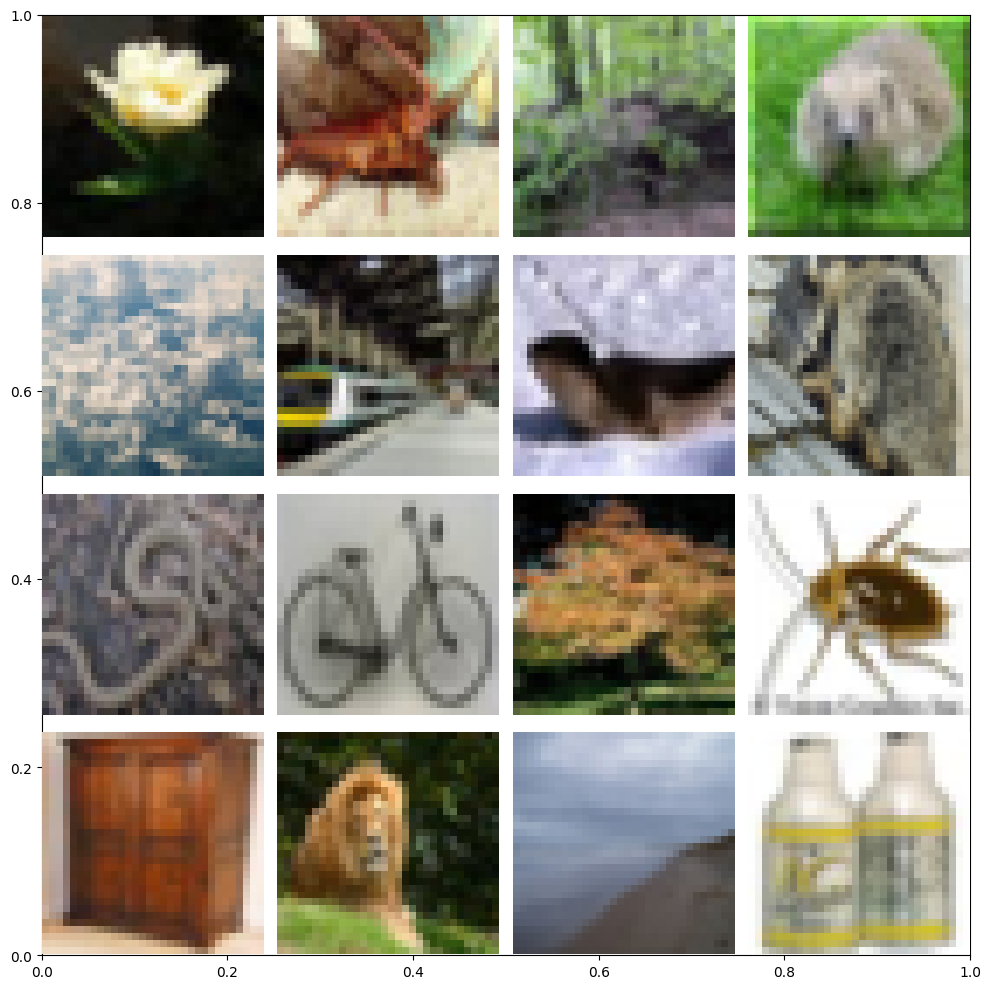

labels[787].shape: (1,)
imgs[787].shape: (32, 32, 3)


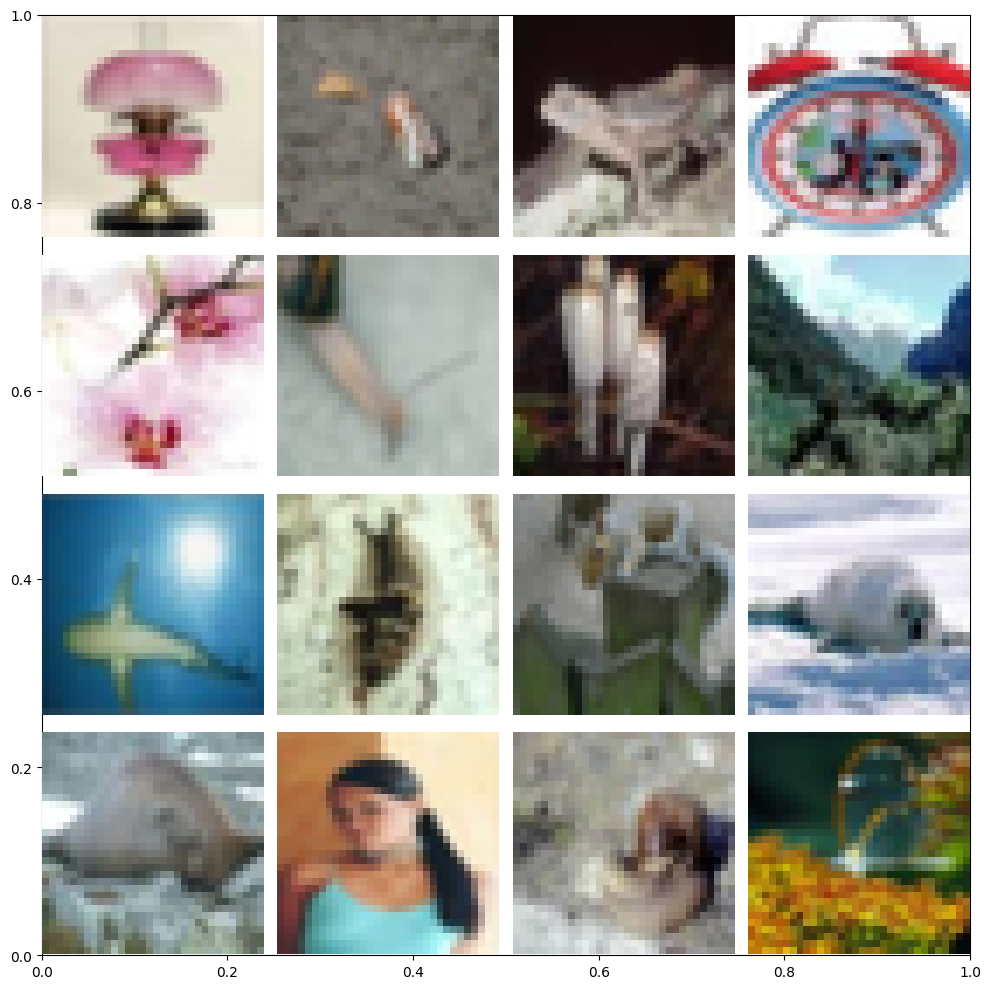

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


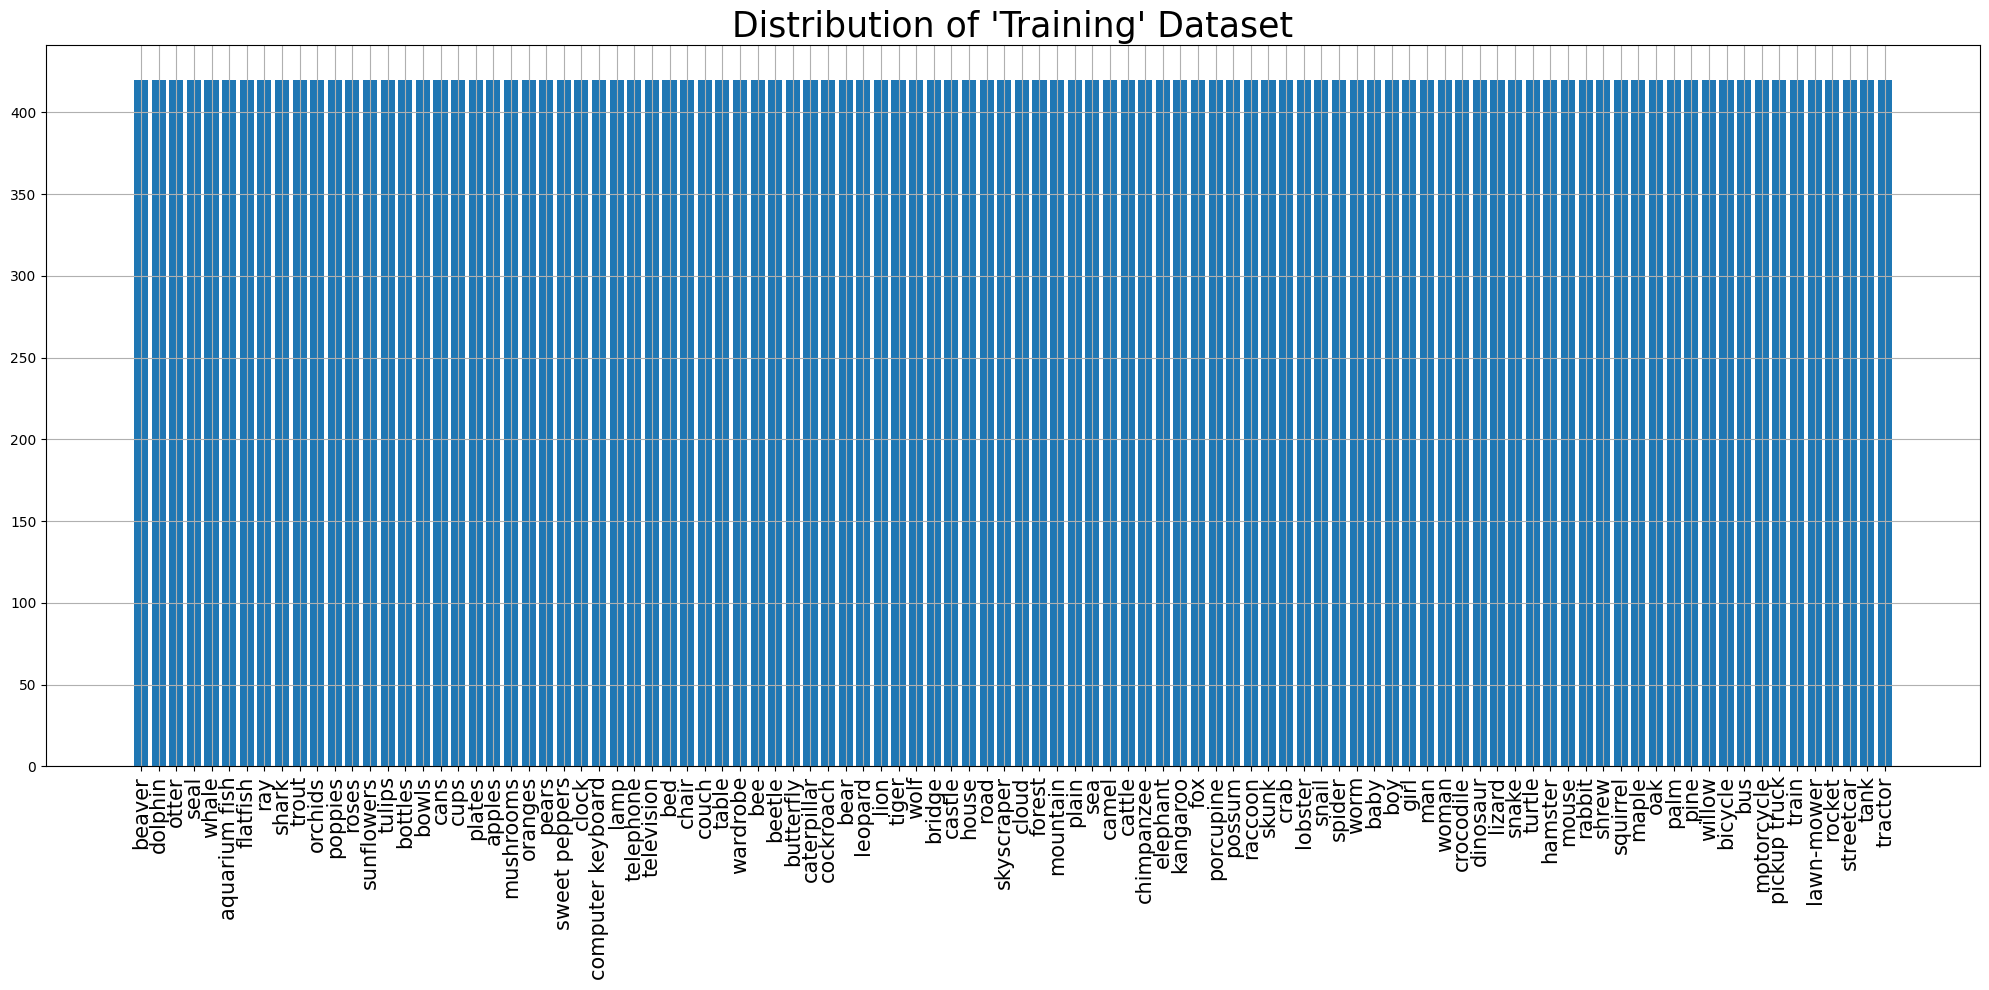

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


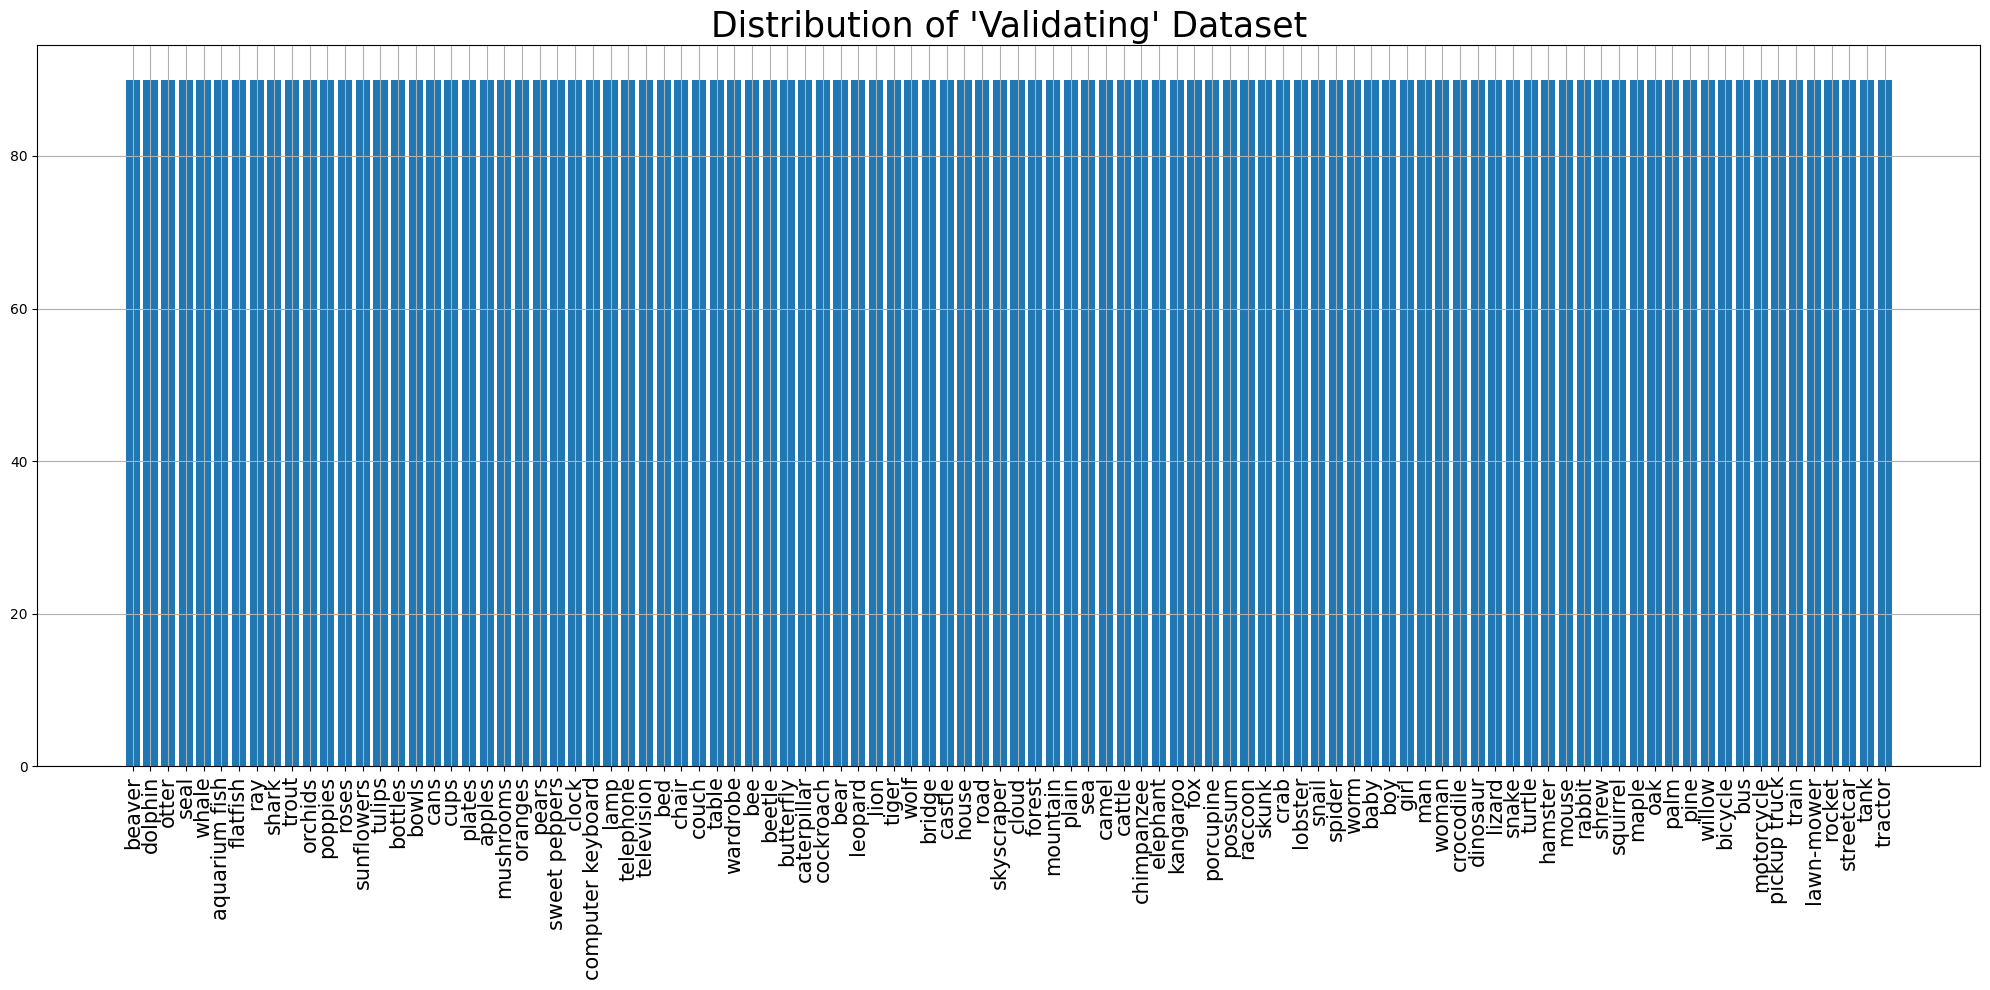

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


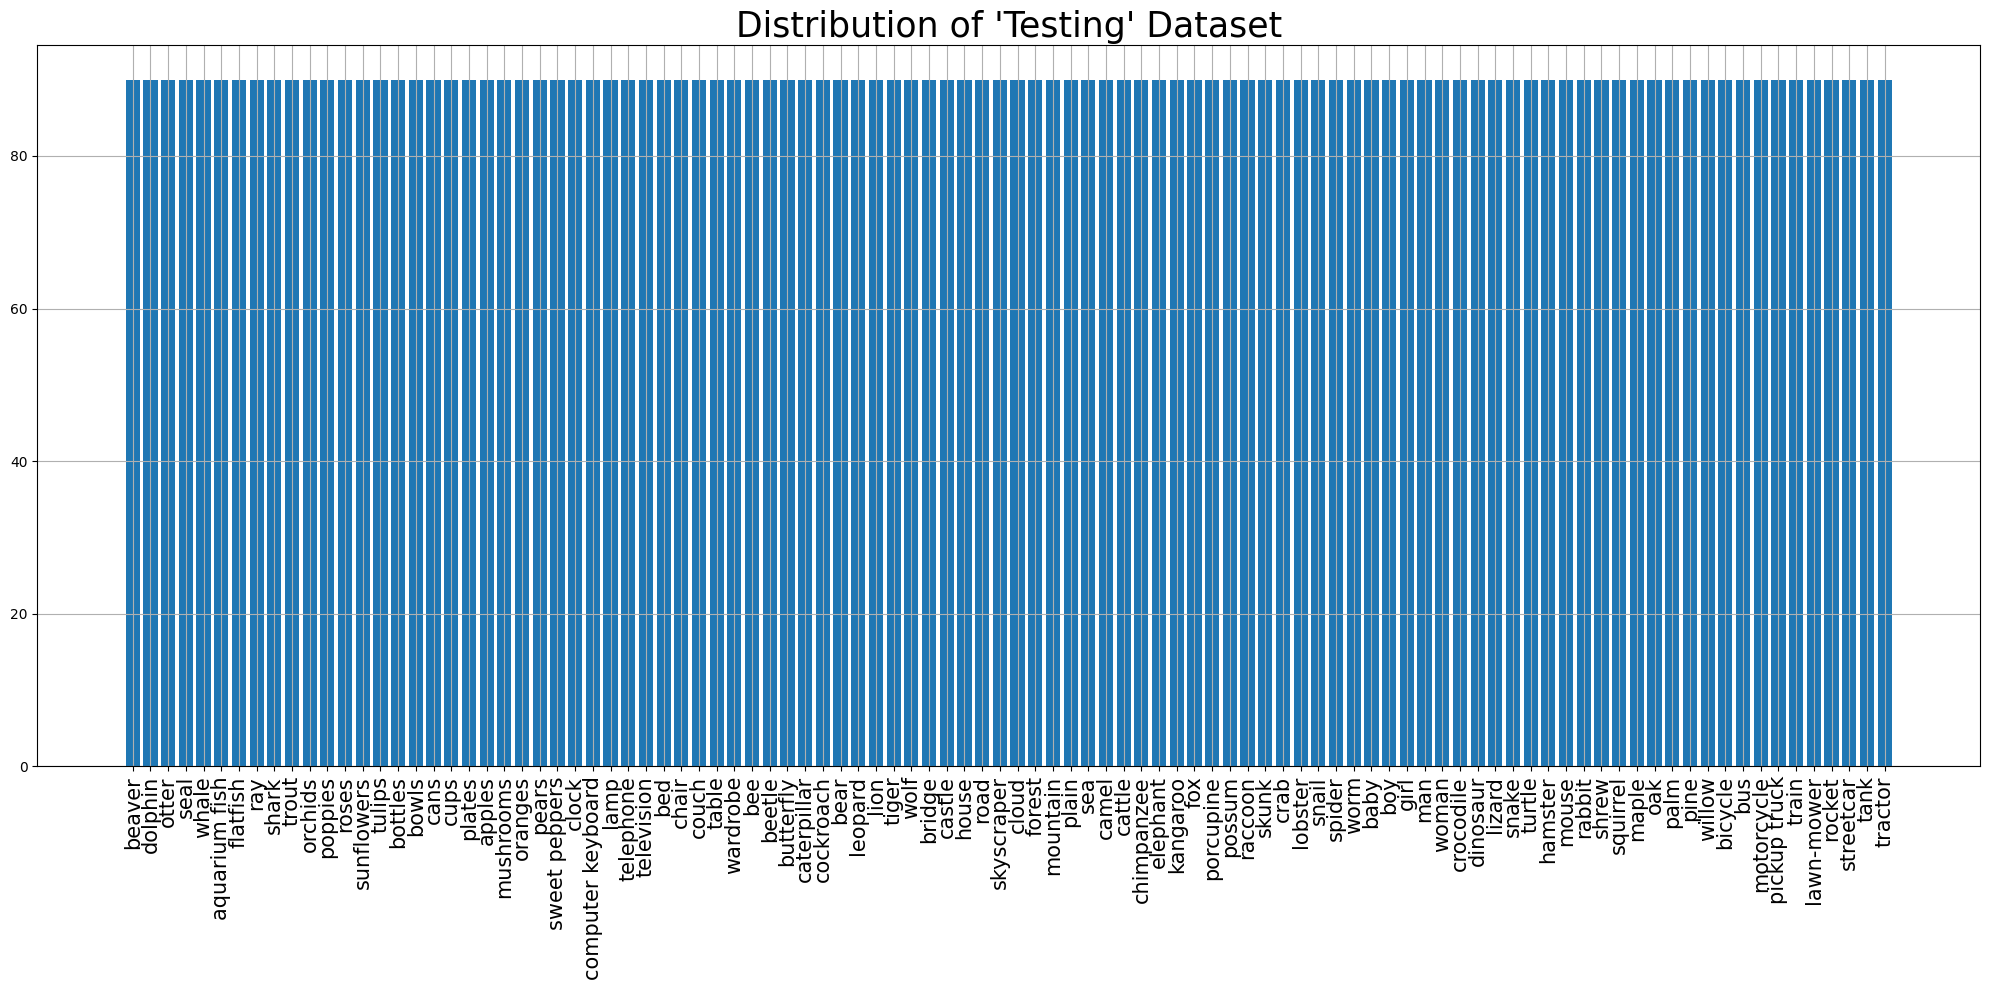

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1863 - f1_score: 0.1778 - loss: 3.6512 - precision: 0.5610
Epoch 1: val_loss improved from inf to 1.79046, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.1864 - f1_score: 0.1779 - loss: 3.6502 - precision: 0.5611 - val_accuracy: 0.5363 - val_f1_score: 0.5252 - val_loss: 1.7905 - val_precision: 0.8627
Epoch 2/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3866 - f1_score: 0.3780 - loss: 2.3105 - precision: 0.7092
Epoch 2: val_loss improved from 1.79046 to 1.68157, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.3866 - f1_score: 0.3780 - loss: 2.3103 - precision: 0.7092 - val_accuracy: 0.5540 - val_f1_score: 0.5454 - val_loss: 1.6816 - val_precision: 0.8708
Epoch 3/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4162 - f1_score: 0.4093 - loss: 2.1767 - precision: 0.7187
Epoch 3: val_loss improved from 1.68157 

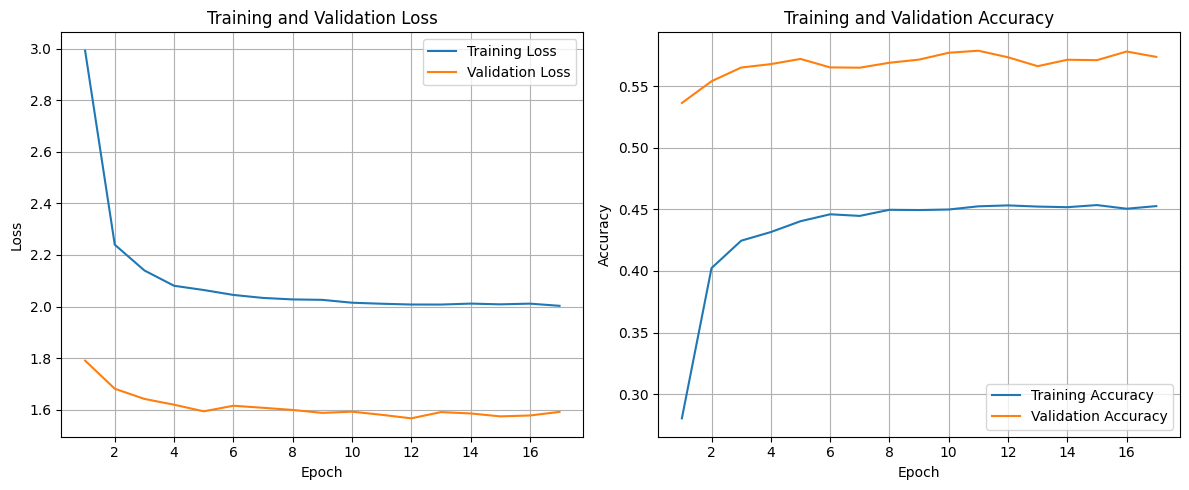

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5632 - f1_score: 0.5498 - loss: 1.5820 - precision: 0.8470
Test Accuracy: 57.32%
Test Loss: 1.5581715106964111
Test Precision: 85.07%
Test F1 Scores (Per Class): [82.142845 67.34693  53.254433 33.599995 27.5862   55.958546 52.25224
 61.714287 77.456635 80.459755 50.704224 44.247784 59.756096 46.09665
 63.51351  49.090904 70.99999  51.75718  49.785408 49.673195 77.906975
 70.64676  76.646706 72.04968  76.74419  56.43564  40.38461  32.85714
 74.8663   55.813946 31.746029 61.90476  34.53237  44.202892 61.538452
 11.42857  64.83515  38.167934 40.49079  85.       61.33333  73.73737
 48.48484  65.24063  44.999996 31.249996 45.038162 47.28434  75.89743
 76.756744 33.898304 64.670654 56.179775 85.10638  60.773476 31.70731
 67.33668  64.423065 49.586773 22.857141 74.8538   69.99999  59.523804
 62.983418 38.80597  42.335762 58.749992 47.66839  78.30189  79.24527
 59.113293 70.21276  33.33333  54.143642 30.263153 75.53191  76.756744
 54.081

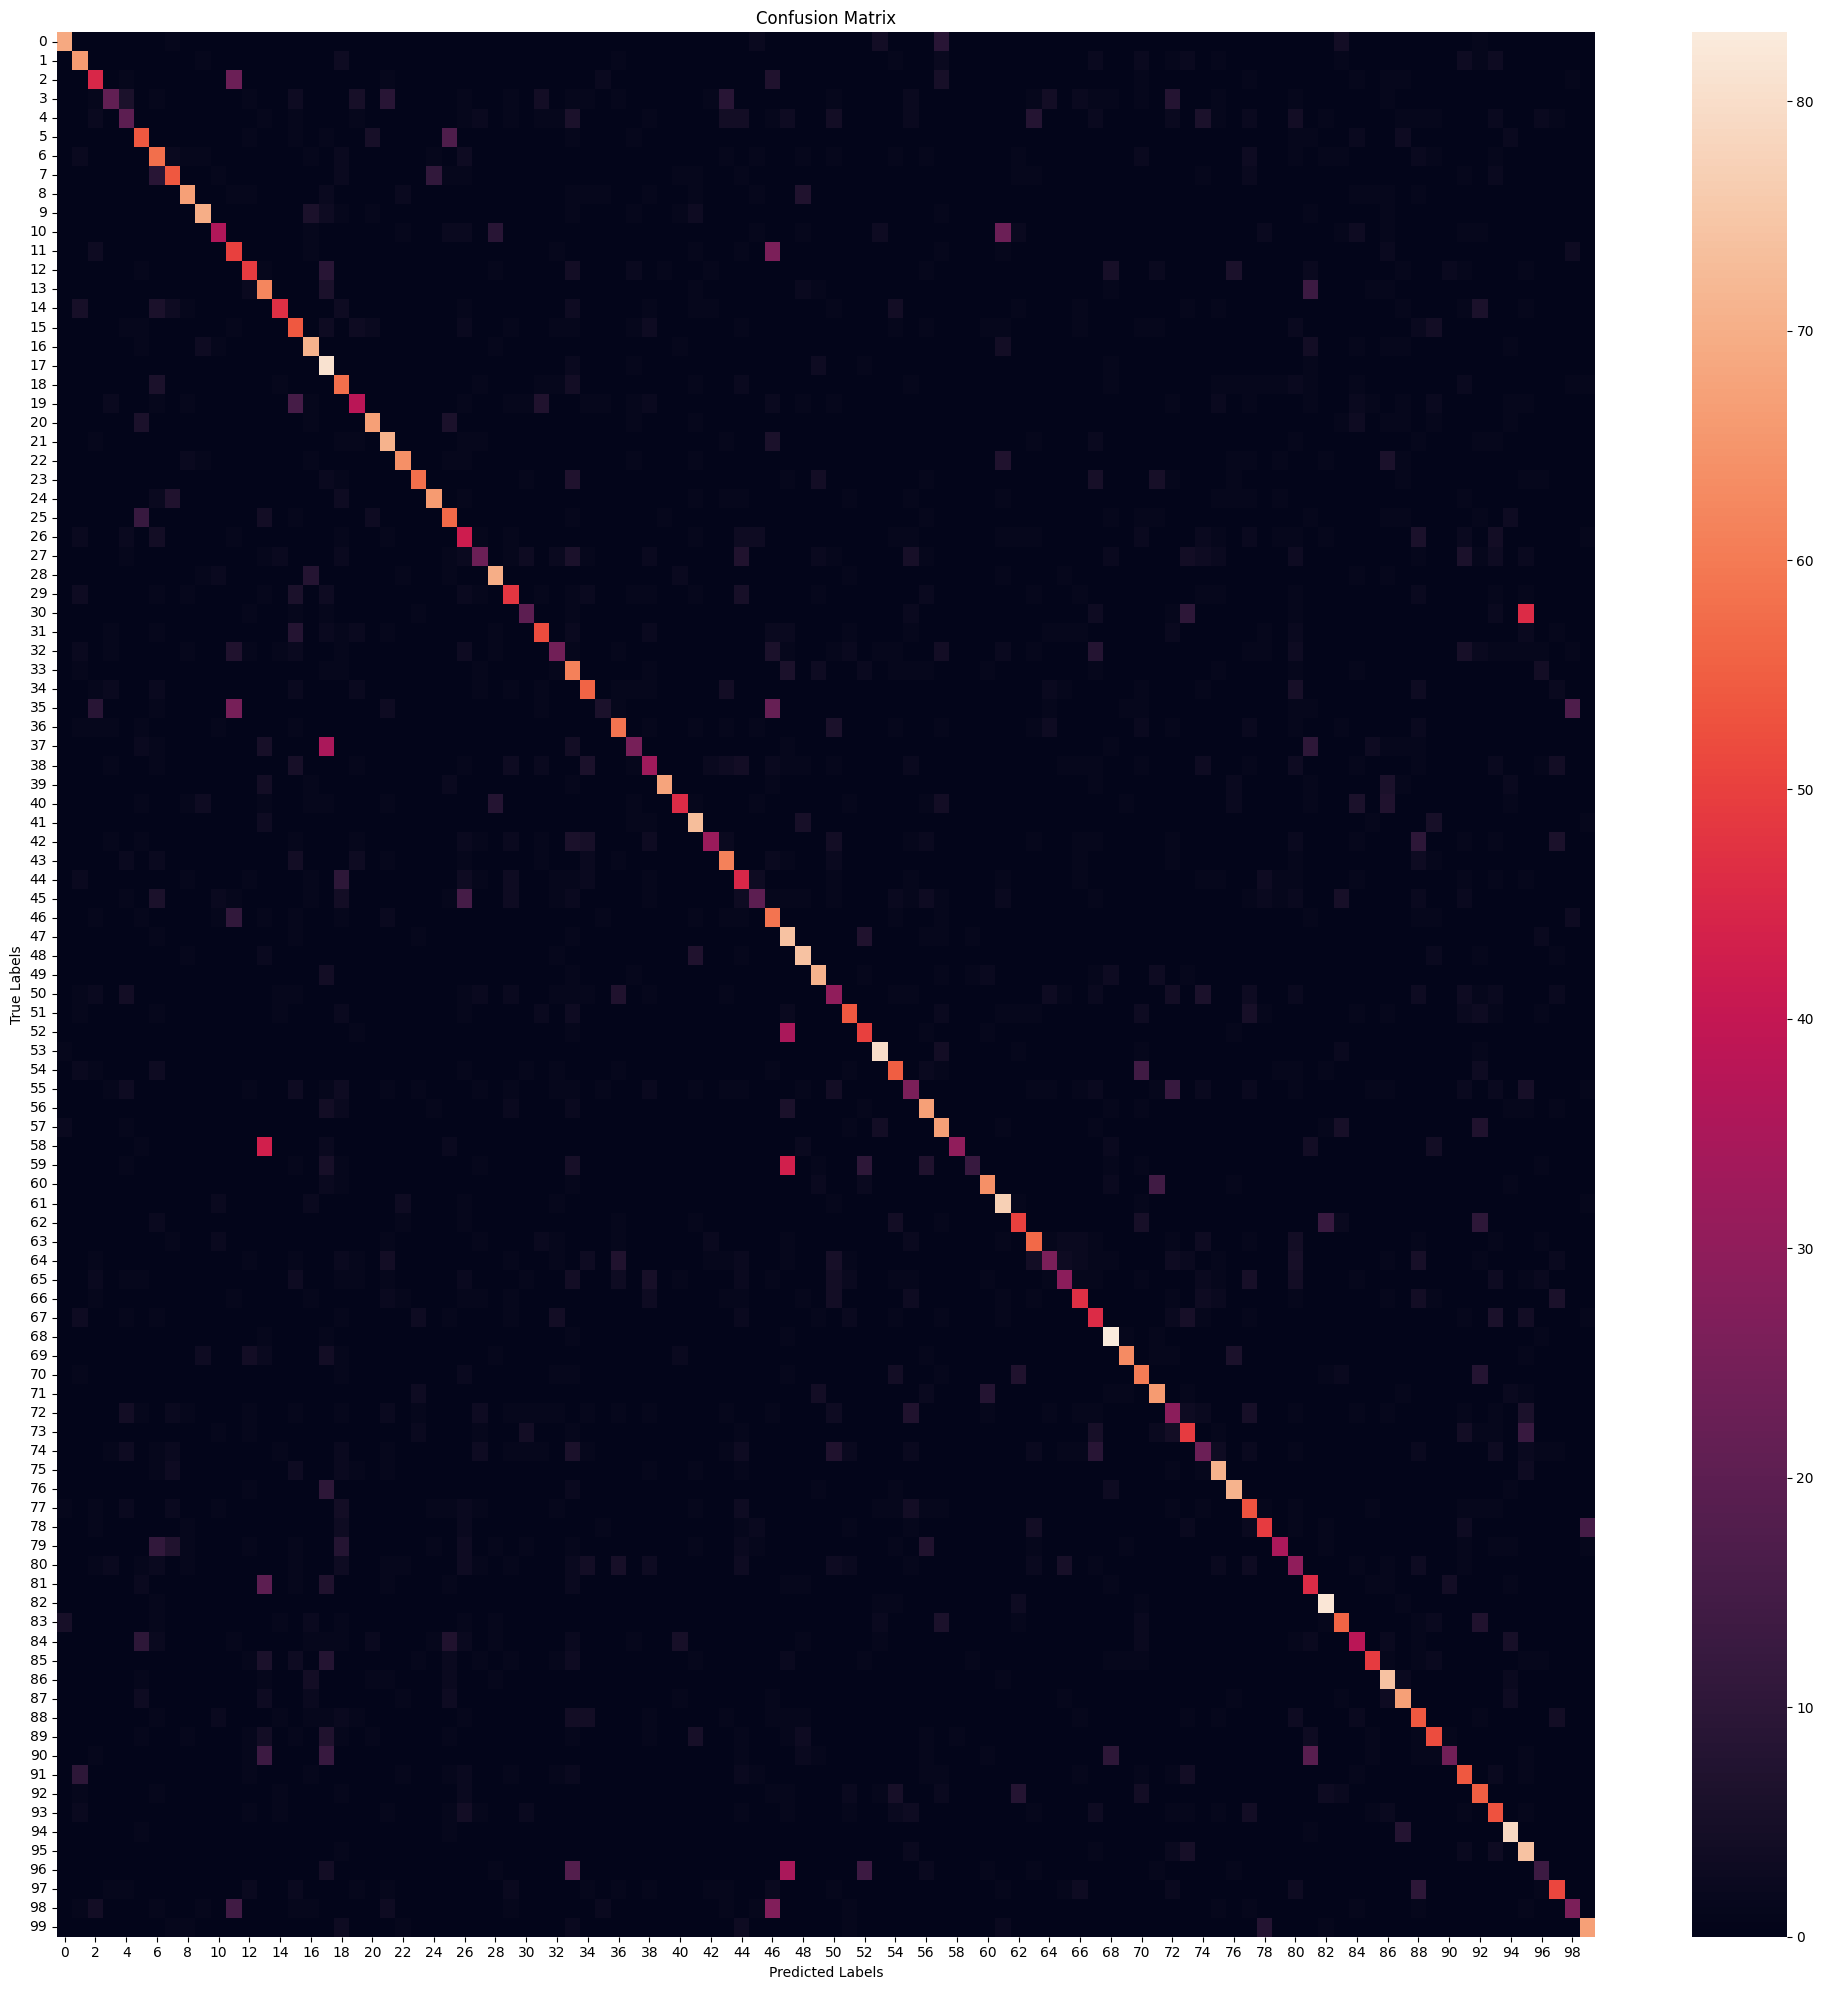

                   precision    recall  f1-score   support

           beaver       0.88      0.77      0.82        90
          dolphin       0.62      0.73      0.67        90
            otter       0.57      0.50      0.53        90
             seal       0.60      0.23      0.34        90
            whale       0.36      0.22      0.28        90
    aquarium fish       0.52      0.60      0.56        90
         flatfish       0.44      0.64      0.52        90
              ray       0.64      0.60      0.62        90
            shark       0.81      0.74      0.77        90
            trout       0.83      0.78      0.80        90
          orchids       0.69      0.40      0.51        90
          poppies       0.37      0.56      0.44        90
            roses       0.66      0.54      0.60        90
       sunflowers       0.35      0.69      0.46        90
           tulips       0.81      0.52      0.64        90
          bottles       0.42      0.60      0.49       

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4712 - f1_score: 0.4633 - loss: 1.9297 - precision: 0.7421
Epoch 1: val_loss improved from inf to 1.47768, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.4713 - f1_score: 0.4633 - loss: 1.9296 - precision: 0.7421 - val_accuracy: 0.6022 - val_f1_score: 0.5961 - val_loss: 1.4777 - val_precision: 0.8655
Epoch 2/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4982 - f1_score: 0.4919 - loss: 1.8191 - precision: 0.7647
Epoch 2: val_loss improved from 1.47768 to 1.45467, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.4982 - f1_score: 0.4920 - loss: 1.8190 - precision: 0.7647 - val_accuracy: 0.6062 - val_f1_score: 0.6011 - val_loss: 1.4547 - val_precision: 0.8614
Epoch 3/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5035 - f1_score: 0.4975 - loss: 1.7843 - precision: 0.7700
Epoch 3: v

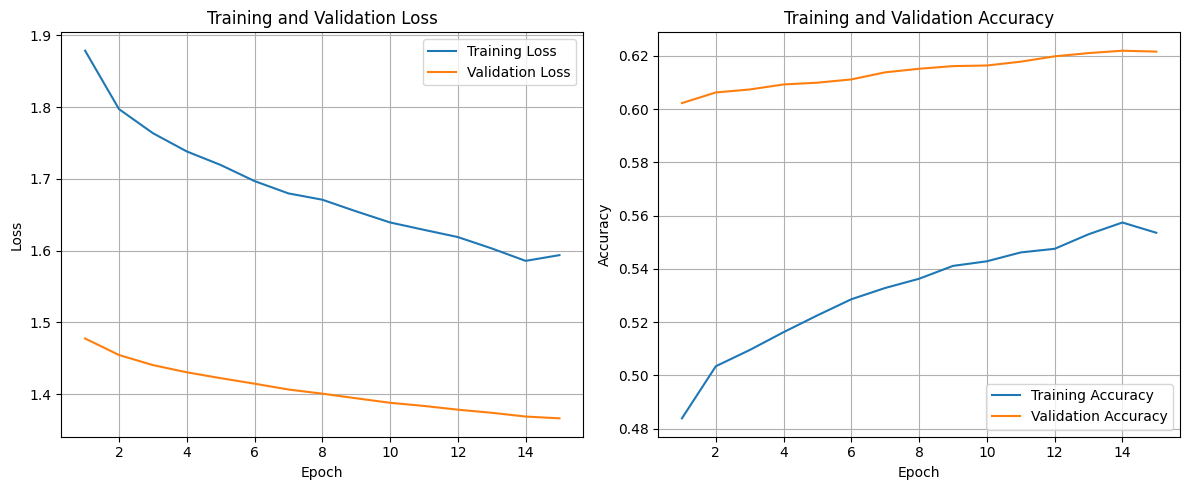

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6077 - f1_score: 0.5990 - loss: 1.3772 - precision: 0.8401
Test Accuracy: 62.27%
Test Loss: 1.3533506393432617
Test Precision: 85.40%
Test F1 Scores (Per Class): [84.44444  71.71716  56.66666  43.181812 32.335327 59.685856 54.35897
 66.26506  77.8443   79.54544  59.21787  50.       63.387978 56.28742
 65.47618  54.64481  73.846146 73.36682  54.838707 54.117645 78.453026
 76.923065 76.756744 77.41935  77.65957  62.352936 49.382713 37.391296
 78.16091  61.53846  57.64705  66.66666  44.72049  51.886784 63.73626
 28.235287 66.29834  53.93258  43.010746 87.71929  68.15642  80.681816
 56.818176 71.91011  49.438198 45.882347 49.142857 49.056595 76.84728
 81.08108  34.0136   69.71428  62.780266 87.29281  65.686264 29.629627
 76.300575 70.329666 80.701744 53.24675  76.83616  71.57894  63.87434
 61.202175 41.212116 52.380943 57.45856  55.999992 84.946236 81.52173
 63.157898 70.46631  36.58536  55.05617  32.78688  79.14438  81.96721
 57.471

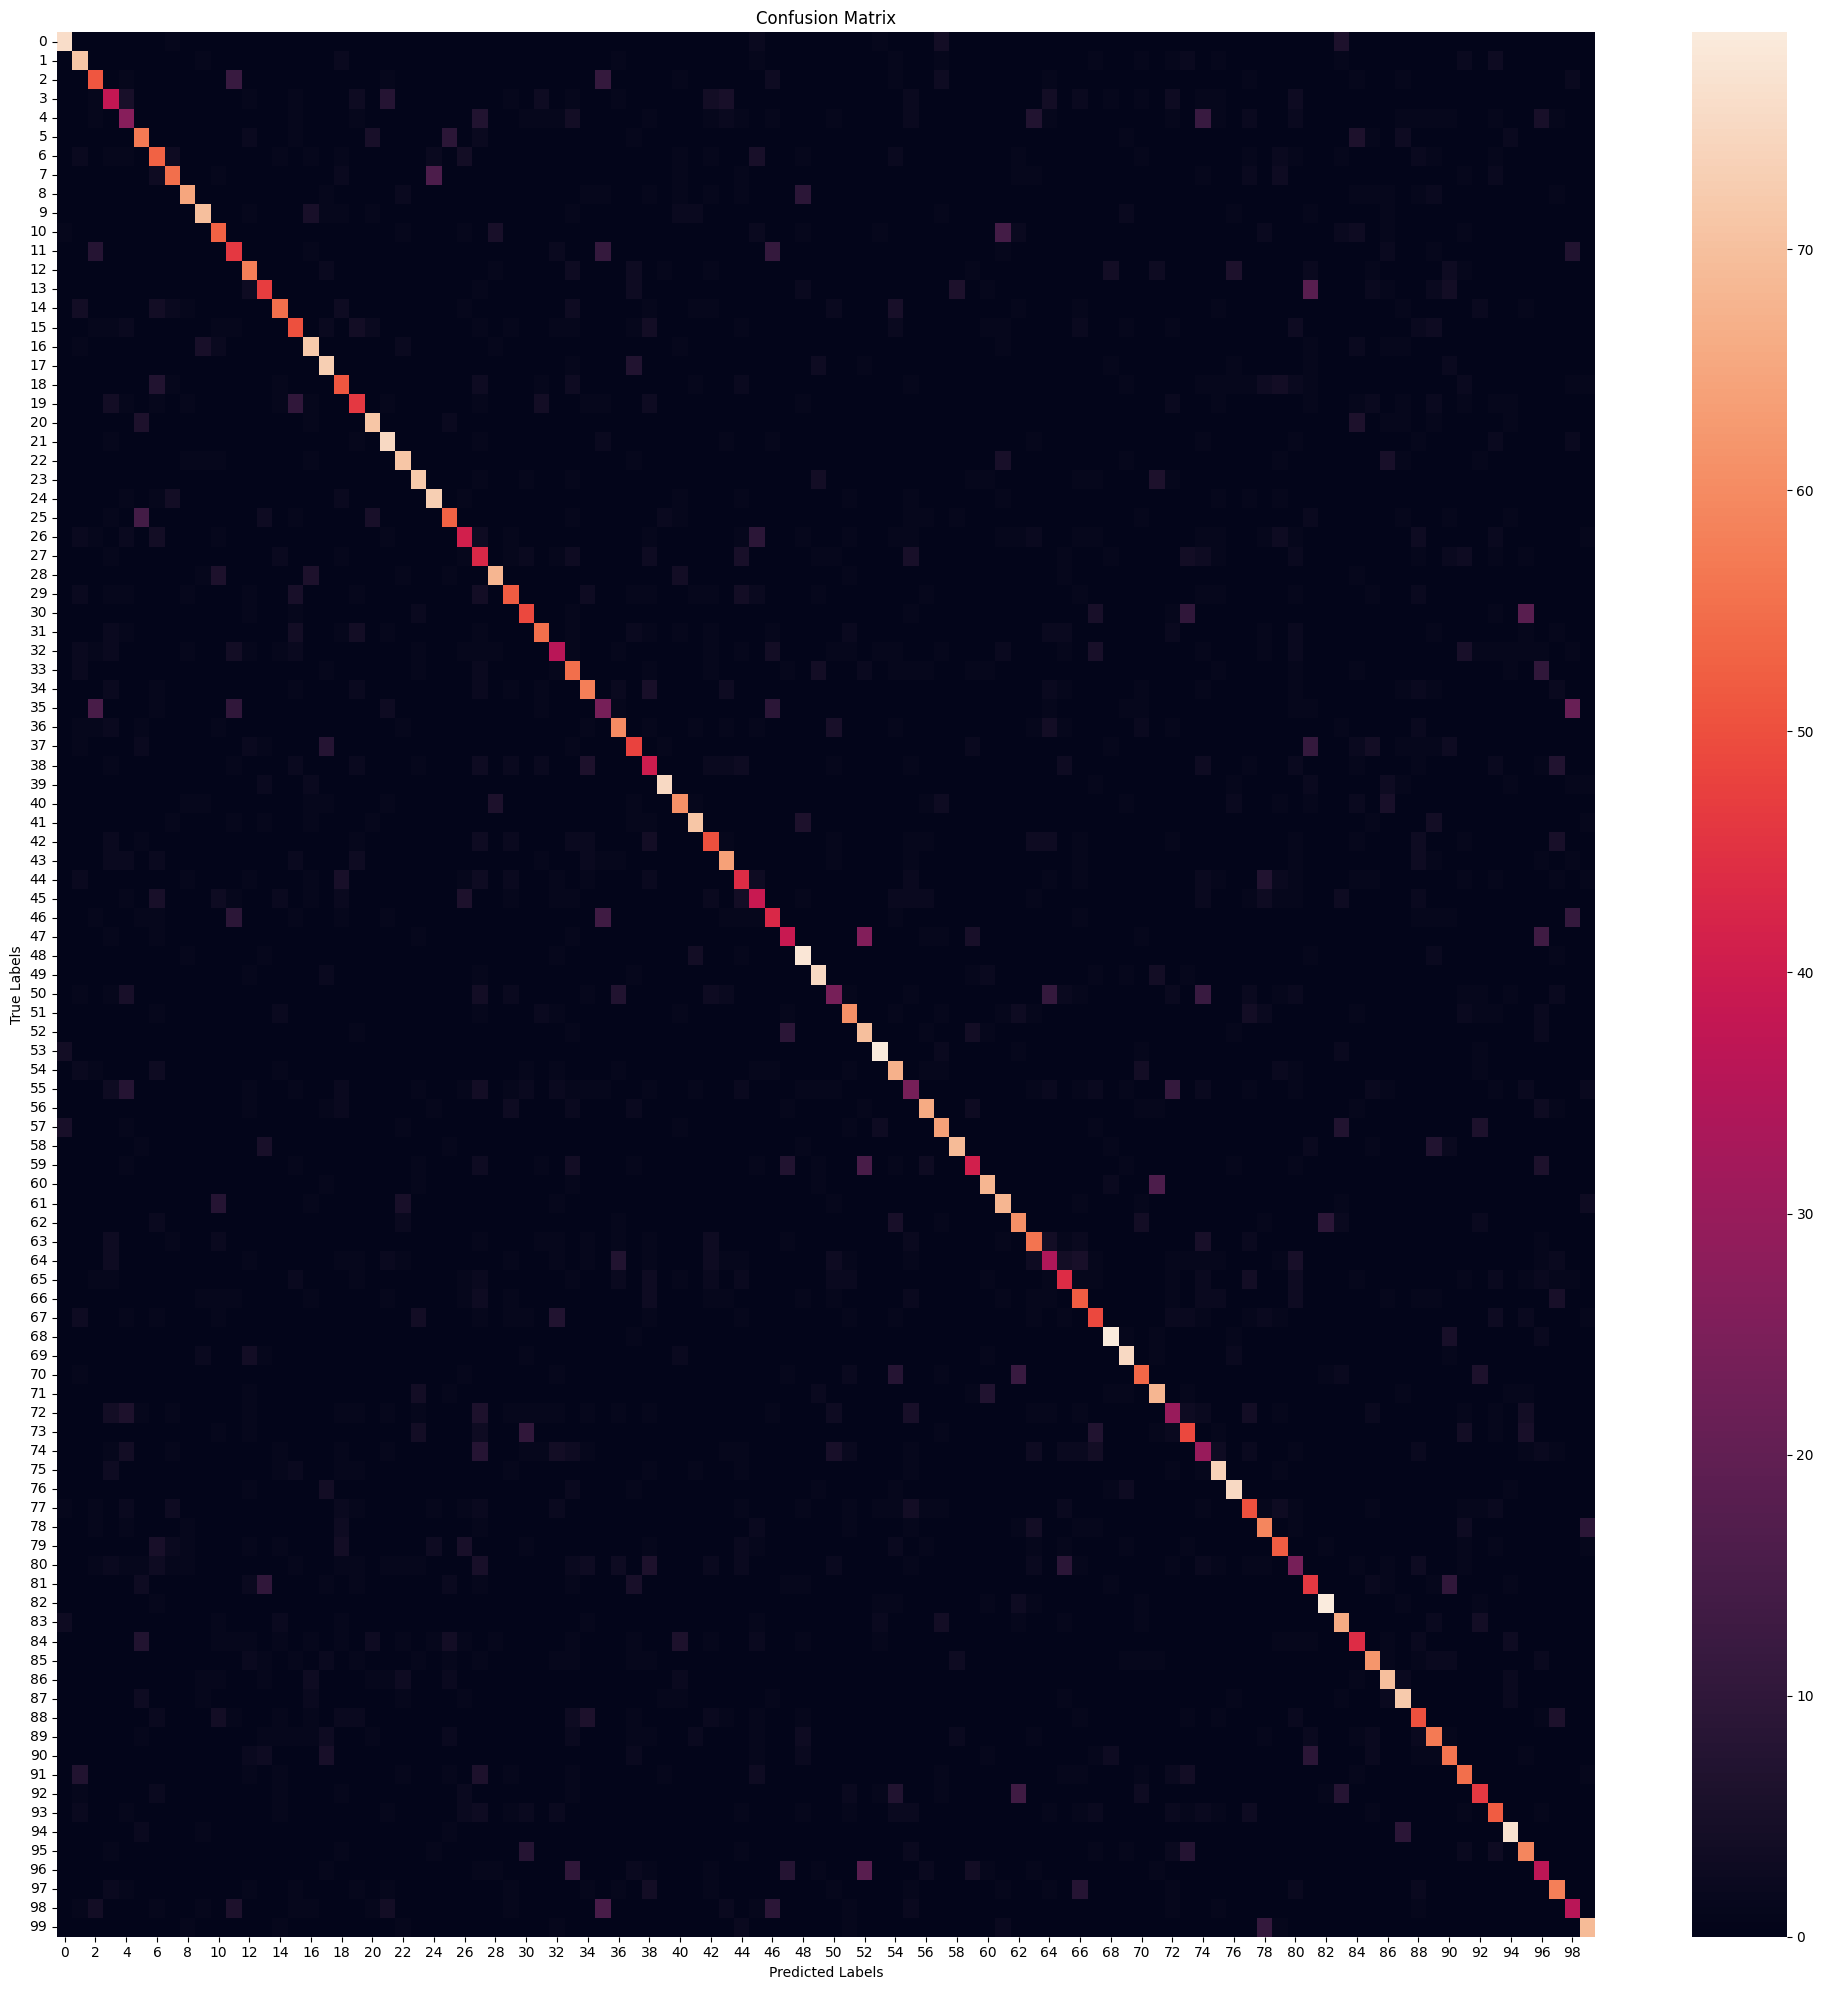

                   precision    recall  f1-score   support

           beaver       0.84      0.84      0.84        90
          dolphin       0.66      0.79      0.72        90
            otter       0.57      0.57      0.57        90
             seal       0.44      0.42      0.43        90
            whale       0.35      0.30      0.32        90
    aquarium fish       0.56      0.63      0.60        90
         flatfish       0.50      0.59      0.54        90
              ray       0.72      0.61      0.66        90
            shark       0.84      0.72      0.78        90
            trout       0.81      0.78      0.80        90
          orchids       0.60      0.59      0.59        90
          poppies       0.49      0.51      0.50        90
            roses       0.62      0.64      0.63        90
       sunflowers       0.61      0.52      0.56        90
           tulips       0.71      0.61      0.65        90
          bottles       0.54      0.56      0.55       

In [6]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    #train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #                 .batch(batch_size)
    #                 .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_#.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(0.9) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.8), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=0.9), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v2.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v2.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v2.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v2.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.8), weight_decay(0.9), l2(0.9), train_augmentation - over-regularising

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[8252].shape: (1,)
imgs[8252].shape: (32, 32, 3)


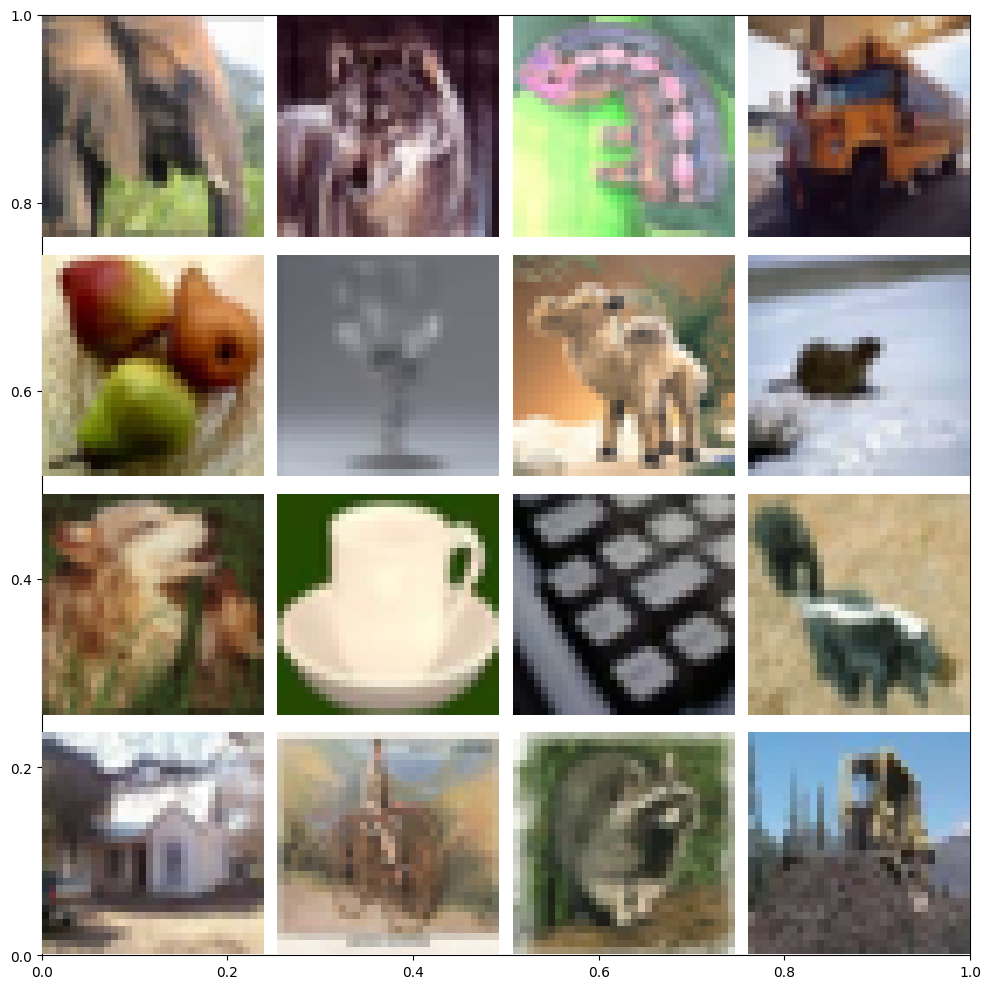

labels[6553].shape: (1,)
imgs[6553].shape: (32, 32, 3)


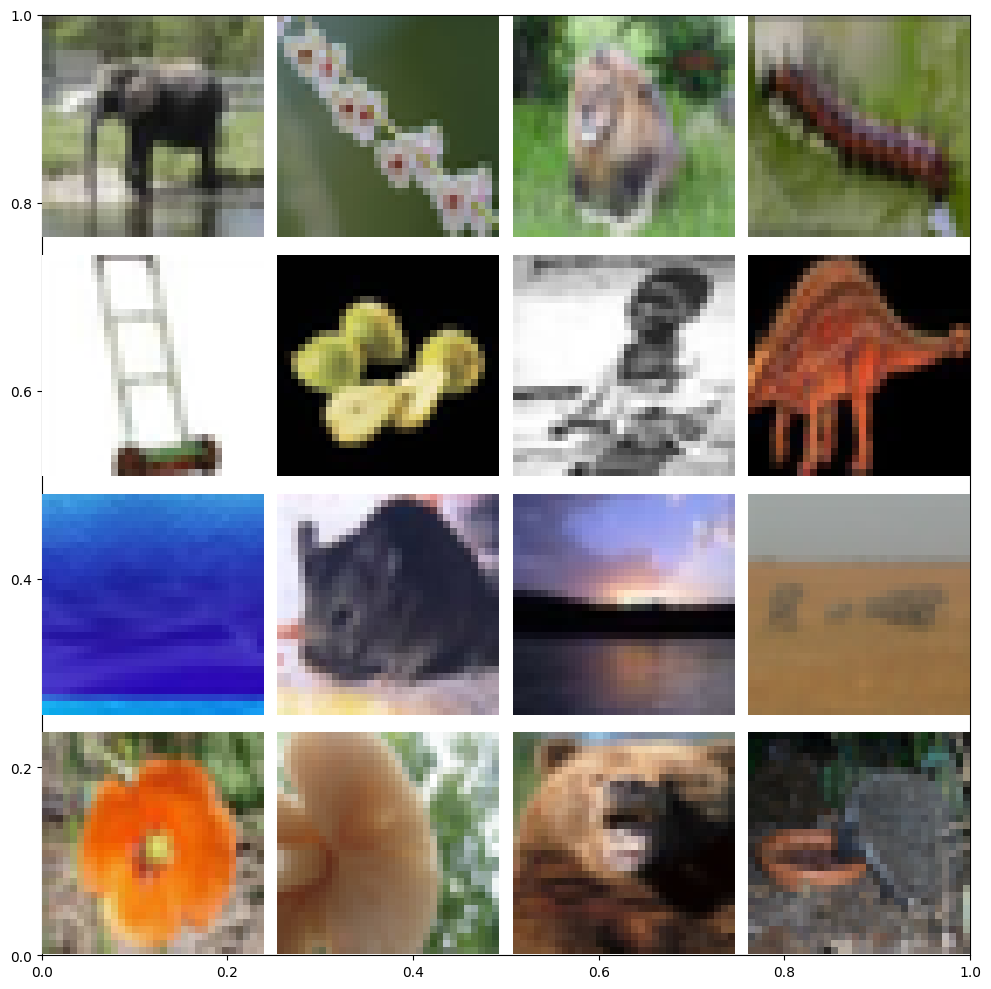

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


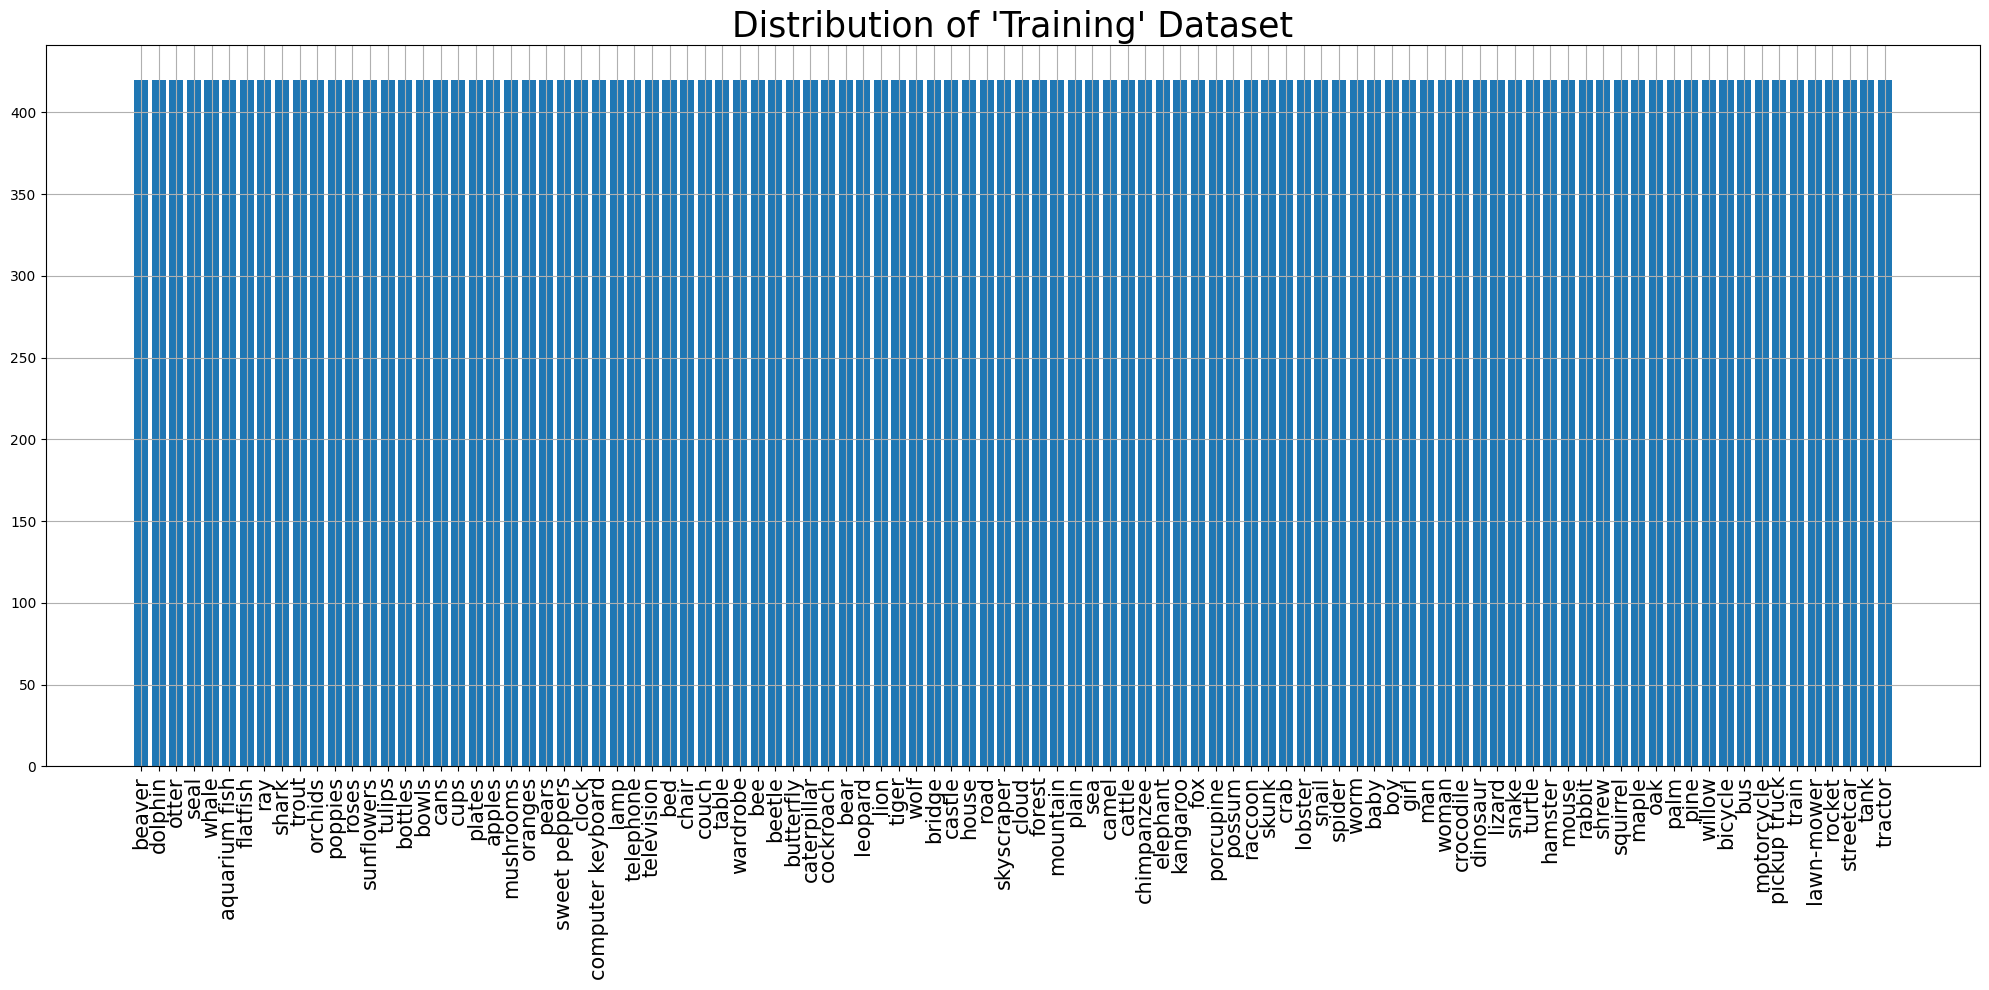

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


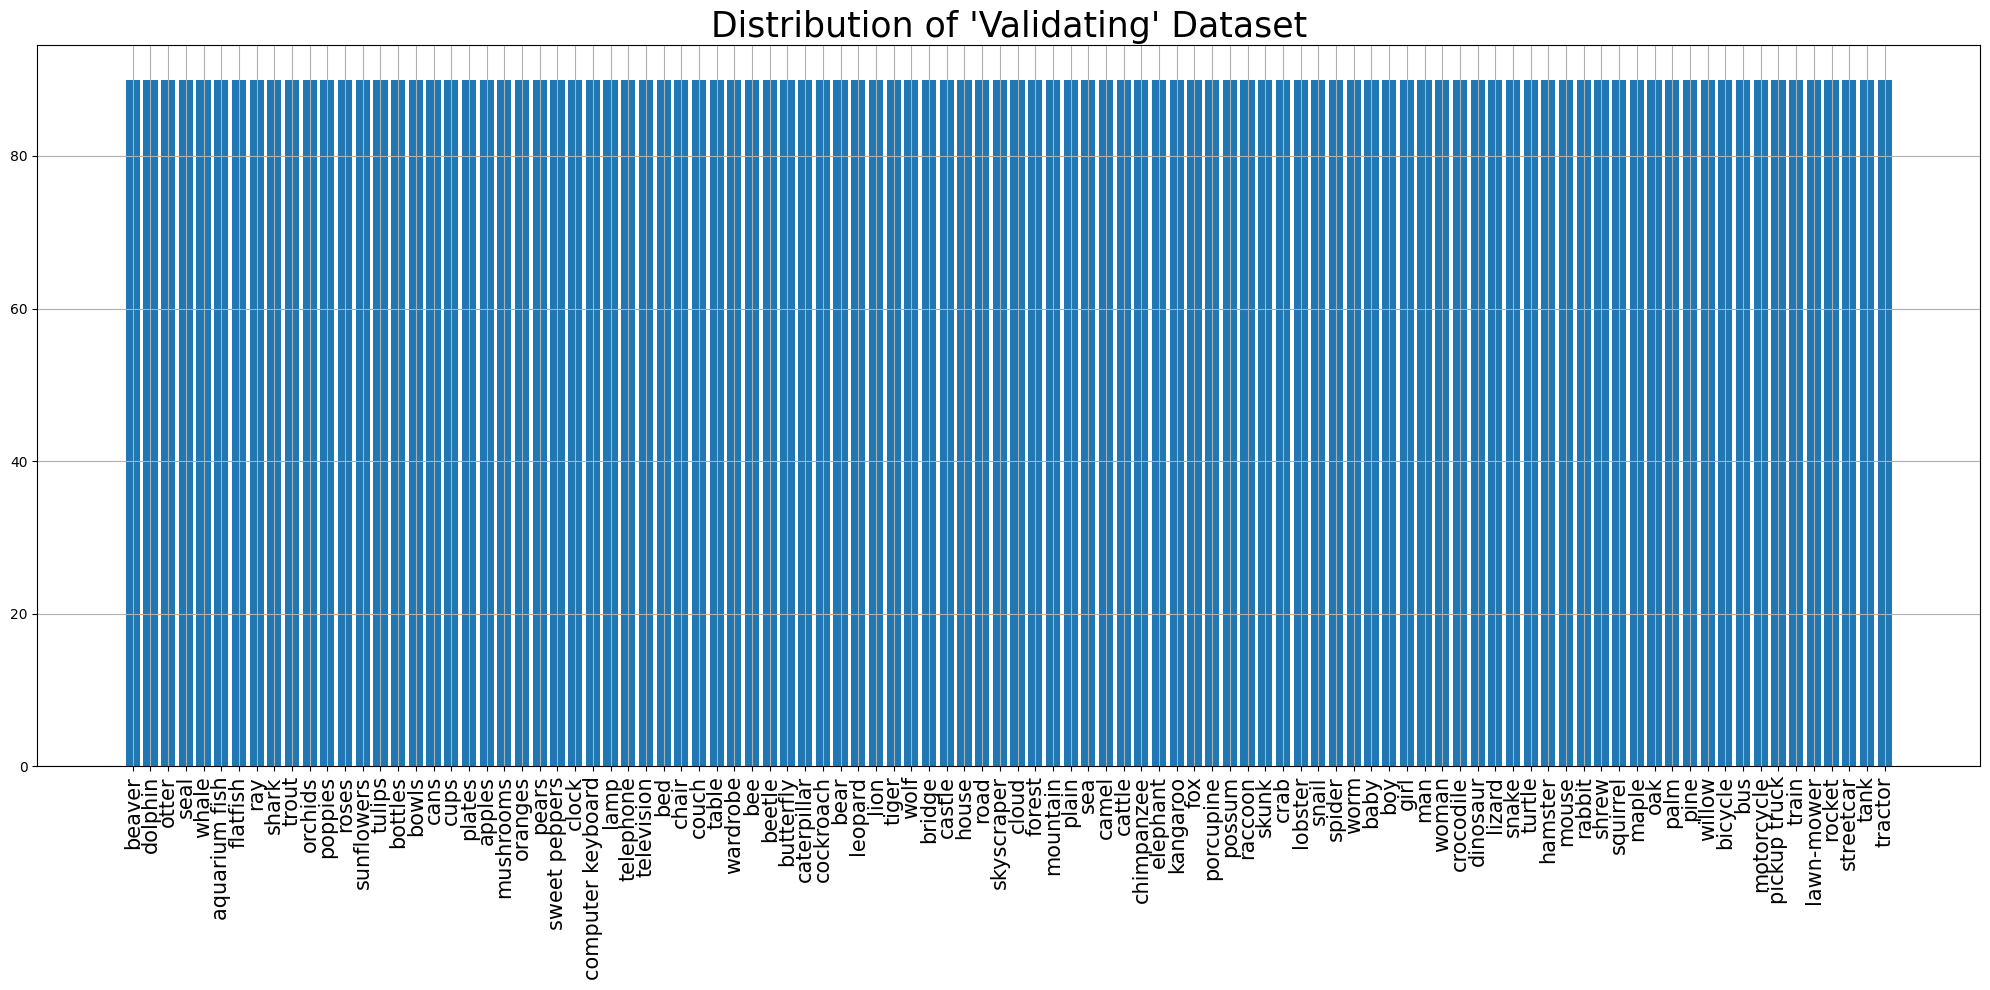

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


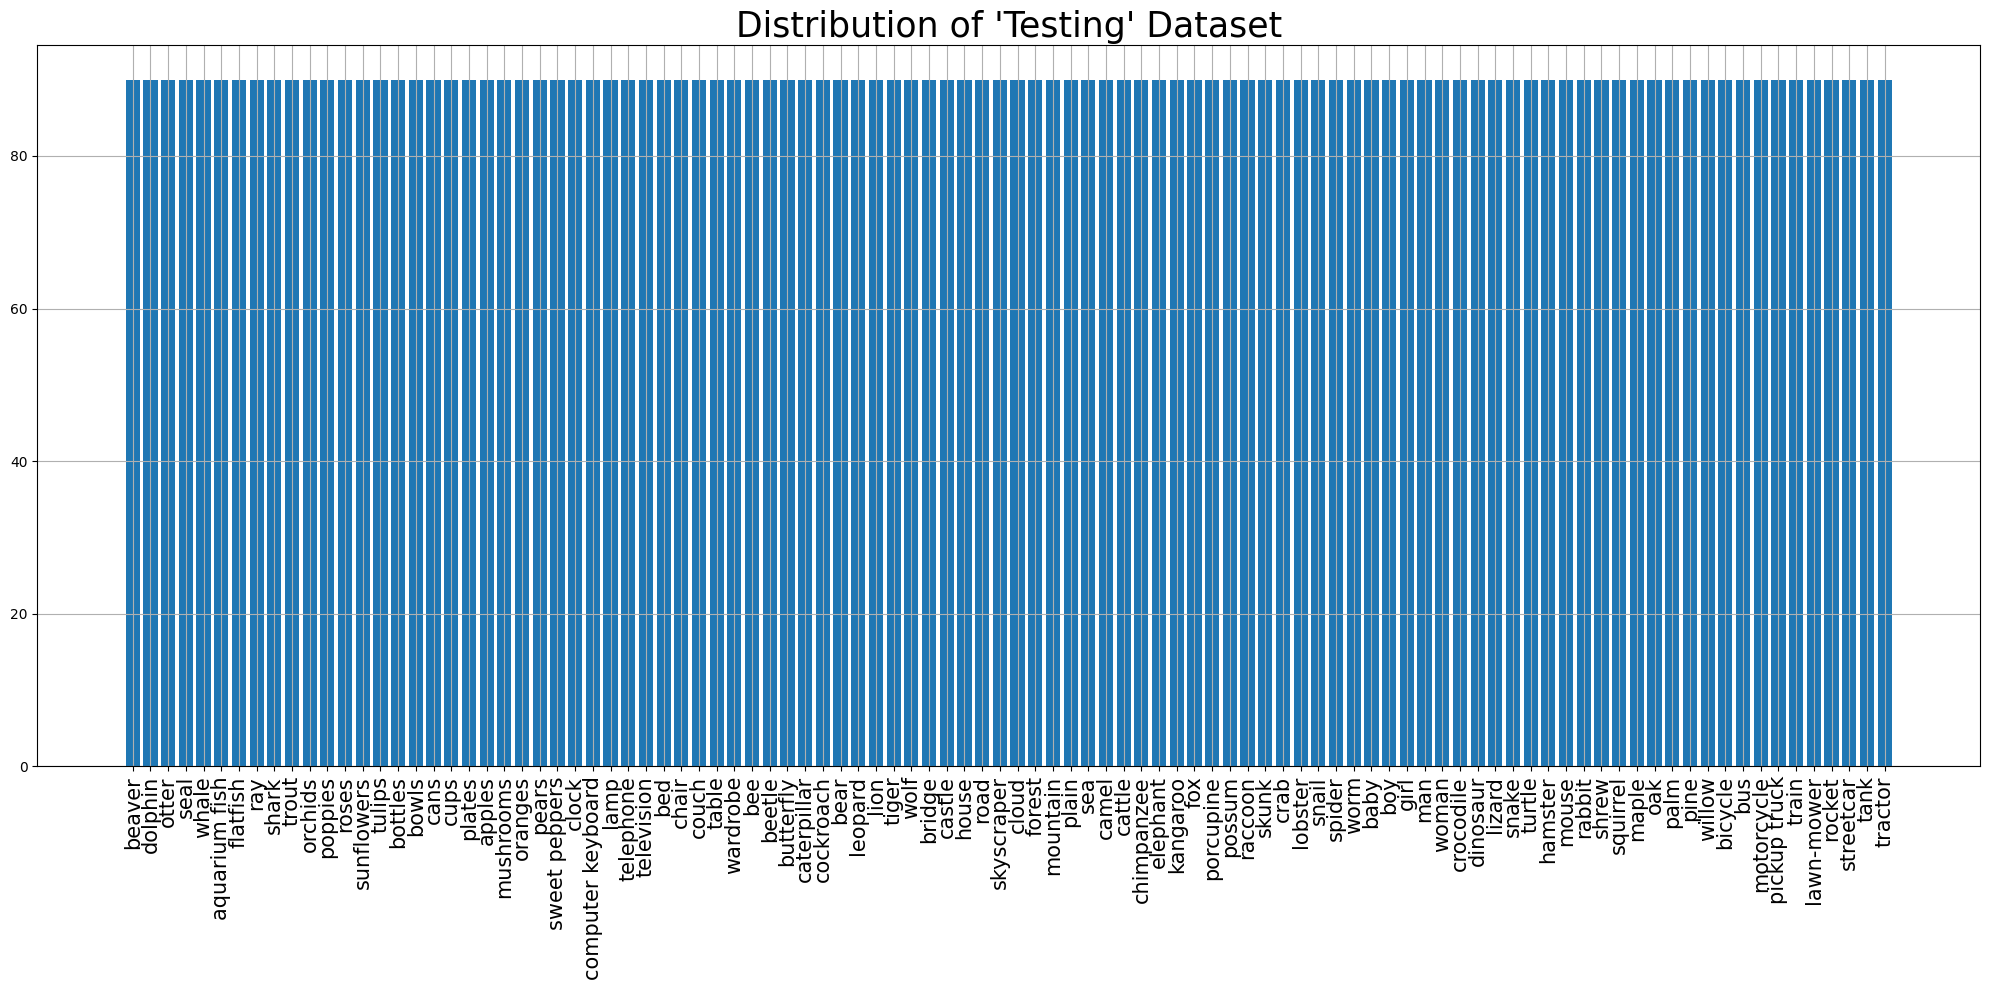

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2546 - f1_score: 0.2476 - loss: 3.2023 - precision: 0.6290
Epoch 1: val_loss improved from inf to 1.68343, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.2548 - f1_score: 0.2478 - loss: 3.2009 - precision: 0.6292 - val_accuracy: 0.5563 - val_f1_score: 0.5467 - val_loss: 1.6834 - val_precision: 0.8685
Epoch 2/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4215 - f1_score: 0.4149 - loss: 2.1536 - precision: 0.7285
Epoch 2: val_loss improved from 1.68343 to 1.61151, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.4215 - f1_score: 0.4149 - loss: 2.1535 - precision: 0.7285 - val_accuracy: 0.5724 - val_f1_score: 0.5632 - val_loss: 1.6115 - val_precision: 0.8717
Epoch 3/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4300 - f1_score: 0.4242 - loss: 2.0942 - precision: 0.7291
Epoch 3: val_loss improved fro

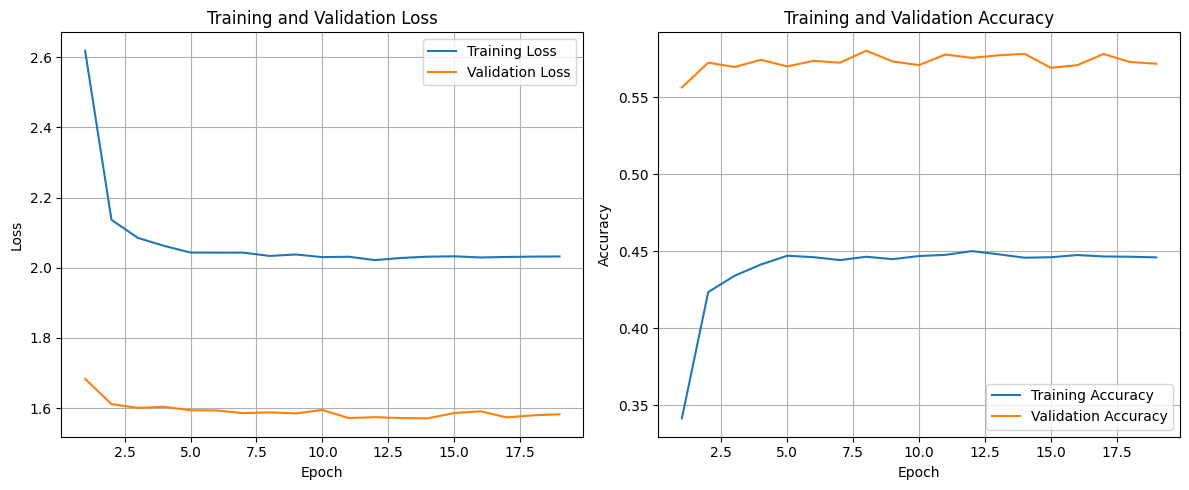

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5647 - f1_score: 0.5507 - loss: 1.5889 - precision: 0.8484
Test Accuracy: 57.69%
Test Loss: 1.5593595504760742
Test Precision: 85.85%
Test F1 Scores (Per Class): [78.75     68.31682  54.748596 23.214283 22.222218 59.66851  50.39369
 65.968575 79.53216  79.787224 60.1156   40.217384 60.810806 48.93617
 60.714275 51.923065 71.13402  55.10203  57.291664 52.1739   74.390236
 71.1111   77.38094  72.41379  74.71264  59.259247 44.897953 32.653057
 77.09496  54.90196  34.92063  62.14689  35.03649  47.154465 57.4074
  0.       66.666664 37.878784 33.33333  86.74699  65.49707  73.846146
 55.555546 63.21243  45.21739  29.565212 42.424236 41.379303 76.66666
 76.83616  32.95454  63.440853 53.403137 85.39326  62.275444 32.352936
 68.78981  59.574463 63.703697 23.214283 76.13636  73.26733  52.
 58.163254 41.249996 42.10526  60.927155 48.648643 80.95238  78.26086
 60.829483 69.791664 38.993706 49.10179  31.155773 78.260864 81.31868
 45.344128 62

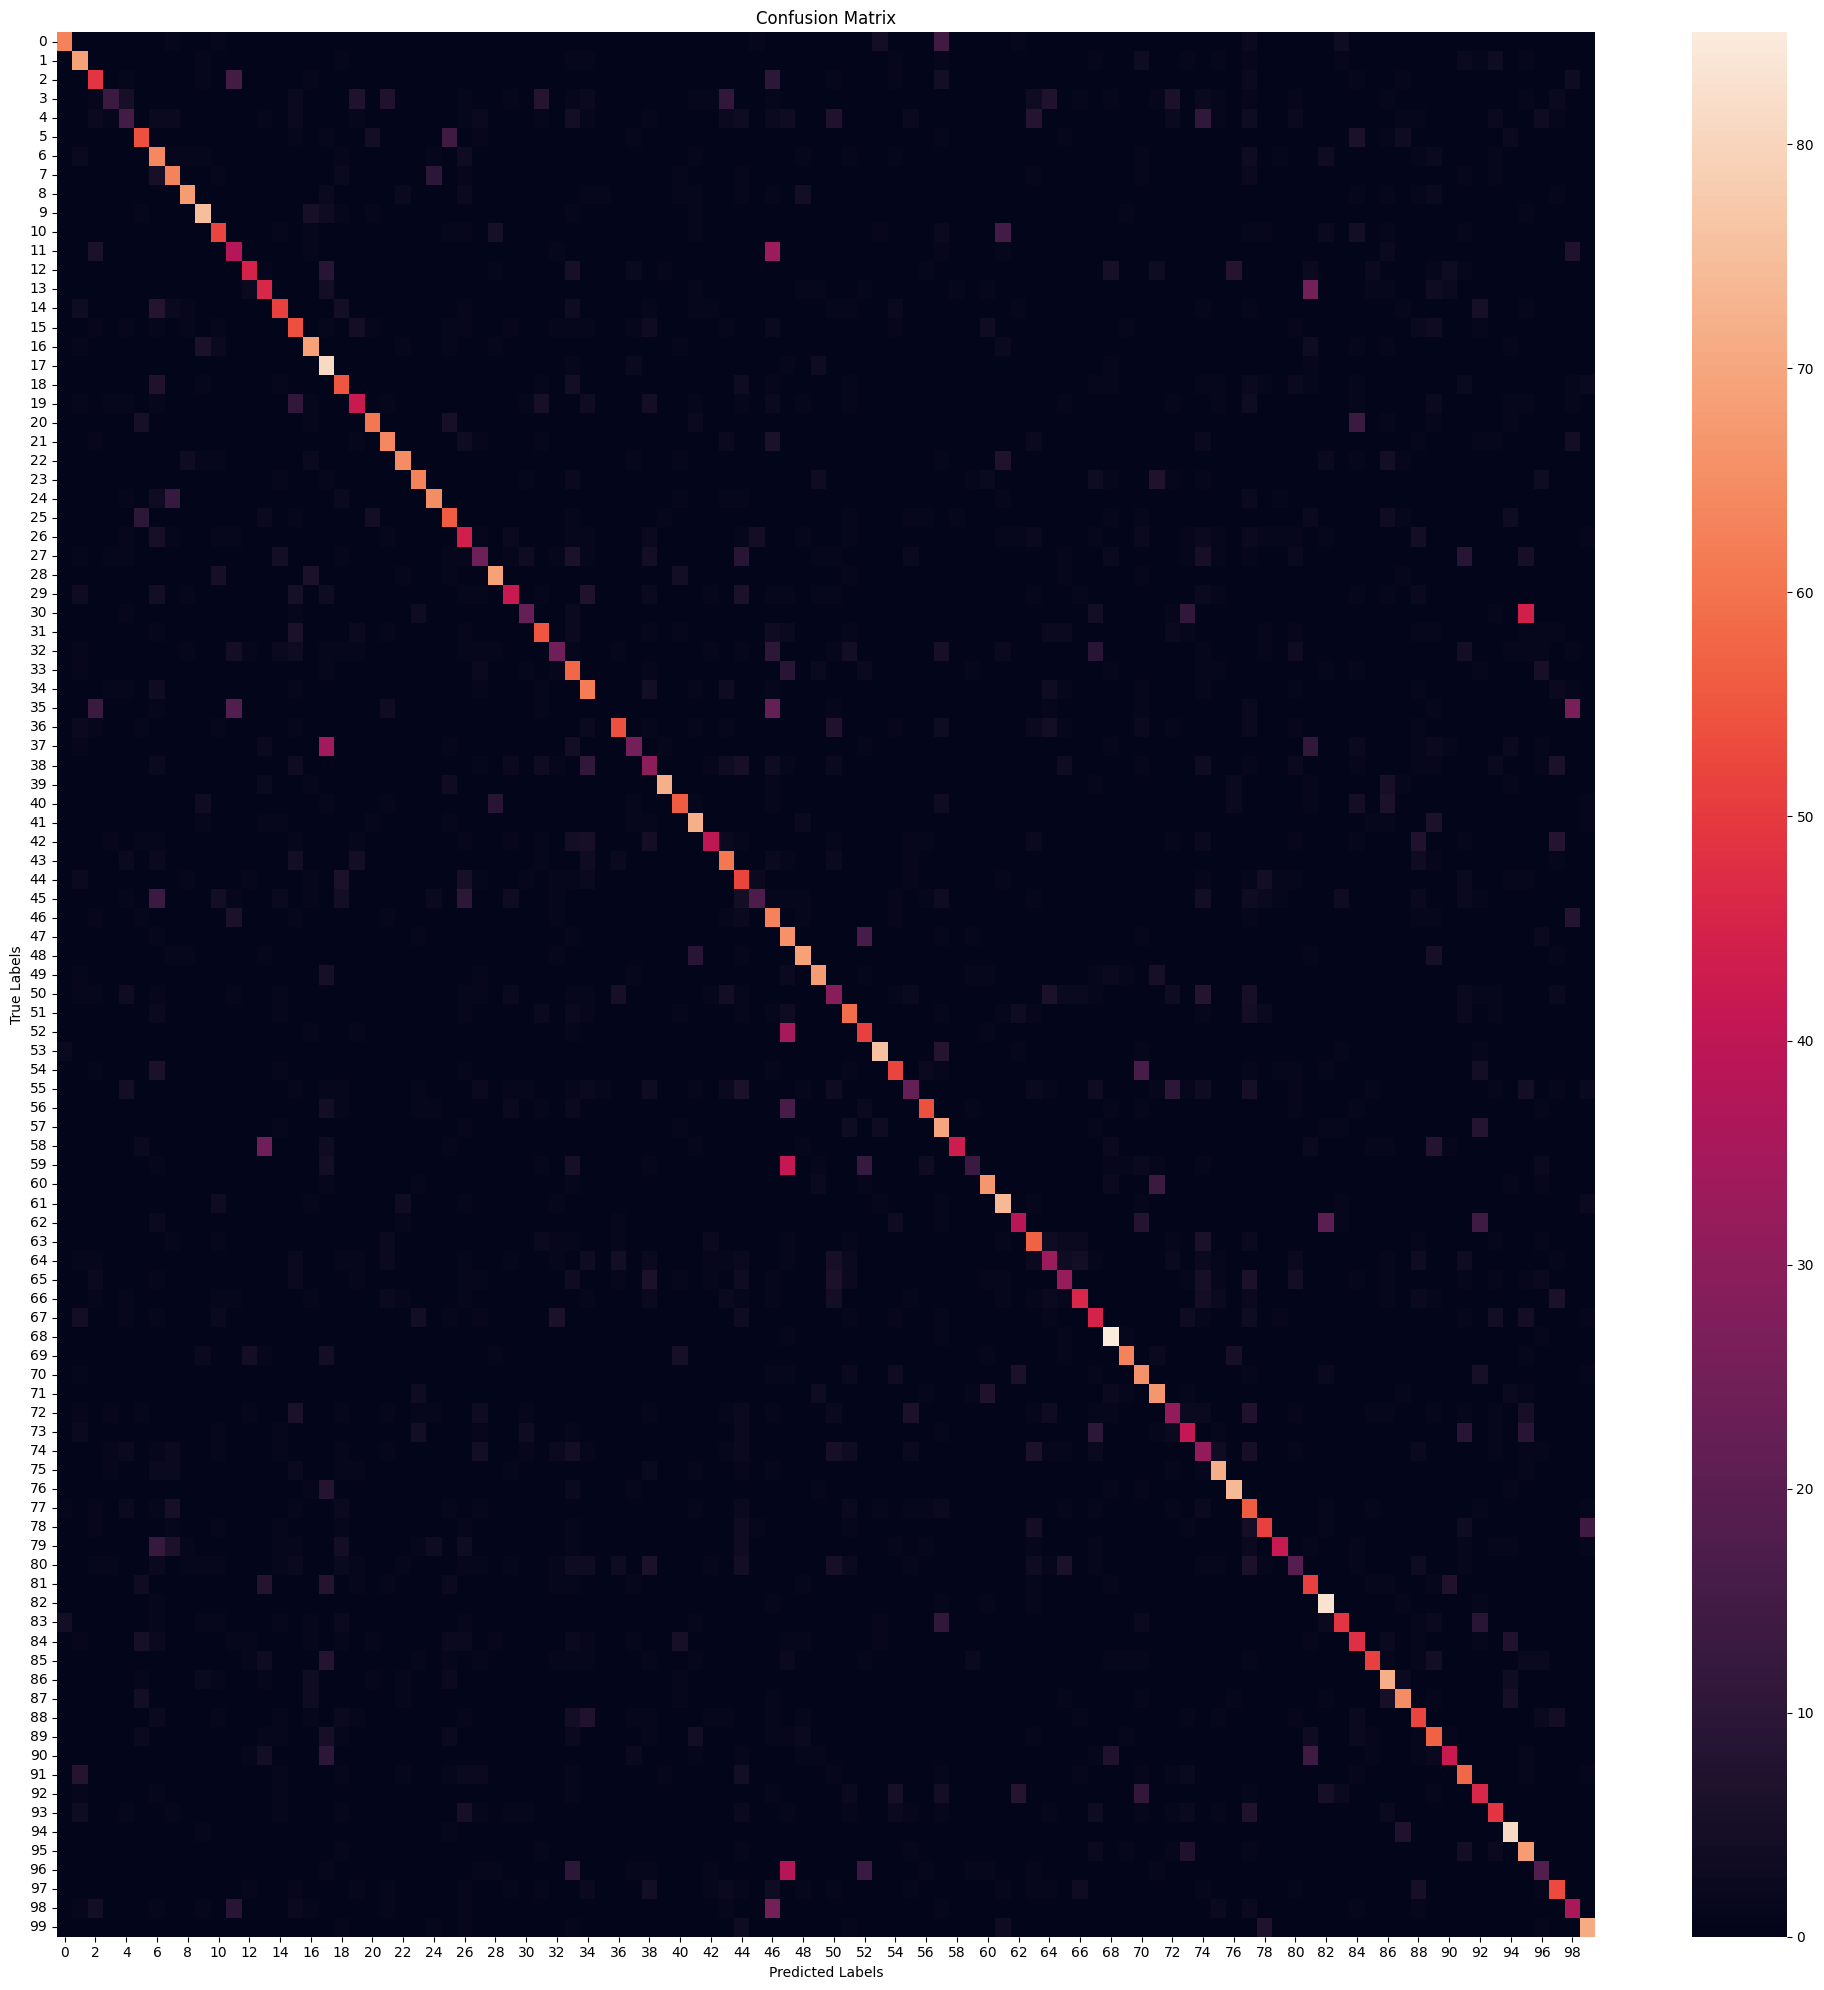

                   precision    recall  f1-score   support

           beaver       0.90      0.70      0.79        90
          dolphin       0.62      0.77      0.68        90
            otter       0.56      0.54      0.55        90
             seal       0.59      0.14      0.23        90
            whale       0.33      0.17      0.22        90
    aquarium fish       0.59      0.60      0.60        90
         flatfish       0.39      0.71      0.50        90
              ray       0.62      0.70      0.66        90
            shark       0.85      0.76      0.80        90
            trout       0.77      0.83      0.80        90
          orchids       0.63      0.58      0.60        90
          poppies       0.40      0.42      0.41        90
            roses       0.78      0.50      0.61        90
       sunflowers       0.47      0.51      0.49        90
           tulips       0.65      0.57      0.61        90
          bottles       0.46      0.60      0.52       

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4721 - f1_score: 0.4648 - loss: 1.9266 - precision: 0.7484
Epoch 1: val_loss improved from inf to 1.46425, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 70s 30ms/step - accuracy: 0.4721 - f1_score: 0.4649 - loss: 1.9265 - precision: 0.7484 - val_accuracy: 0.6007 - val_f1_score: 0.5958 - val_loss: 1.4642 - val_precision: 0.8615
Epoch 2/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5023 - f1_score: 0.4963 - loss: 1.7935 - precision: 0.7744
Epoch 2: val_loss improved from 1.46425 to 1.44226, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.5023 - f1_score: 0.4963 - loss: 1.7934 - precision: 0.7744 - val_accuracy: 0.6048 - val_f1_score: 0.6001 - val_loss: 1.4423 - val_precision: 0.8571
Epoch 3/15
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5149 - f1_score: 0.5088 - loss: 1.7524 - precision: 0.7783
Epoch 3: v

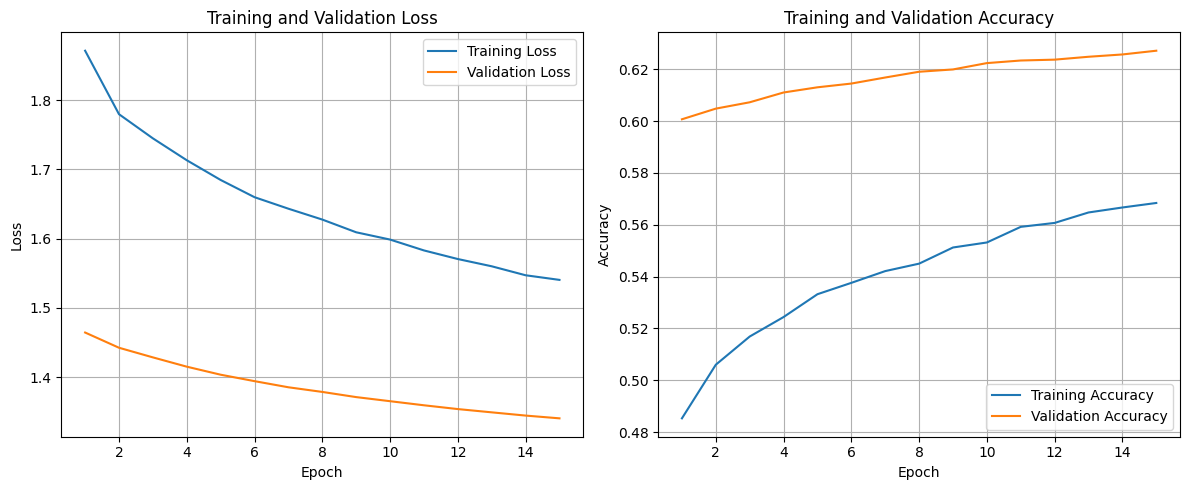

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6165 - f1_score: 0.6084 - loss: 1.3475 - precision: 0.8457
Test Accuracy: 62.90%
Test Loss: 1.3231642246246338
Test Precision: 85.69%
Test F1 Scores (Per Class): [83.14606  72.82051  51.813465 48.044685 33.540367 64.55026  54.35897
 64.80447  79.99999  81.87134  59.999996 47.999996 62.29508  55.294113
 67.45561  59.459454 74.371864 71.71716  59.340656 58.682625 77.34807
 77.7202   77.34807  76.190475 76.34408  67.45561  47.904186 38.33333
 77.01149  63.803684 58.100555 67.06587  50.632904 52.88461  63.33333
 23.899366 68.53932  53.475933 45.901634 89.534874 67.37968  77.9661
 58.426964 67.02702  48.42105  44.705875 49.162006 49.350643 73.846146
 81.31868  35.999996 68.508286 63.39285  88.52458  66.666664 32.298134
 76.02339  71.50838  77.906975 56.774185 75.55555  72.04301  64.17112
 61.797745 40.764324 50.61728  58.620686 57.471264 83.422455 82.608696
 66.66666  70.83333  42.23602  55.865913 33.507847 79.347824 85.71427
 58.7570

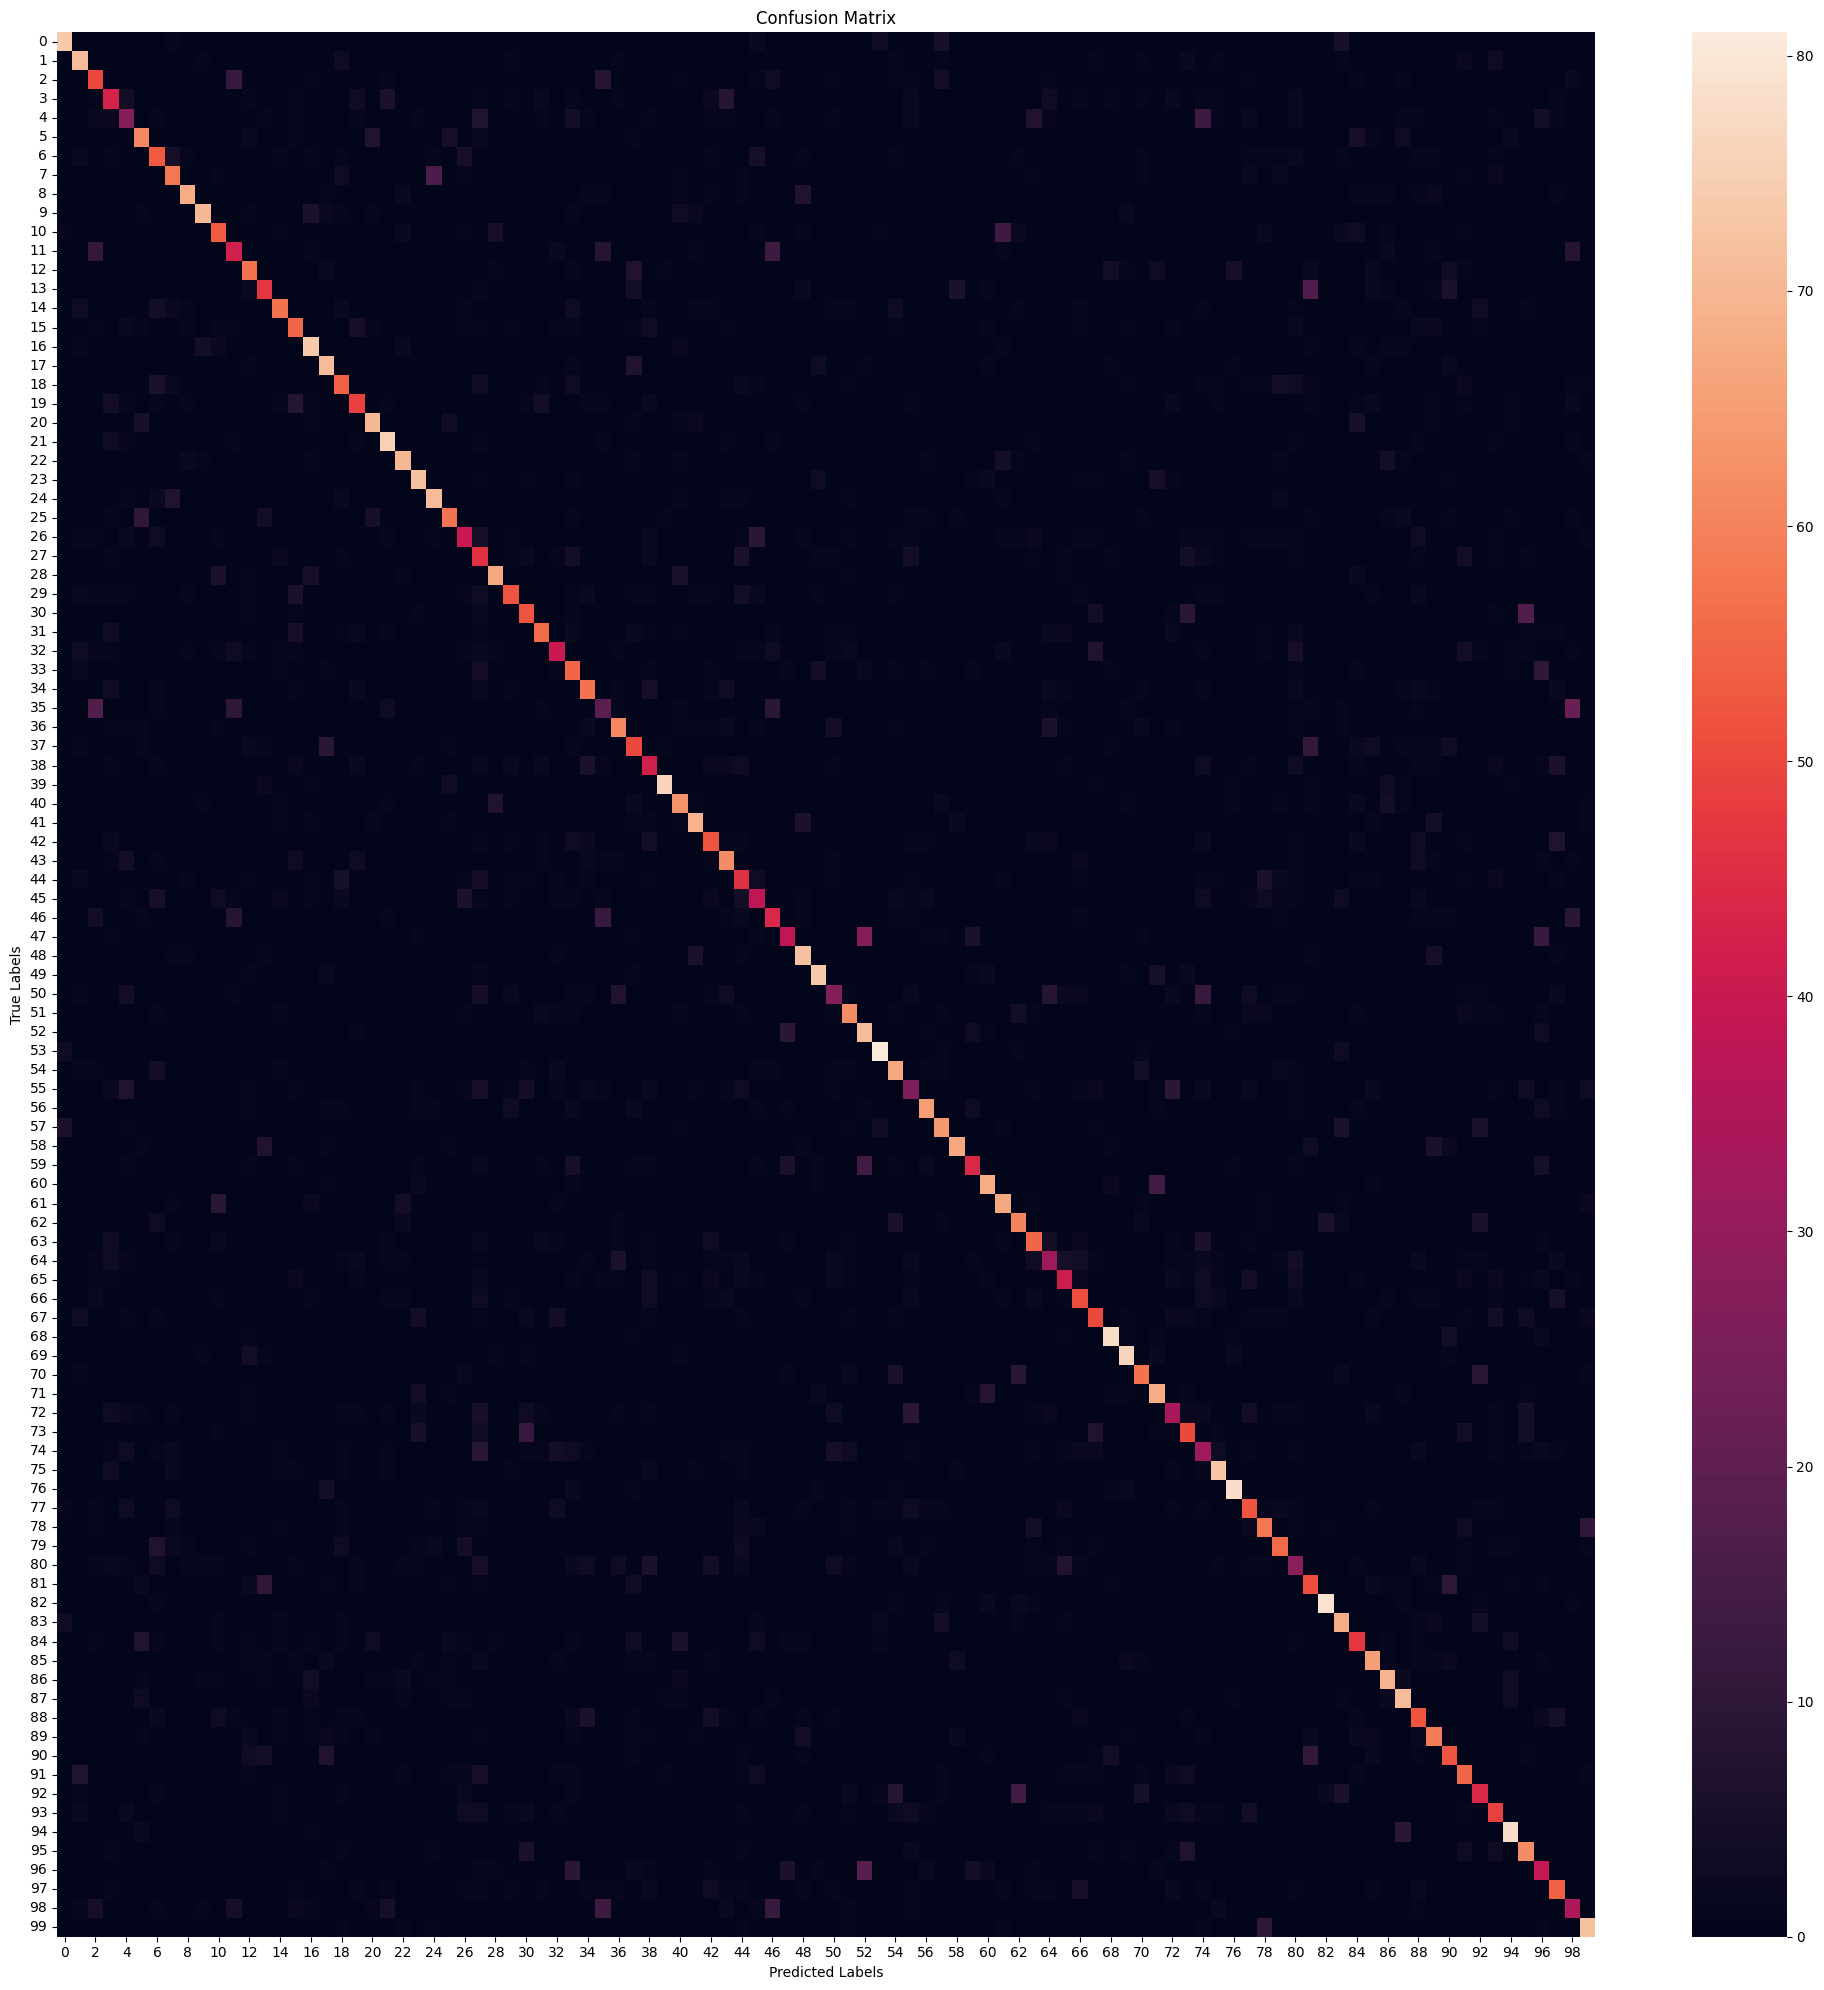

                   precision    recall  f1-score   support

           beaver       0.84      0.82      0.83        90
          dolphin       0.68      0.79      0.73        90
            otter       0.49      0.56      0.52        90
             seal       0.48      0.48      0.48        90
            whale       0.38      0.30      0.34        90
    aquarium fish       0.62      0.68      0.65        90
         flatfish       0.50      0.59      0.54        90
              ray       0.65      0.64      0.65        90
            shark       0.85      0.76      0.80        90
            trout       0.86      0.78      0.82        90
          orchids       0.60      0.59      0.59        90
          poppies       0.49      0.47      0.48        90
            roses       0.61      0.63      0.62        90
       sunflowers       0.59      0.52      0.55        90
           tulips       0.72      0.63      0.67        90
          bottles       0.58      0.61      0.59       

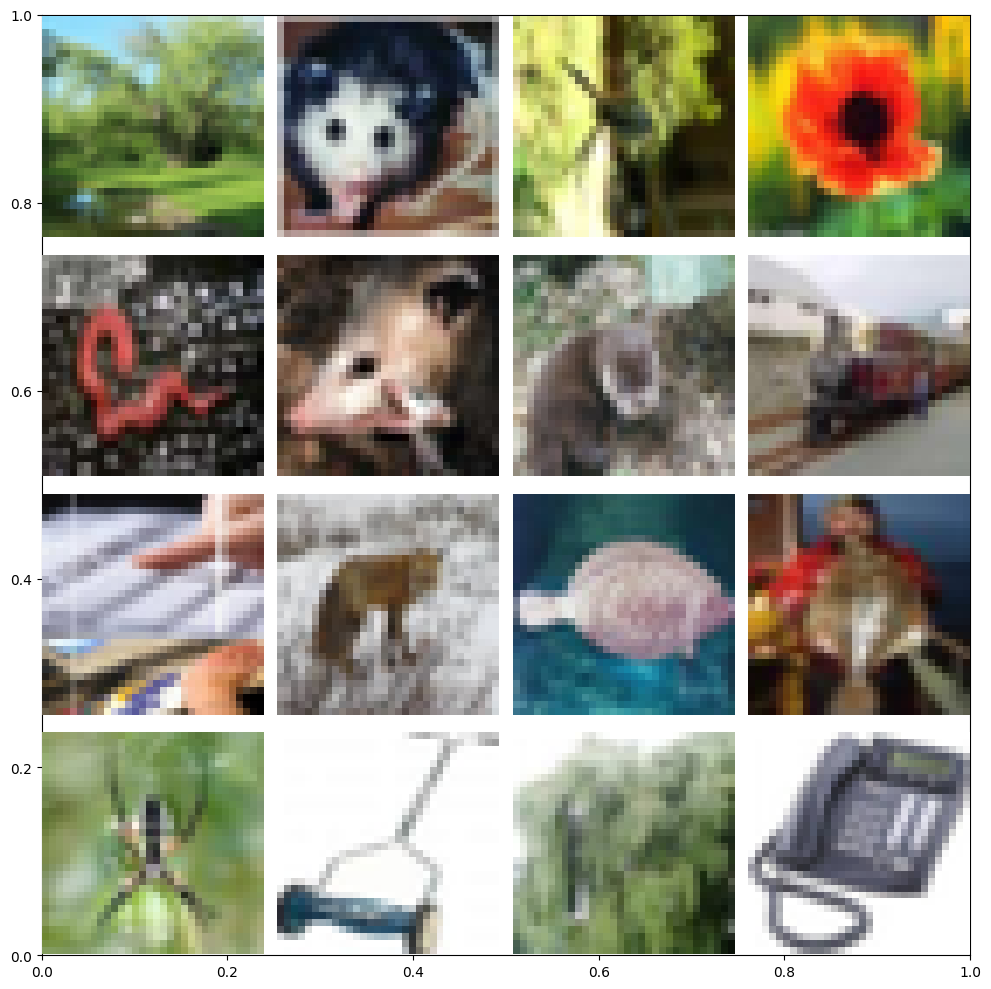

labels[30338].shape: (1,)
imgs[30338].shape: (32, 32, 3)


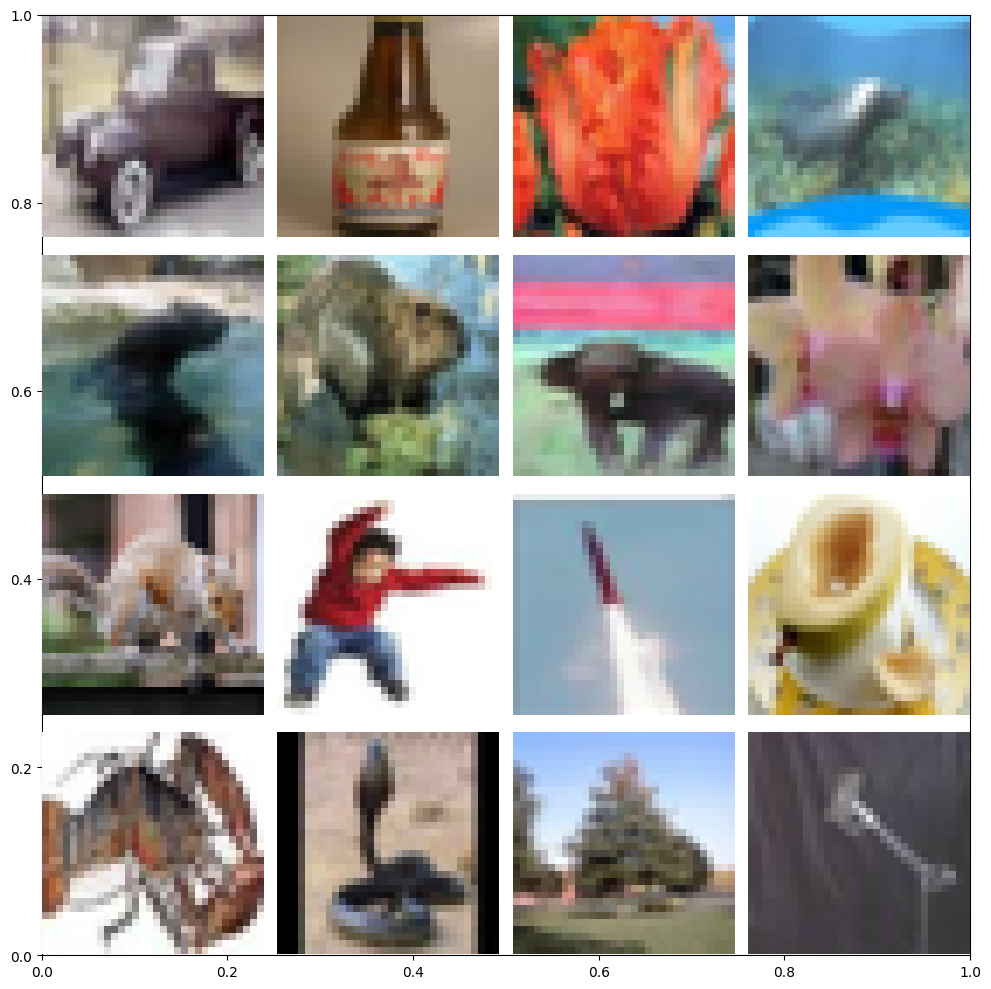

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


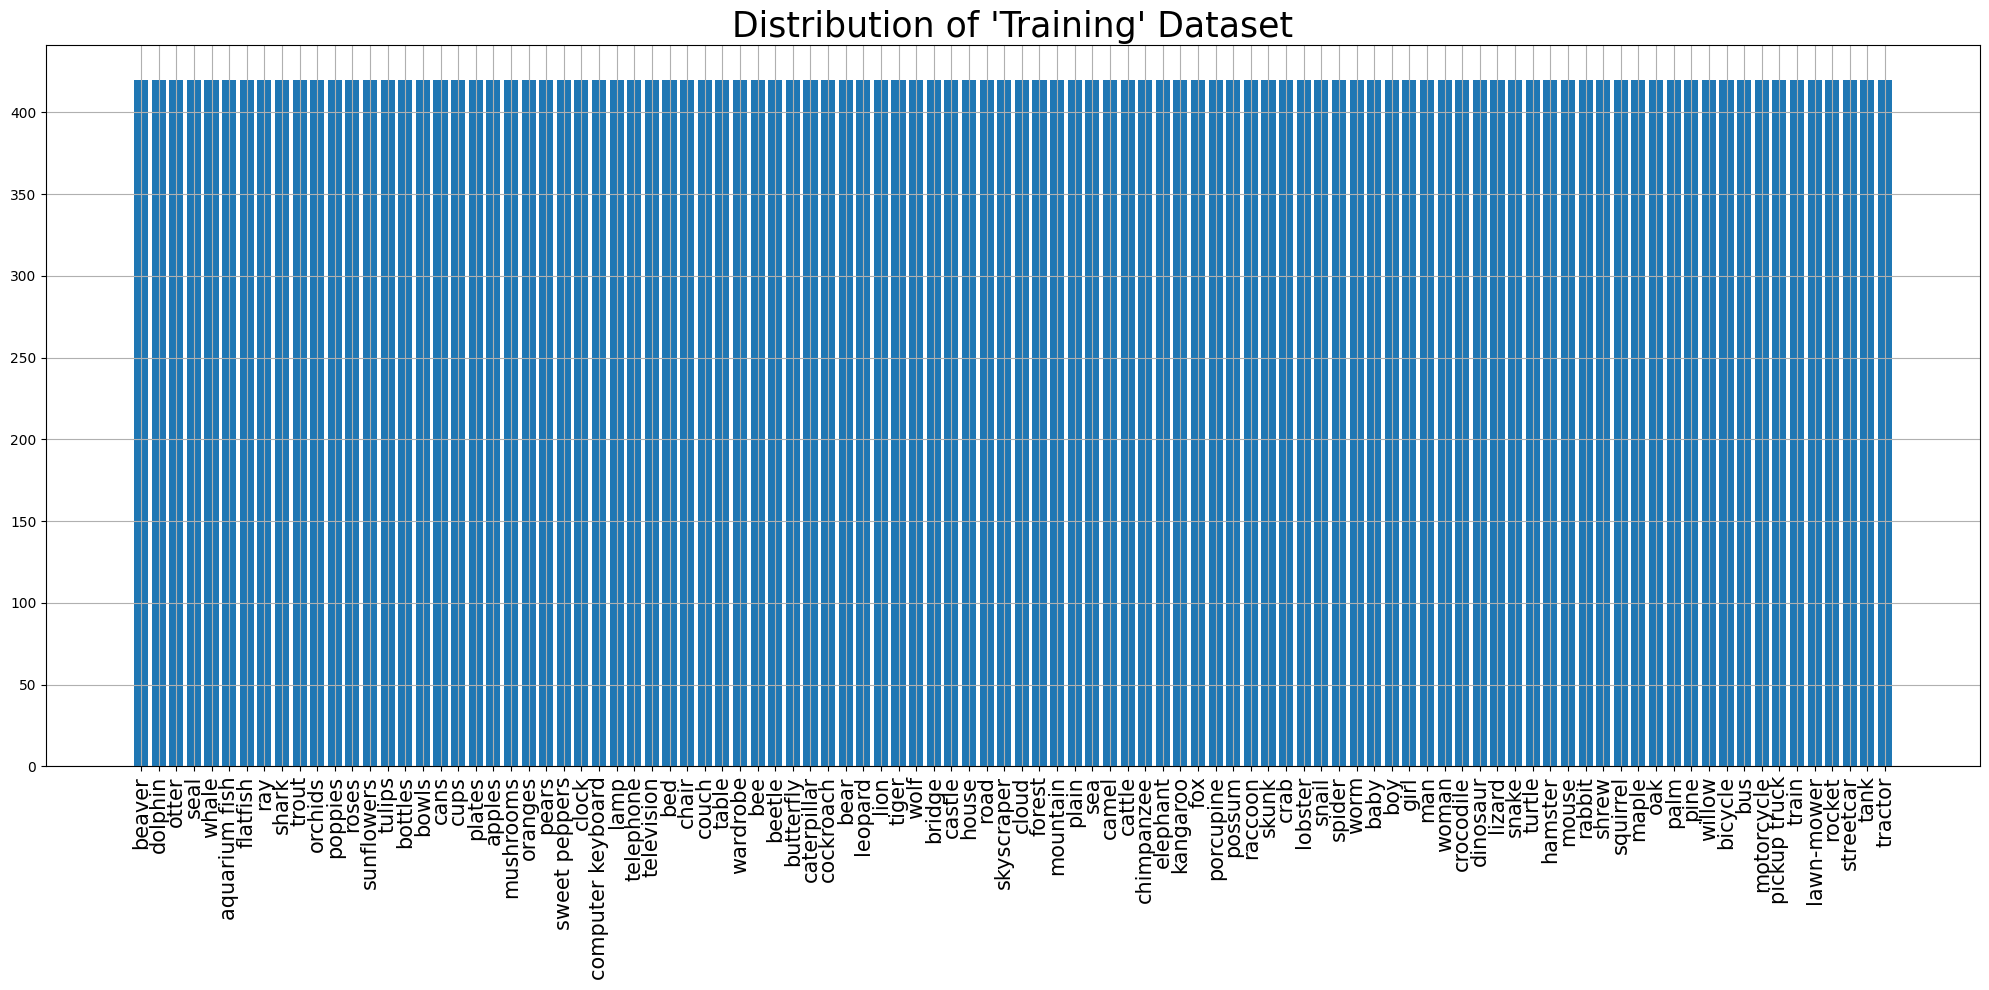

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


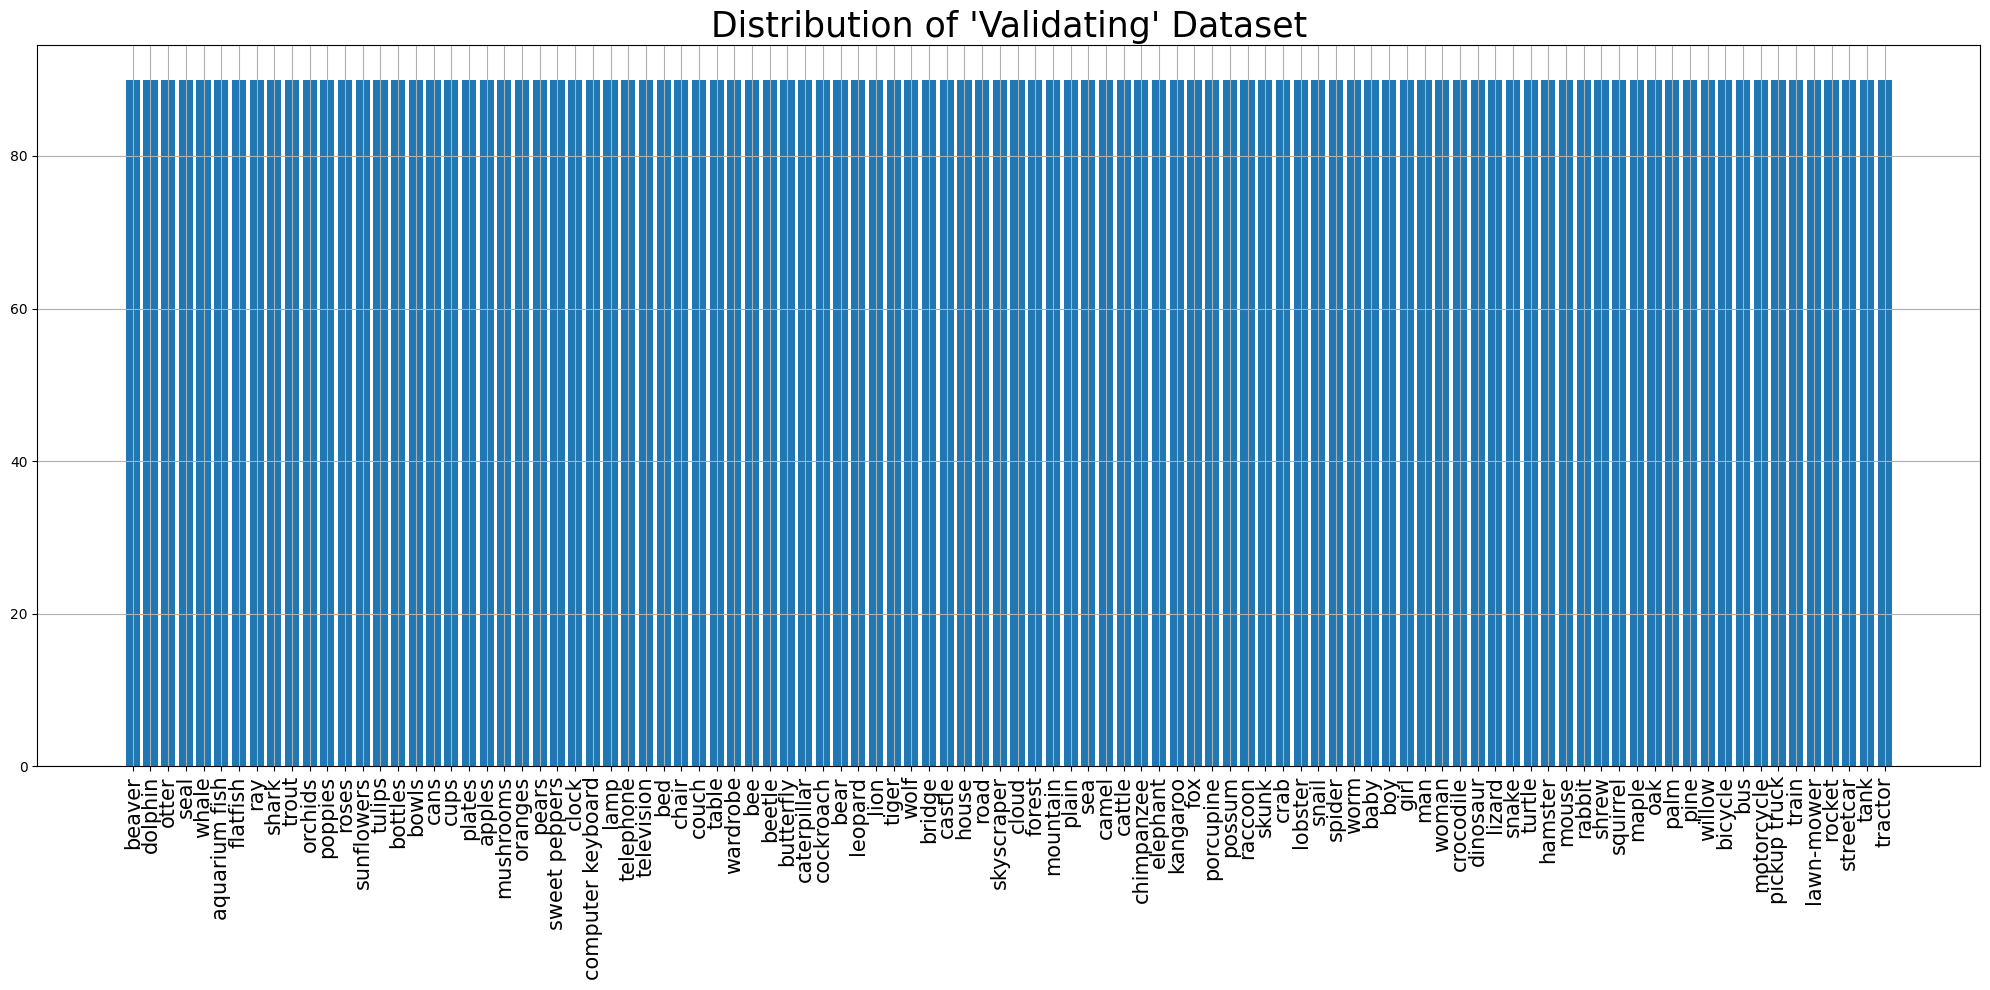

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


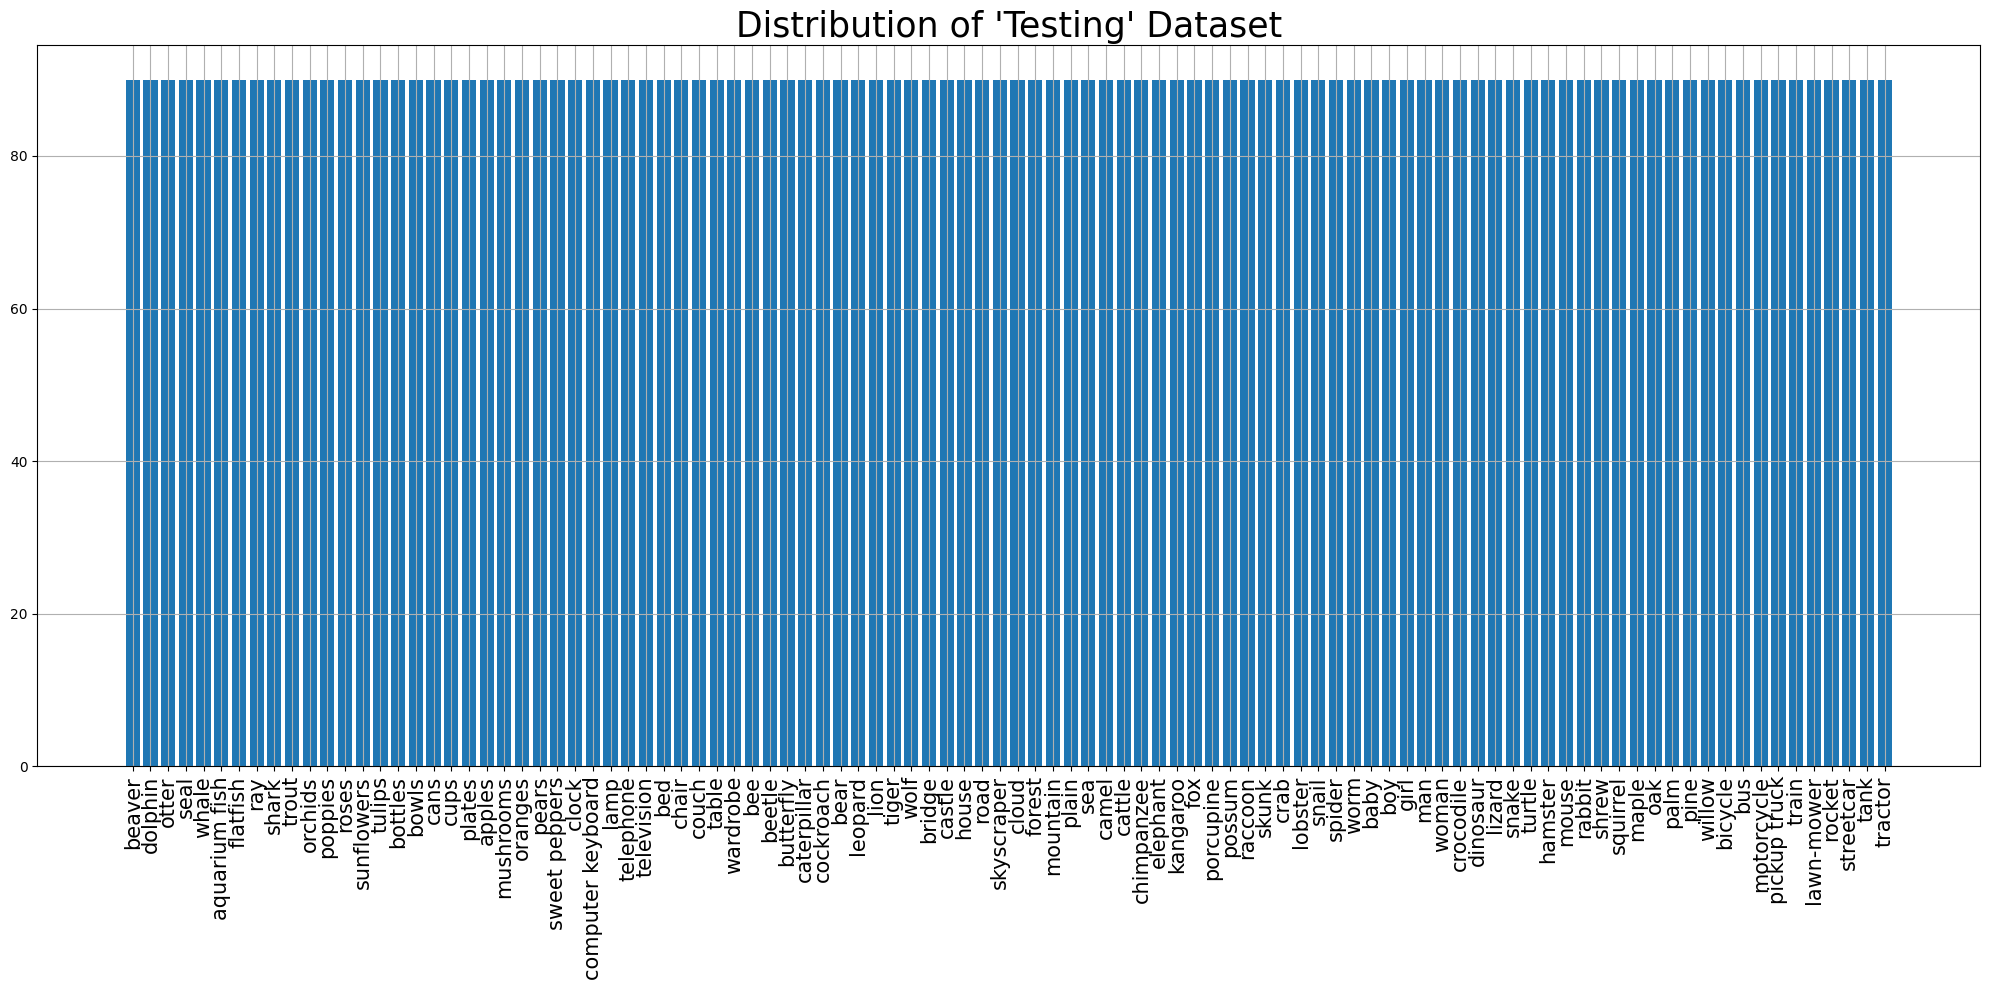

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2482 - f1_score: 0.2399 - loss: 3.2151 - precision: 0.6366
Epoch 1: val_loss improved from inf to 1.70520, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.2484 - f1_score: 0.2400 - loss: 3.2142 - precision: 0.6367 - val_accuracy: 0.5574 - val_f1_score: 0.5468 - val_loss: 1.7052 - val_precision: 0.8685
Epoch 2/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4166 - f1_score: 0.4097 - loss: 2.1577 - precision: 0.7195
Epoch 2: val_loss improved from 1.70520 to 1.63043, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.4166 - f1_score: 0.4097 - loss: 2.1576 - precision: 0.7195 - val_accuracy: 0.5676 - val_f1_score: 0.5567 - val_loss: 1.6304 - val_precision: 0.8621
Epoch 3/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4292 - f1_score: 0.4223 - loss: 2.1058 - precision: 0.7252
Epoch 3: val_loss improved fro

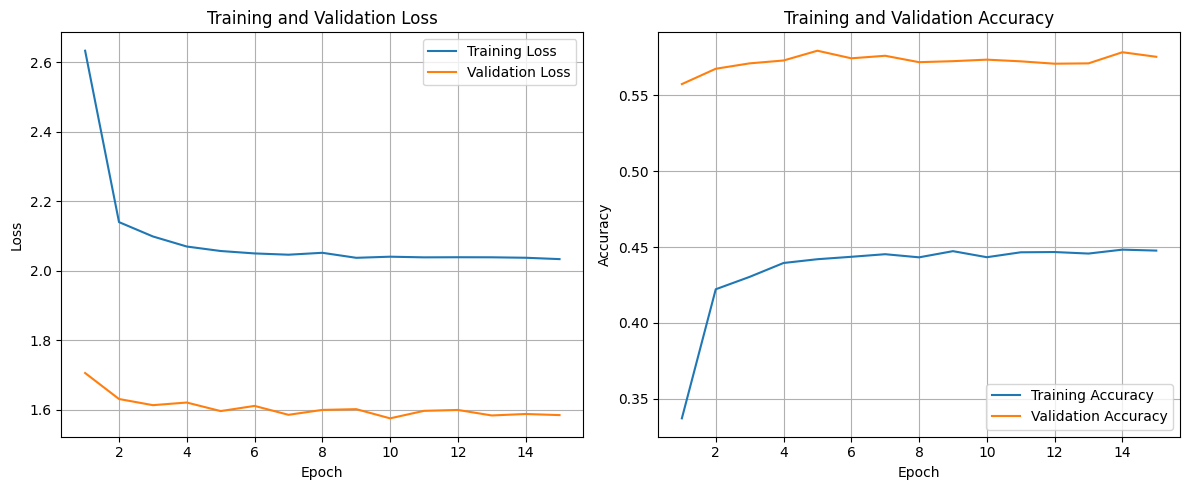

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5662 - f1_score: 0.5526 - loss: 1.5855 - precision: 0.8538
Test Accuracy: 57.90%
Test Loss: 1.5625771284103394
Test Precision: 86.69%
Test F1 Scores (Per Class): [84.26965   70.40816   51.813465  23.214283  20.689651  56.994812
 45.967735  58.41583   75.706215  82.08092   46.15384   40.96385
 63.30935   50.549446  60.56338   48.24561   72.82051   55.290092
 54.92227   56.64739   75.73964   73.61964   78.65168   70.35175
 76.756744  59.067356  40.34334   28.901731  75.12689   56.6265
 48.684204  62.5641    30.656927  41.891888  61.052628   1.9801961
 70.37037   33.58778   43.66197   86.549706  65.454544  77.01149
 48.1203    61.290314  43.43891   36.486485  44.776115  47.899155
 70.93597   77.7202    35.53718   65.93406   58.51528   85.2071
 57.142853  24.61538   71.345024  66.35071   66.666664  27.272722
 76.24309   67.92453   56.96202   61.702126  35.199997  40.2985
 56.41025   42.335762  83.33333   79.01234   63.157898  70.6521

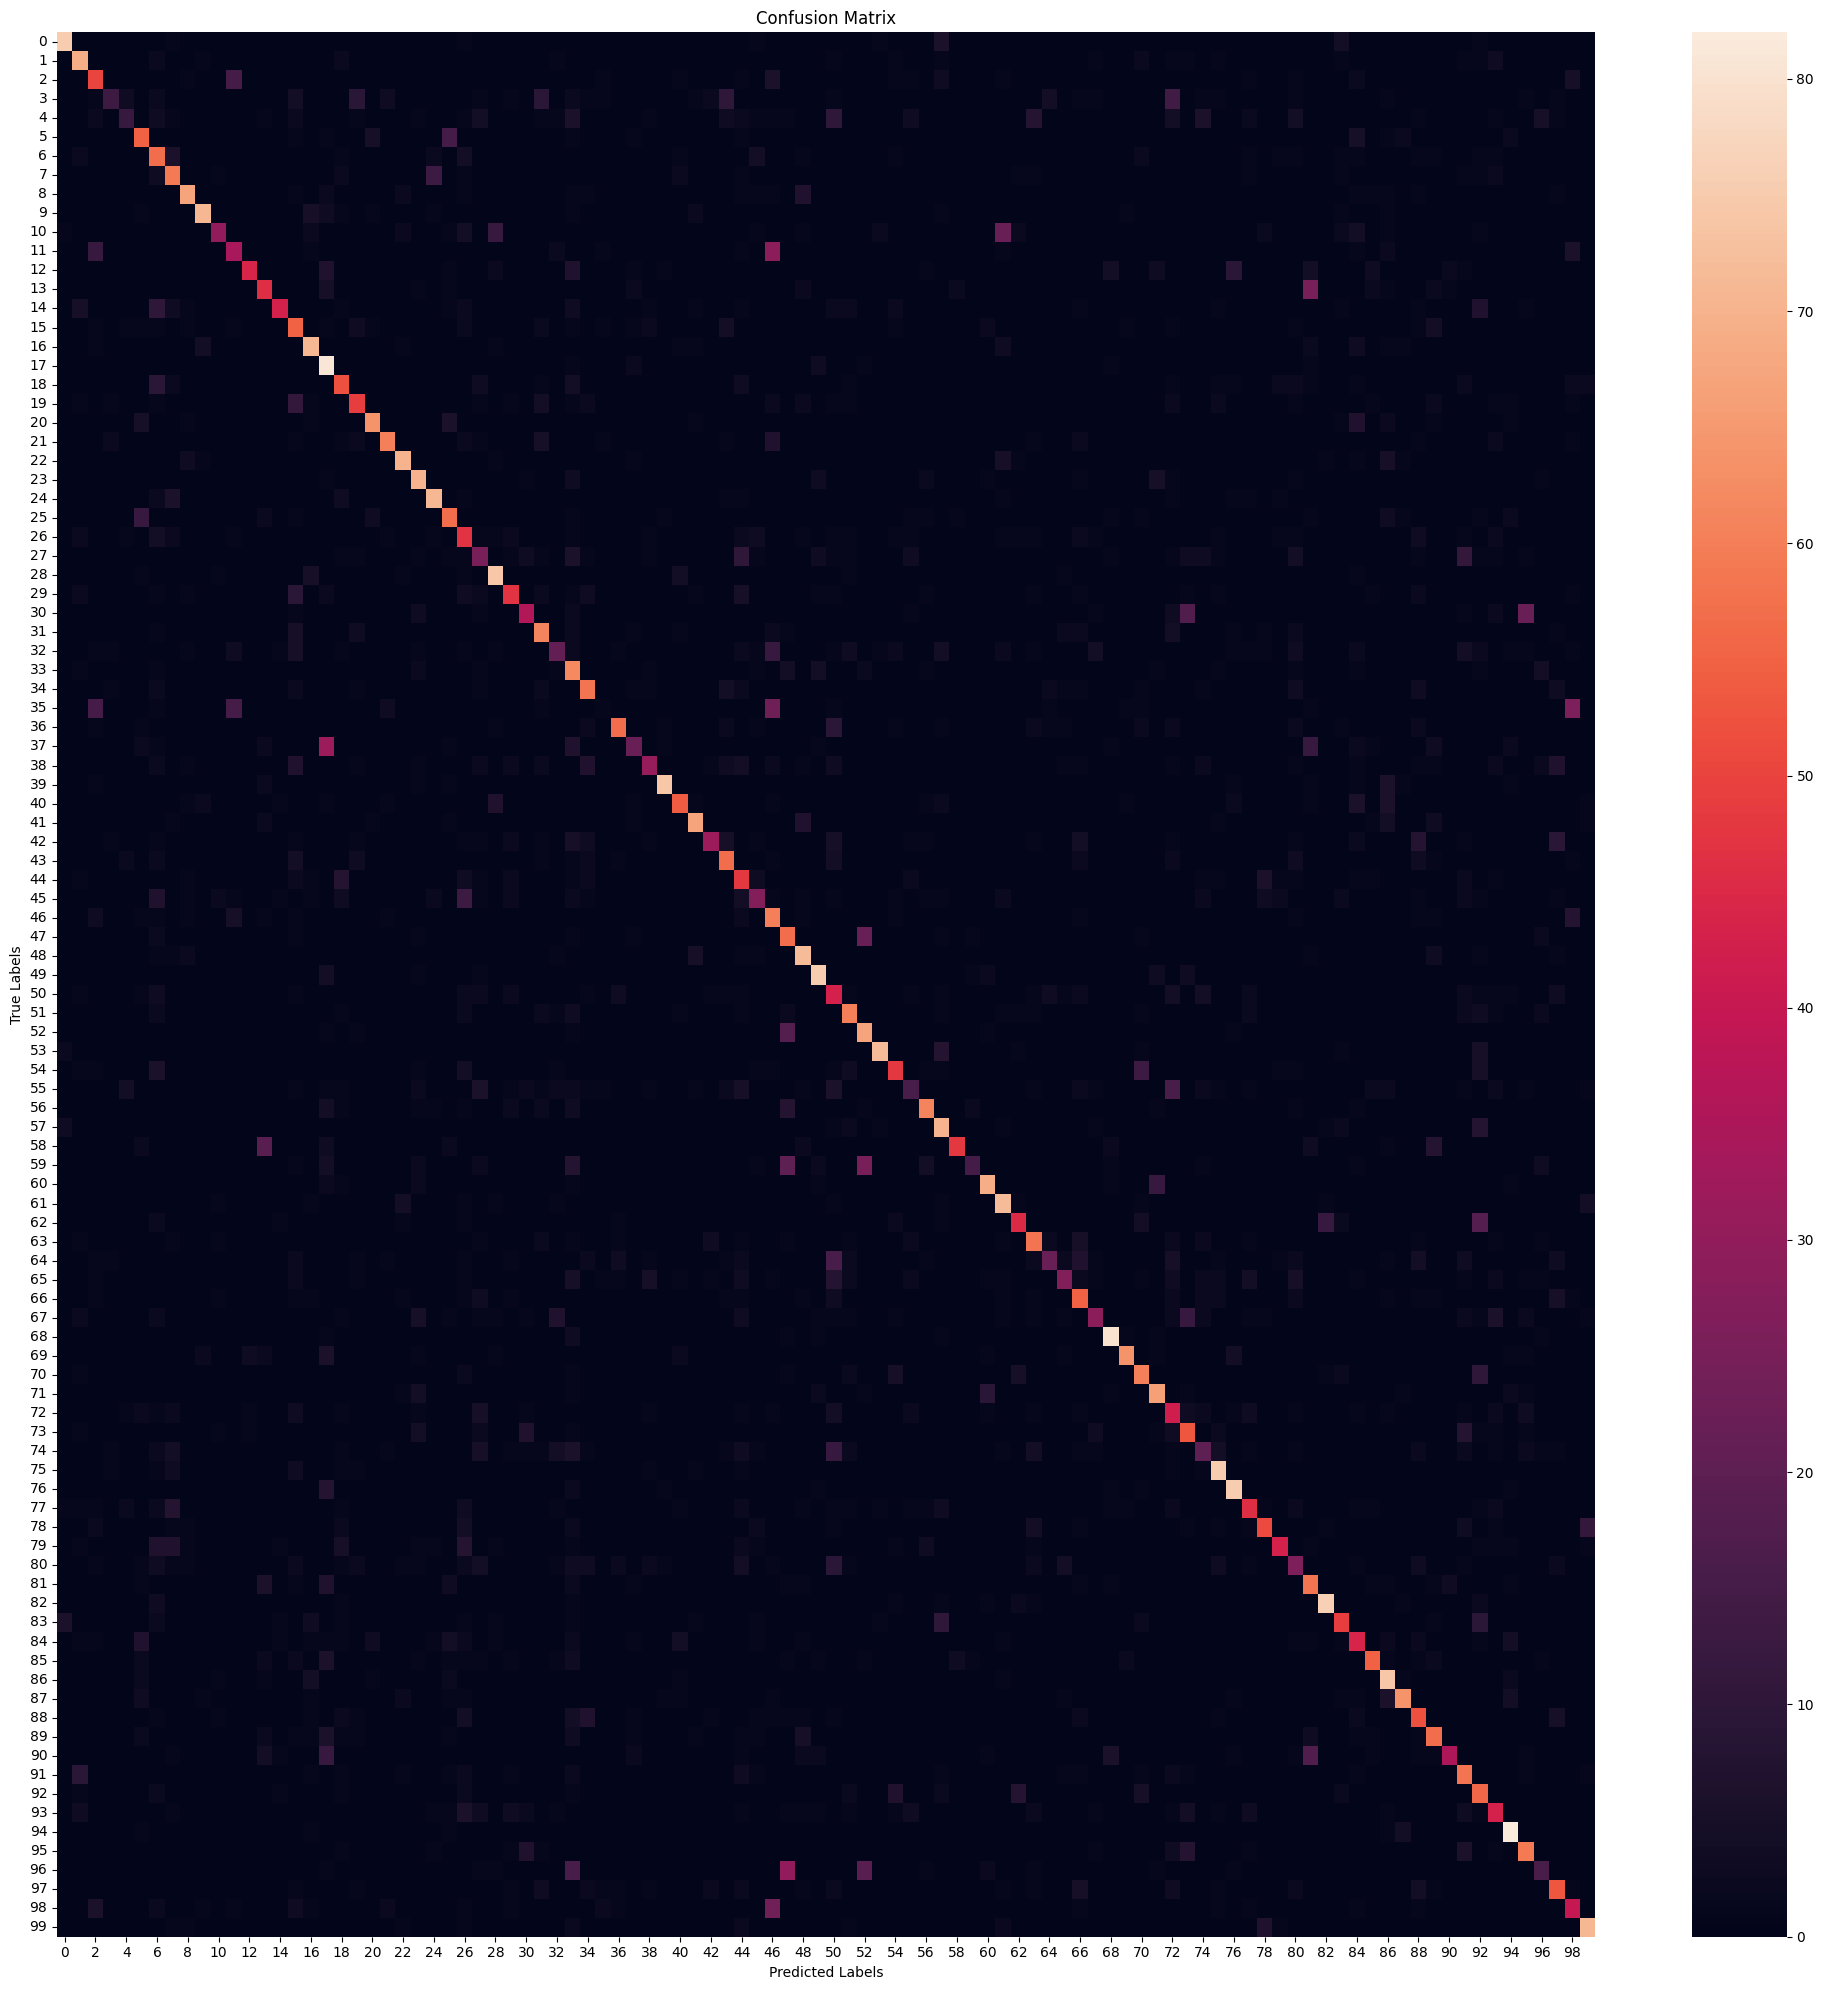

                   precision    recall  f1-score   support

           beaver       0.85      0.83      0.84        90
          dolphin       0.65      0.77      0.70        90
            otter       0.49      0.56      0.52        90
             seal       0.59      0.14      0.23        90
            whale       0.46      0.13      0.21        90
    aquarium fish       0.53      0.61      0.57        90
         flatfish       0.36      0.63      0.46        90
              ray       0.53      0.66      0.58        90
            shark       0.77      0.74      0.76        90
            trout       0.86      0.79      0.82        90
          orchids       0.75      0.33      0.46        90
          poppies       0.45      0.38      0.41        90
            roses       0.90      0.49      0.63        90
       sunflowers       0.50      0.51      0.51        90
           tulips       0.83      0.48      0.61        90
          bottles       0.40      0.61      0.48       

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4693 - f1_score: 0.4615 - loss: 1.9428 - precision: 0.7495
Epoch 1: val_loss improved from inf to 1.47285, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 70s 30ms/step - accuracy: 0.4693 - f1_score: 0.4615 - loss: 1.9427 - precision: 0.7495 - val_accuracy: 0.6004 - val_f1_score: 0.5954 - val_loss: 1.4728 - val_precision: 0.8663
Epoch 2/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5007 - f1_score: 0.4945 - loss: 1.8098 - precision: 0.7713
Epoch 2: val_loss improved from 1.47285 to 1.44951, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.5007 - f1_score: 0.4945 - loss: 1.8098 - precision: 0.7713 - val_accuracy: 0.6066 - val_f1_score: 0.6016 - val_loss: 1.4495 - val_precision: 0.8627
Epoch 3/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5128 - f1_score: 0.5074 - loss: 1.7628 - precision: 0.7783
Epoch 3: v

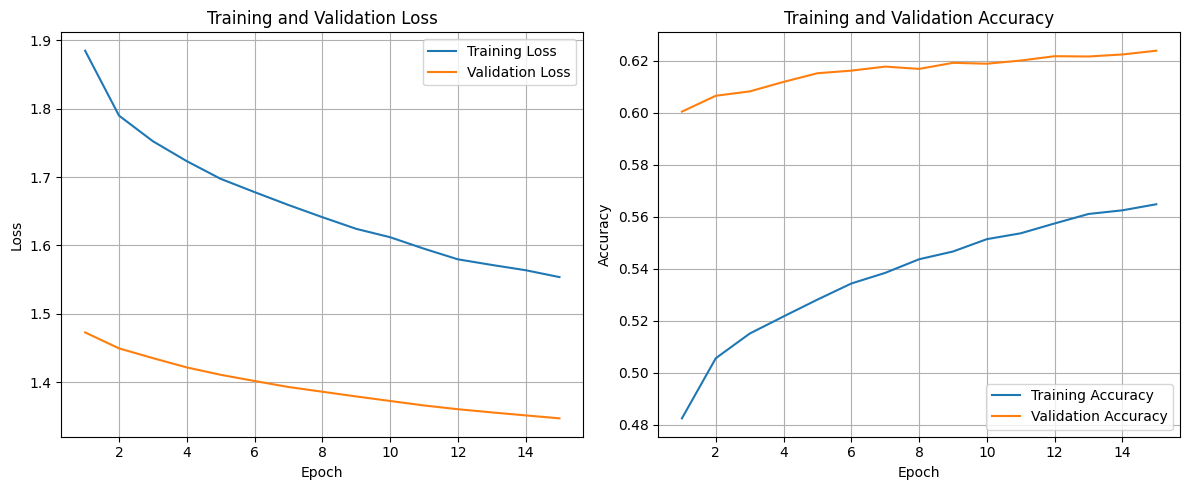

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6179 - f1_score: 0.6087 - loss: 1.3524 - precision: 0.8443
Test Accuracy: 62.78%
Test Loss: 1.3295519351959229
Test Precision: 85.86%
Test F1 Scores (Per Class): [82.872925 72.916664 54.34782  47.953213 29.999996 61.458332 54.639168
 63.905323 78.362564 81.14285  58.757053 49.704136 65.90909  55.421684
 66.27218  58.064507 72.72727  74.99999  58.20105  60.60605  75.82417
 76.8421   77.77777  73.79678  78.30688  62.352936 50.602406 39.495792
 79.768776 65.454544 55.813946 68.263466 41.249996 54.54545  65.217384
 28.235287 67.74193  54.143642 45.977005 88.888885 66.66666  78.61271
 60.1156   69.31818  47.31182  42.76729  49.71751  48.10126  76.381905
 81.08108  33.333332 69.66292  64.57398  85.08286  66.666664 36.249996
 75.14451  67.0391   76.300575 51.282047 77.27273  71.65774  63.541664
 62.499992 42.857136 54.54545  55.6701   55.75757  87.09677  84.656075
 65.088745 70.83333  39.999996 59.459454 32.460724 78.30688  85.56149
 57

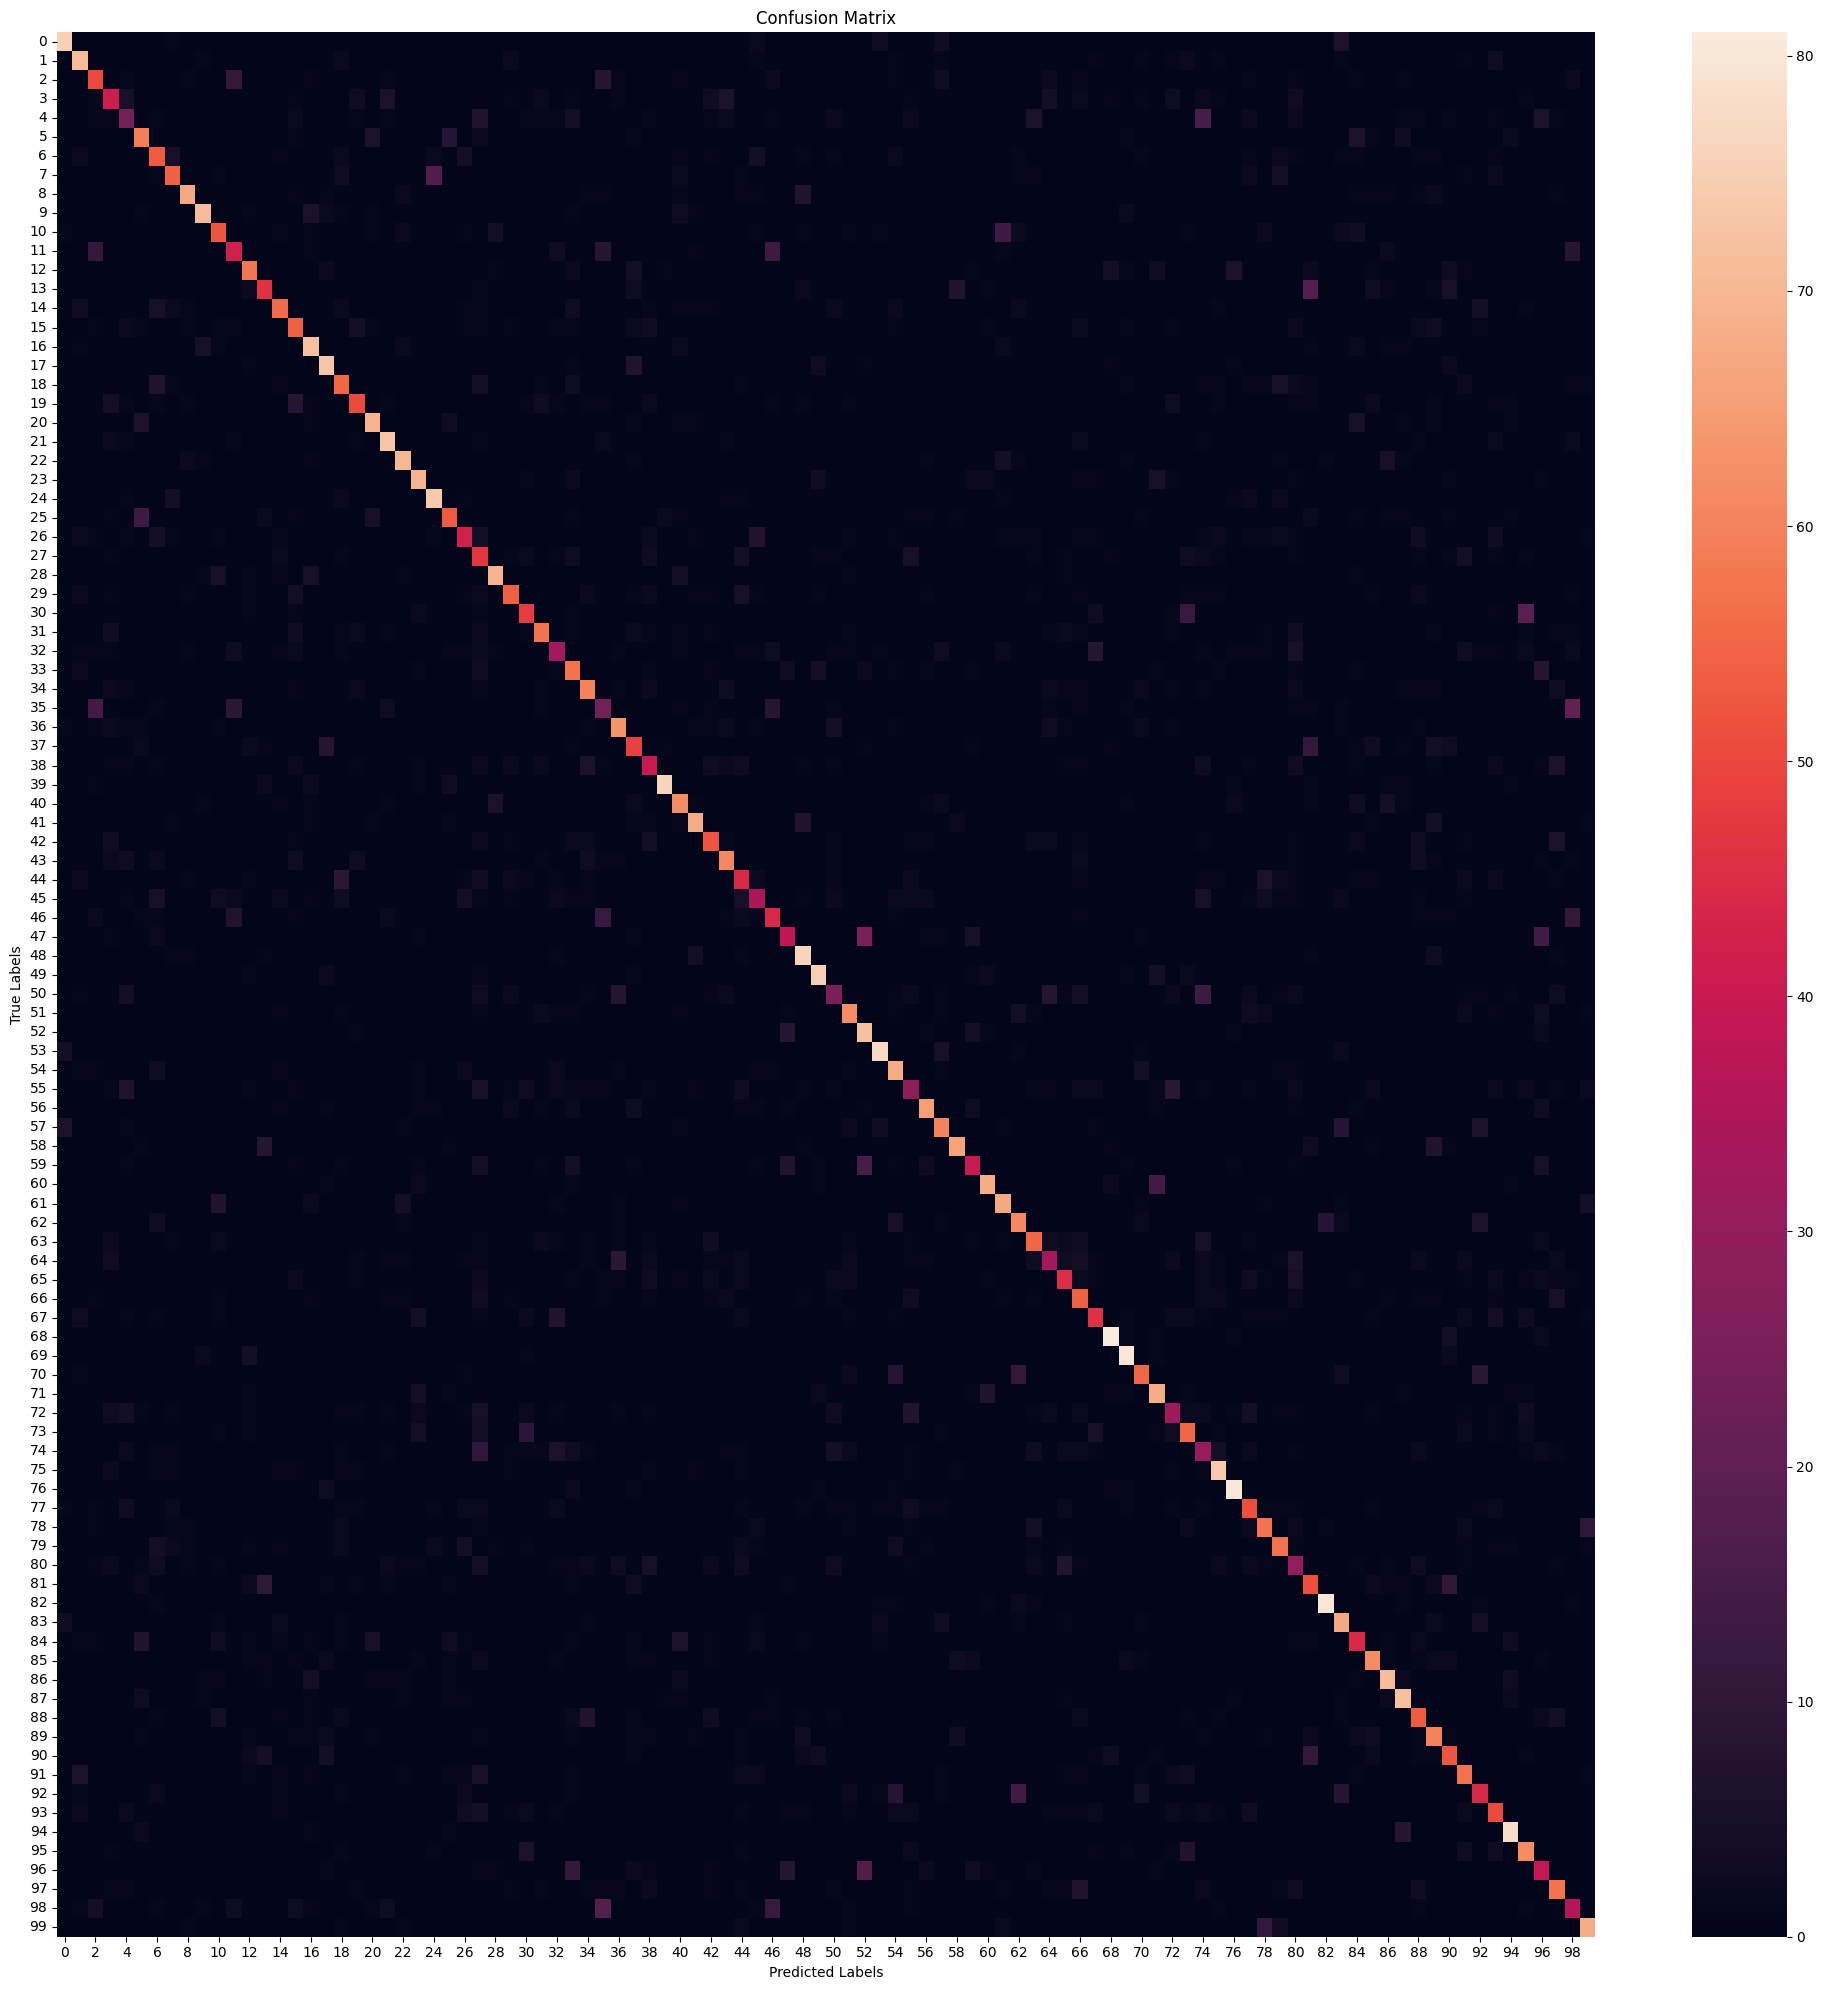

                   precision    recall  f1-score   support

           beaver       0.82      0.83      0.83        90
          dolphin       0.69      0.79      0.74        90
            otter       0.53      0.56      0.54        90
             seal       0.51      0.46      0.48        90
            whale       0.35      0.27      0.30        90
    aquarium fish       0.58      0.66      0.61        90
         flatfish       0.50      0.59      0.54        90
              ray       0.68      0.60      0.64        90
            shark       0.83      0.74      0.78        90
            trout       0.84      0.79      0.81        90
          orchids       0.60      0.58      0.59        90
          poppies       0.53      0.47      0.50        90
            roses       0.67      0.64      0.66        90
       sunflowers       0.61      0.51      0.55        90
           tulips       0.71      0.62      0.66        90
          bottles       0.56      0.60      0.58       

In [7]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(0.9) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.8), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=0.9), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v3.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v3.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist